# **Segmentez des clients d'un site e-commerce** 
## partie 1/4 : analyse exploratoire


### <br> Notre mission (points clés)

> &emsp; - Réaliser une "segmentation des clients" pour "comprendre les différents types d’utilisateurs". <br><br>
&emsp; - "Fournir à l’équipe Marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps." <br><br><br>
&emsp; En résumé : Utiliser "des méthodes non supervisées pour regrouper des clients de profils similaires." <br><br>


## 1 Importation des librairies, réglages

In [1]:
import sys
import numpy as np
import random
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# from zipfile import ZipFile

print('Python version ' + sys.version) 
print('\npandas version ' + pd.__version__)
print('sns version ' + sns.__version__)

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
sns.set(font_scale=1)


Python version 3.11.4 (main, Jul  5 2023, 14:15:25) [GCC 11.2.0]

pandas version 2.1.1
sns version 0.12.2


## Fonctions 

In [2]:
def quick_look(df, miss=True):
    """
    Display a quick overview of a DataFrame, including shape, head, tail, unique values, and duplicates.

    Args:
        df (pandas.DataFrame): The input DataFrame to inspect.
        check_missing (bool, optional): Whether to check and display missing values (default is True).

    The function provides a summary of the DataFrame, including its shape, the first and last rows, the count of unique values per column, and the number of duplicates.
    If `check_missing` is set to True, it also displays missing value information.
    """
    print(f'shape : {df.shape}')

    display(df.head())
    display(df.tail())

    print('uniques :')
    display(df.nunique())

    print('Doublons ? ', df.duplicated(keep='first').sum(), '\n')

    if miss:
        display(get_missing_values(df))
        

def lerp(a, b, t):
    """
    Linear interpolation between two values 'a' and 'b' at a parameter 't'.
    A very useful little function, used here to position annotations in plots.
    Got it coding with Radu :)

    Given two values 'a' and 'b', and a parameter 't', 
    this function calculates the linear interpolation between 'a' and 'b' at 't'.

    Parameters:
    a (float or int): The start value.
    b (float or int): The end value.
    t (float): The interpolation parameter (typically in the range [0, 1], but can be outside).

    Returns:
    float or int: The interpolated value at parameter 't'.
    """
    return a + (b - a) * t


def generate_random_pastel_colors(n):
    """
    Generates a list of n random pastel colors, represented as RGBA tuples.

    Parameters:
    n (int): The number of pastel colors to generate.

    Returns:
    list: A list of RGBA tuples representing random pastel colors.

    Example:
    >>> generate_random_pastel_colors(2)
    [(0.749, 0.827, 0.886, 1.0), (0.886, 0.749, 0.827, 1.0)]
    """
    colors = [] 
    for _ in range(n):
        # Generate random pastels
        red = round(random.randint(150, 250) / 255.0, 3)
        green = round(random.randint(150, 250) / 255.0, 3)
        blue = round(random.randint(150, 250) / 255.0, 3)

        # Create an RGB color tuple and add it to the list
        color = (red,green,blue, 1.0)
        colors.append(color)

    return colors

print(generate_random_pastel_colors(2))


def get_missing_values(df):
    """Generates a DataFrame containing the count and proportion of missing values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame with columns for the feature name, count of missing values, 
        count of non-missing values, proportion of missing values, and data type for each feature.
    """
    # Count the missing values for each column
    missing = df.isna().sum()

    # Calculate the percentage of missing values
    percent_missing = df.isna().mean() * 100

    # Create a DataFrame to store the results
    missings_df = pd.DataFrame({
        'column_name': df.columns,
        'missing': missing,
        'present': df.shape[0] - missing,  # Count of non-missing values
        'percent_missing': percent_missing.round(2),  # Rounded to 2 decimal places
        'type': df.dtypes
    })

    # Sort the DataFrame by the count of missing values
    missings_df.sort_values('missing', inplace=True)

    return missings_df

# with pd.option_context('display.max_rows', 1000):
#   display(get_missing_values(df))


# ma fonction d'origine (non cleanée)
def hist_distrib(dataframe, feature, bins, r, density=True):
    """
    Affiche un histogramme, pour visualiser la distribution empirique d'une variable
    Argument : df, feature num
    """
    # calcul des tendances centrales :
    mode =  str(round(dataframe[feature].mode()[0], r))
    # mode is often zero, so Check if there are non nul values in the column
    if (dataframe[feature] != 0).any():
        mode_non_nul = str(round(dataframe.loc[dataframe[feature] != 0, feature].mode()[0], r))
    else:
        mode_non_nul = "N/A"
    mediane = str(round(dataframe[feature].median(), r))
    moyenne = str(round(dataframe[feature].mean(), r))
    # dispersion :
    var_emp = str(round(dataframe[feature].var(ddof=0), r))
    coeff_var =  str(round(dataframe[feature].std(ddof=0), r)) # = écart-type empirique / moyenne
    # forme
    skewness = str(round(dataframe[feature].skew(), 2))
    kurtosis = str(round(dataframe[feature].kurtosis(), 2))
    
    fig, ax = plt.subplots(figsize=(12, 5))
    dataframe[feature].hist(density=density, bins=bins, ax=ax)
    yt = plt.yticks()
    y = lerp(yt[0][0], yt[0][-1], 0.8)
    t = y/20
    xt = plt.xticks()
    x = lerp(xt[0][0], xt[0][-1], 0.7)
    plt.title(feature, pad=20, fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    fs =13
    plt.annotate('Mode : ' + mode, xy = (x, y), fontsize = fs, xytext = (x, y), color = 'g')
    plt.annotate('Mode + : ' + mode_non_nul, xy = (x, y-t), fontsize = fs, xytext = (x, y-t), color = 'g')
    plt.annotate('Médiane : ' + mediane, xy = (x, y-2*t), fontsize = fs, xytext = (x, y-2*t), color = 'g')
    plt.annotate('Moyenne : ' + moyenne, xy = (x, y-3*t), fontsize = fs, xytext = (x, y-3*t), color = 'g')
    
    plt.annotate('Var emp : ' + var_emp, xy = (x, y-5*t), fontsize = fs, xytext = (x, y-5*t), color = 'g')
    plt.annotate('Coeff var : ' + coeff_var, xy = (x, y-6*t), fontsize = fs, xytext = (x, y-6*t), color = 'g')

    plt.annotate('Skewness : ' + skewness, xy = (x, y-8*t), fontsize = fs, xytext = (x, y-8*t), color = 'g')
    plt.annotate('Kurtosis : ' + kurtosis, xy = (x, y-9*t), fontsize = fs, xytext = (x, y-9*t), color = 'g')
    plt.show()

    return float(skewness) # pour eventuel passage au log

# version cleanée
def hist_distrib(dataframe, feature, bins, decimal_places, density=True):
    """
    Visualize the empirical distribution of a numerical feature using a histogram.
    Calcul des principaux indicateurs de tendance centrale, dispersion et forme.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.
        bins (int): The number of bins for the histogram.
        decimal_places (int): The number of decimal places for rounding numeric values.
        density (bool, optional): Whether to display the histogram as a density plot (default is True).

    Returns:
        float: The skewness of the feature's distribution.

    The function generates a histogram of the feature, displays various statistics, and returns the skewness of the distribution.
    """
    # Calculate central tendencies and dispersion
    mode_value = round(dataframe[feature].mode()[0], decimal_places)
    mode_non_zero = "N/A"
    if (dataframe[feature] != 0).any():
        mode_non_zero = round(dataframe.loc[dataframe[feature] != 0, feature].mode()[0], decimal_places)
    median_value = round(dataframe[feature].median(), decimal_places)
    mean_value = round(dataframe[feature].mean(), decimal_places)
    
    # Calculate dispersion
    var_emp = round(dataframe[feature].var(ddof=0), decimal_places)
    coeff_var = round(dataframe[feature].std(ddof=0), decimal_places)

    # Calculate shape indicators
    skewness_value = round(dataframe[feature].skew(), 2)
    kurtosis_value = round(dataframe[feature].kurtosis(), 2)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 5))
    dataframe[feature].hist(density=density, bins=bins, ax=ax)
    
    # Adjust placement for annotations
    yt = plt.yticks()
    y_position = lerp(yt[0][0], yt[0][-1], 0.8)
    y_increment = y_position / 20
    xt = plt.xticks()
    x_position = lerp(xt[0][0], xt[0][-1], 0.7)
    
    # Add annotations with horizontal and vertical alignment
    annotation_fs = 13
    color = 'g'
    ax.annotate(f'Mode: {mode_value}', xy=(x_position, y_position), fontsize=annotation_fs,
                xytext=(x_position, y_position), color=color, ha='left', va='bottom')
    ax.annotate(f'Mode +: {mode_non_zero}', xy=(x_position, y_position - y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Median: {median_value}', xy=(x_position, y_position - 2 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 2 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Mean: {mean_value}', xy=(x_position, y_position - 3 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 3 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Var Emp: {var_emp}', xy=(x_position, y_position - 5 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 5 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Coeff Var: {coeff_var}', xy=(x_position, y_position - 6 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 6 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Skewness: {skewness_value}', xy=(x_position, y_position - 8 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 8 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Kurtosis: {kurtosis_value}', xy=(x_position, y_position - 9 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 9 * y_increment), color=color, ha='left', va='bottom')
    
    # Label the x-axis and y-axis
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    
    # Show the plot
    plt.title(f'Distribution of {feature}', pad=20, fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    return skewness_value


def boxplot_distrib(dataframe, feature):
    """
    Affiche un boxplot, pour visualiser les tendances centrales et la dispersion d'une variable.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.

    The function generates a box plot of the feature to display central tendencies (median and mean) and dispersion.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    medianprops = {'color':"blue"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
    dataframe.boxplot(feature, vert=False, showfliers=False, medianprops=medianprops, patch_artist=True, showmeans=True, meanprops=meanprops)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


def courbe_lorenz(dataframe, feature):
    """
    Affiche une courbe de Lorenz, pour visualiser la concentration d'une variable
    Calcule l'indice de Gini
    Visualize a Lorenz curve to assess the concentration of a variable and calculate the Gini coefficient.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.

    The function generates a Lorenz curve to assess the concentration of the feature and calculates the Gini coefficient.
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    values = dataframe.loc[dataframe[feature].notna(), feature].values
    # print(values)
    n = len(values)
    lorenz = np.cumsum(np.sort(values)) / values.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

    xaxis = np.linspace(0-1/n,1+1/n,n+1) 
    #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. 
    # #Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    plt.plot(np.arange(2),[x for x in np.arange(2)])
    # calcul de l'indice de Gini
    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
    S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
    gini = 2*S
    plt.annotate('gini =  ' + str(round(gini, 2)), xy = (0.04, 0.88), fontsize = 13, xytext = (0.04, 0.88), color = 'g')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show() 


def graphs_analyse_uni(dataframe, feature, bins=50, r=5, density=True):
    """
    Affiche histogramme + boxplot + courbe de Lorenz
    
    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to analyze.
        bins (int, optional): The number of bins for the histogram (default is 50).
        decimal_places (int, optional): The number of decimal places for rounding numeric values (default is 5).
        density (bool, optional): Whether to display the histogram as a density plot (default is True).

    The function generates and displays an analysis of the given numerical feature, including an histogram, a box plot, and a Lorenz curve.
    """   
    hist_distrib(dataframe, feature, bins, r)
    boxplot_distrib(dataframe, feature)
    courbe_lorenz(dataframe, feature)


def shape_head(df, nb_rows=5):
    """
    Affiche les dimensions et les premières lignes dùun dataframe
    Display the dimensions and the first rows of a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame to display.
        nb_rows (int, optional): The number of rows to display (default is 5, max is 60).

    The function prints the dimensions of the DataFrame and displays the first few rows.
    """
    print(df.shape)
    display(df.head(nb_rows))


def doughnut(df, feature, title, width=10, height=10):
    """
    Affiche la répartition d'une feature sous forme de diagramme circulaire  
    Display the distribution of a feature as a doughnut chart.
    Les couleurs sont aléatoires.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the feature to visualize.
        title (str): The title for the doughnut chart.
        width (int, optional): The width of the chart (default is 10).
        height (int, optional): The height of the chart (default is 10).

    The function creates a doughnut chart to visualize the distribution of the specified feature.
    If you don't like the colors, try running it again :)
    """
    colors = generate_random_pastel_colors(20)

    grouped_df = df.groupby(feature).size().to_frame("count_per_type").reset_index()
    pie = grouped_df.set_index(feature).copy()

    fig, ax = plt.subplots(figsize=(width, height))

    patches, texts, autotexts = plt.pie(x=pie['count_per_type'], autopct='%1.1f%%',
        startangle=-30, labels=pie.index, textprops={'fontsize':11, 'color':'#000'}, 
        labeldistance=1.25, pctdistance=0.85, colors=colors)
    
    plt.title(
    label=title, 
    fontdict={"fontsize":17},
    pad=20
    )

    for text in texts:
        # text.set_fontweight('bold')
        text.set_horizontalalignment('center')

    # Customize percent labels
    for autotext in autotexts:
        autotext.set_horizontalalignment('center')
        autotext.set_fontstyle('italic')
        autotext.set_fontsize('10')

    #draw circle
    centre_circle = plt.Circle((0,0),0.7,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.show()


def get_non_null_values(df):
    """ 
    Génère un dataframe contenant le nombre et la proportion de non-null (non-zero) valeurs pour chaque feature
    Generate a DataFrame containing the count and proportion of non-null (non-zero) values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    The function calculates and returns a DataFrame with the count and percentage of non-null (non-zero) values for each feature.
    """
    non_null_counts = df.ne(0).sum()
    percent_non_null = (non_null_counts / df.shape[0]) * 100
    non_null_values_df = pd.DataFrame({'column_name': df.columns,
                                       'non_null_count': non_null_counts,
                                       'percent_non_null': percent_non_null.round(2),
                                       'type': df.dtypes})
    non_null_values_df.sort_values('non_null_count', inplace=True)
    return non_null_values_df


def get_colors(n=7):
    """
    Generate a list of random colors from multiple colormaps.

    Args:
        n (int, optional): The number of colors to sample from each colormap (default is 7).

    Returns:
        list: A list of random colors sampled from different colormaps.
    """
    num_colors_per_colormap = n  
    colormaps = [plt.cm.Pastel2, plt.cm.Set1, plt.cm.Paired]
    all_colors = []

    for colormap in colormaps:
        colors = colormap(np.linspace(0, 1, num_colors_per_colormap))
        all_colors.extend(colors)

    np.random.shuffle(all_colors)

    return all_colors


[(0.616, 0.722, 0.698, 1.0), (0.702, 0.612, 0.663, 1.0)]


## 2 Contenu des 9 tables

In [3]:
# On va jeter tt de suite un coup d'oeil à ce qui nous intéresse le +, les clients,
# sans oublier que les commandes (table 'orders') sont au centre de la bdd.


### customers

In [4]:
# segmentation clientele = on veut un dataframe avec un client par ligne (= le fichier par client)
# et les features qui nous interessent en colonnes

# Pour cela on va d'abord fabriquer un dataframe plus grand (le fichier des commandes),
# par merge des différentes tables (9 tables disponibles).

# Nous allons donc commencer par analyser le contenu de chaque table.

raw_df_customers = pd.read_csv('data/archive/olist_customers_dataset.csv', sep=',')

print('Customers_dataset :', '\n')
quick_look(raw_df_customers)

# Utile. 99 441 orders from 96 087 clients (the 3%)
# Indispensable pour lier customer_unique_id et order_id (grâce à customer_id)

# donnes geographiques. (pas forcément utile comme feature, mais sympa pour visu / interprêtation)
# city on n'en fera rien, trop de valeurs uniques. state peut-être pour visu,
# mais on va éviter les variables catégoriques sur ce projet 
# (conseil technique pour éviter d'avoir des clusters très difficiles à interpréter,
# qui n'ont "aucun sens métier").

df_customers = raw_df_customers.drop(['customer_city'], axis=1).copy()

# zipcode sert de clé pour avoir les coordonnées, latitude et longitude (table géo)
df_customers = df_customers.rename(columns={'customer_zip_code_prefix': 'zipcode'})

print(df_customers.shape)


Customers_dataset : 

shape : (99441, 5)


customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

customer_id                customer_unique_id  \
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix    customer_city customer_state  
99436                      3937        sao paulo             SP  
99437                      6764  taboao da serra             SP  
99438                     60115        fortaleza             CE  
99439                     92120           canoas             RS  
99440                      6703            cotia             SP

uniques :


customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

Doublons ?  0 



column_name  missing  present  \
customer_id                            customer_id        0    99441   
customer_unique_id              customer_unique_id        0    99441   
customer_zip_code_prefix  customer_zip_code_prefix        0    99441   
customer_city                        customer_city        0    99441   
customer_state                      customer_state        0    99441   

                          percent_missing    type  
customer_id                           0.0  object  
customer_unique_id                    0.0  object  
customer_zip_code_prefix              0.0   int64  
customer_city                         0.0  object  
customer_state                        0.0  object

(99441, 4)


### orders

In [5]:
raw_df_orders = pd.read_csv('data/archive/olist_orders_dataset.csv', sep=',')

print('Orders_dataset :', '\n')
quick_look(raw_df_orders)

# shape[0] same as before
# 8 features. infos sur statut livraison (effectuée), puis dates et heures :
# de la commande, commande approuvée, commande remise au livreur, livree au client, date (limite?) estimée.

# remarque pas importante :
# It seems they don't always use a carrier ? (dans un peu + de 80% des cas.)

# TRES UTILE

print(raw_df_orders['order_status'].unique())

# PREMIÈRES VALEURS MANQUANTES
# (commandes pas encore approuvées / livrées)
# on traitera + tard si nécessaire


Orders_dataset : 

shape : (99441, 8)


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

order_id                       customer_id  \
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp    order_approved_at  \
99436    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  
99436           2017-03-28 00:00:00  
99437           2018-03-02 00:00:00  
99438           2017-09-27 00:00:00  
99439           2018-02-15 00:00:00  
99440           2018-04-03 00:00:00

uniques :


order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

Doublons ?  0 



column_name  missing  \
order_id                                            order_id        0   
customer_id                                      customer_id        0   
order_status                                    order_status        0   
order_purchase_timestamp            order_purchase_timestamp        0   
order_estimated_delivery_date  order_estimated_delivery_date        0   
order_approved_at                          order_approved_at      160   
order_delivered_carrier_date    order_delivered_carrier_date     1783   
order_delivered_customer_date  order_delivered_customer_date     2965   

                               present  percent_missing    type  
order_id                         99441             0.00  object  
customer_id                      99441             0.00  object  
order_status                     99441             0.00  object  
order_purchase_timestamp         99441             0.00  object  
order_estimated_delivery_date    99441             0.00  object  
order_approved_at                99281             0.16  object  
order_delivered_carrier_date     97658             1.79  object  
order_delivered_customer_date    96476             2.98  object

['delivered' 'invoiced' 'shipped' 'processing' 'unavailable' 'canceled'
 'created' 'approved']


#### Première visu dates : nb commandes sur la période (hist)

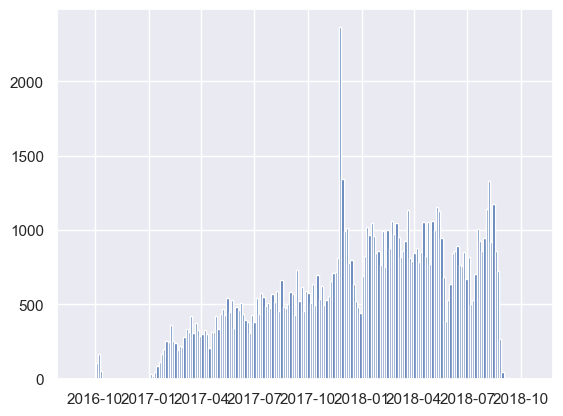

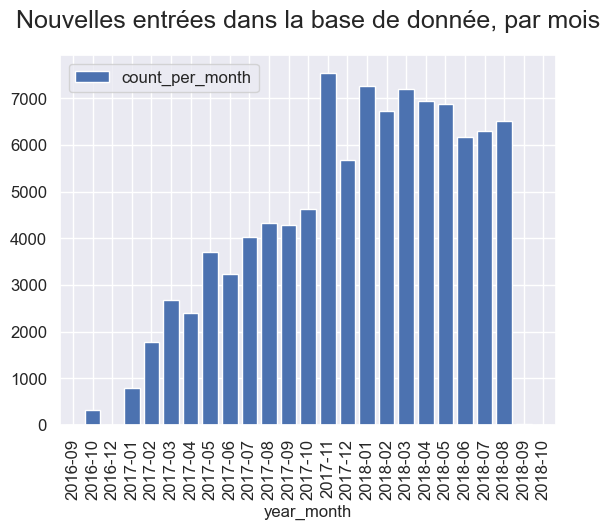

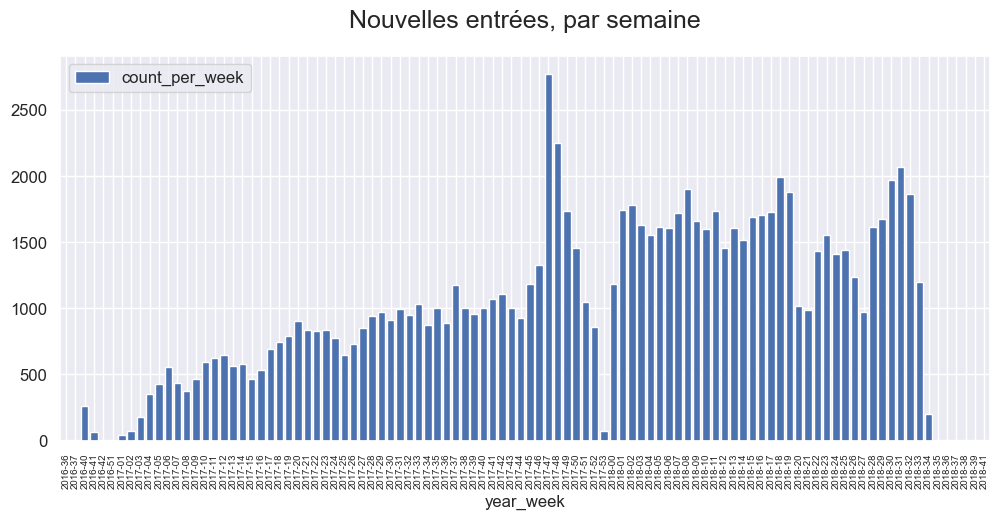

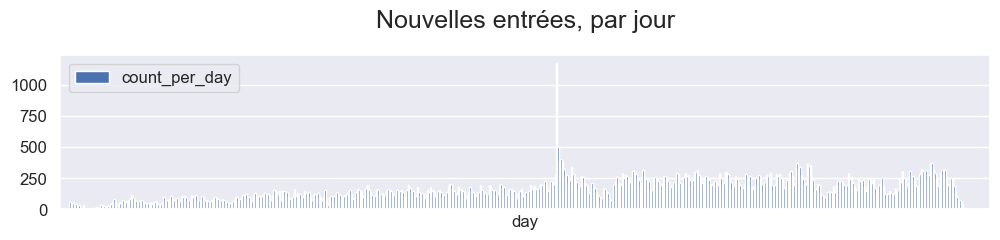

In [6]:
# On a ici une première idée de la période couverte par nos donnés

raw_df_orders['order_purchase_timestamp'] = pd.to_datetime(raw_df_orders['order_purchase_timestamp'])
raw_df_orders['order_purchase_timestamp'].hist(density=False, bins=200)


# par mois :
orders_df = raw_df_orders.copy()
orders_df['year_month'] = raw_df_orders['order_purchase_timestamp'].map(lambda dt: dt.strftime('%Y-%m'))
grouped_df_month = orders_df.groupby('year_month').size().to_frame("count_per_month").reset_index()

grouped_df_month.plot(kind='bar', x='year_month', y='count_per_month', fontsize=12, width=0.8)
plt.title('Nouvelles entrées dans la base de donnée, par mois', fontsize=18, pad=20)
plt.legend(loc='upper left', fontsize=12)
plt.show()

# par semaine
# mon préféré, précis mais pas trop
orders_df['year_week'] = orders_df['order_purchase_timestamp'].map(lambda dt: dt.strftime('%Y-%U'))
grouped_week = orders_df.groupby('year_week').size().to_frame("count_per_week").reset_index()

fig, ax = plt.subplots(figsize=(12, 5)) 

grouped_week.plot(kind='bar', x='year_week', y='count_per_week', fontsize=12, ax=ax, width=0.8)
plt.title('Nouvelles entrées, par semaine', fontsize=18, pad=20)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(fontsize=7)
plt.show()

# par jour
orders_df['day'] = orders_df['order_purchase_timestamp'].map(lambda dt: dt.strftime('%Y-%m-%d'))

grouped_day = orders_df.groupby('day').size().to_frame("count_per_day").reset_index()
grouped_day = grouped_day.sort_values('day')

fig1, ax1 = plt.subplots(figsize=(12, 2)) 

grouped_day.plot(kind='bar', x='day', y='count_per_day', fontsize=12, ax=ax1, width=1)
plt.title('Nouvelles entrées, par jour', fontsize=18, pad=20)
plt.legend(loc='upper left', fontsize=12)
# Remove x-ticks, de ttes façons ici on verra rien 
plt.xticks([])
plt.show()


#### Dates : nb commandes sur la période (line)

year_month  count_per_month      month
23    2018-09               16 2018-09-01
24    2018-10                4 2018-10-01

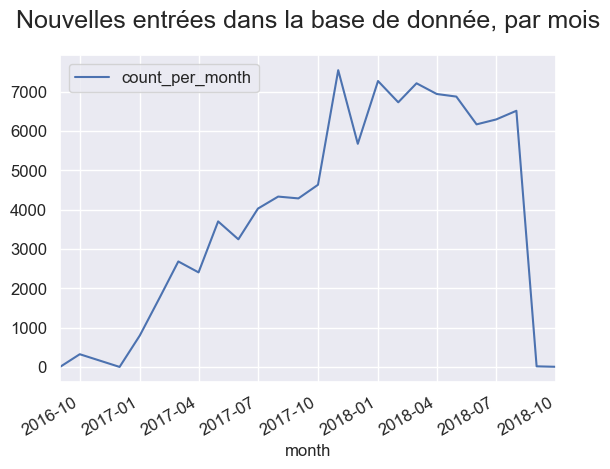

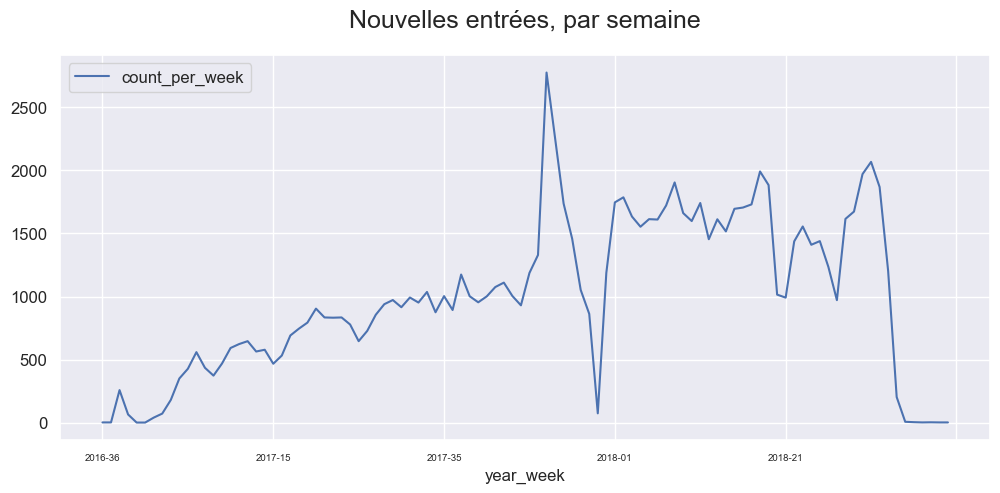

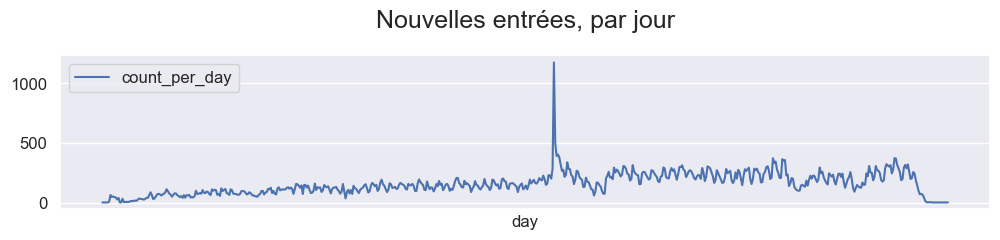

In [7]:
# Il s'est passé quoi Noel 2017 ?? 
# Panne / mise à jour des serveurs ?
# Effet "post-Noel ?" (On observe un effet similaire en 2016, mais moins de data donc dur à dire)

# avec des lignes, ça rend mieux ?

# par mois :
orders_df = raw_df_orders.copy()
orders_df['year_month'] = raw_df_orders['order_purchase_timestamp'].map(lambda dt: dt.strftime('%Y-%m'))
grouped_df_month = orders_df.groupby('year_month').size().to_frame("count_per_month").reset_index()

# Convert "year_month" to datetime
# So we can set xlim
# so the curve doesn't look like it's crashhing down towards the end !
grouped_df_month['month'] = pd.to_datetime(grouped_df_month['year_month'])

display(grouped_df_month.loc[grouped_df_month['month'] >= '2018-09', :])

grouped_df_month.plot(kind='line', x='month', y='count_per_month', fontsize=12)
plt.title('Nouvelles entrées dans la base de donnée, par mois', fontsize=18, pad=20)
plt.legend(loc='upper left', fontsize=12)
plt.xlim(grouped_df_month['month'].min(), grouped_df_month['month'].max())
plt.show()

# par semaine
# mon préféré, précis mais pas trop
orders_df['year_week'] = orders_df['order_purchase_timestamp'].map(lambda dt: dt.strftime('%Y-%U'))
grouped_week = orders_df.groupby('year_week').size().to_frame("count_per_week").reset_index()

fig, ax = plt.subplots(figsize=(12, 5)) 

grouped_week.plot(kind='line', x='year_week', y='count_per_week', fontsize=12, ax=ax)
plt.title('Nouvelles entrées, par semaine', fontsize=18, pad=20)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(fontsize=7)
plt.show()

# par jour
orders_df['day'] = orders_df['order_purchase_timestamp'].map(lambda dt: dt.strftime('%Y-%m-%d'))

grouped_day = orders_df.groupby('day').size().to_frame("count_per_day").reset_index()
grouped_day = grouped_day.sort_values('day')

fig1, ax1 = plt.subplots(figsize=(12, 2)) 

grouped_day.plot(kind='line', x='day', y='count_per_day', fontsize=12, ax=ax1)
plt.title('Nouvelles entrées, par jour', fontsize=18, pad=20)
plt.legend(loc='upper left', fontsize=12)
# Remove x-ticks, de ttes façons ici on verra rien 
plt.xticks([])
plt.show()


#### Dates : chute du nb de commandes en fin de période (sept - oct 2018)

In [8]:
# Il se passe un truc à ls fin qui va nous embêter plus tard
# si on ne s'en occupe pas

print(raw_df_orders.loc[raw_df_orders['order_purchase_timestamp'] >= '2018-09', :].shape)
display(raw_df_orders.loc[raw_df_orders['order_purchase_timestamp'] >= '2018-09', :])

# 20 transactions en 2 mois, c pour ça qu'on ne voit rien sur les graphs.
# sur le reste de la période, le nb de transactions moyen par semaine se compte par centaines,
# et par millier pour les autres mois. C'est bizarre, on ne pourra sans doute pas faire de prédictions
# après août.
# A voir si on n'a pas une situation similaire tt au début. (cf notebook 3 simulation)

df_orders_cut = raw_df_orders.loc[raw_df_orders['order_purchase_timestamp'] < '2018-09', 
                                  ['order_id', 'customer_id', 'order_purchase_timestamp']].copy()
quick_look(df_orders_cut)

# ici on va garder order_id, customer_id (clés), et la date d'achat (order_purchase_timestamp)


(20, 8)


order_id                       customer_id  \
1801   ed3efbd3a87bea76c2812c66a0b32219  191984a8ba4cbb2145acb4fe35b69664   
5149   ea844c92cf978ea23321fa7fe5871761  6ddc45ad08e6a2c885ca2255fc52d6df   
9976   87ae60ef8b08ae0e5f903cacb53a6904  fea4d57ed3a45455f89c25ef3dae8ee8   
16366  bd35b677fd239386e9861d11ae98ab56  ad2eb5d02c0808bcd8743117f6383cf6   
20778  4d59cc2a2e7bb6c0a851725f5888a9b5  ead83a4f8f7be8c3034b2e98754a6147   
24410  0d3adebce4bebc1f80a7f36e9833f497  a7c87c25dbdded68c26c640582cb5ddb   
31170  21a00b08cbeb5716bbb66105e3dbd850  002b5342c72978cf0aba6aae1f5d5293   
31891  a2ac6dad85cf8af5b0afb510a240fe8c  4c2ec60c29d10c34bd49cb88aa85cfc4   
33979  5aac76cf7b07dd06fa4d50bf461d2f40  7a8a02e54cf3472df427e927f8b9c046   
37003  869997fbe01f39d184956b5c6bccfdbe  55c9dad94ec1a2ba57998bdb376c230a   
39919  4637ca194b6387e2d538dc89b124b0ee  a73c1f73f5772cf801434bf984b0b1a7   
50387  392ed9afd714e3c74767d0c4d3e3f477  2823ffda607a2316375088e0d00005ec   
53501  afb61112fb99b07fe17e591c68c0c84c  36b182c39933d55e307096ccc3fd2970   
60938  10a045cdf6a5650c21e9cfeb60384c16  a4b417188addbc05b26b72d5e44837a1   
62360  54282e97f61c23b78330c15b154c867d  4b7decb9b58e2569548b8b4c8e20e8d7   
68373  b059ee4de278302d550a3035c4cdb740  856336203359aa6a61bf3826f7d84c49   
73341  cfdfd7862e532c4ec1ed1c6a1b56d320  0ab5ac09913dfd3f247c7929a3799799   
80019  1ad22e16129698e1a3cc11e4350d2cb7  d6441eef3f37c3edb0d5634c3c85120b   
88500  616fa7d4871b87832197b2a137a115d2  bf6181a85bbb4115736c0a8db1a53be3   
99347  a89abace0dcc01eeb267a9660b5ac126  2f0524a7b1b3845a1a57fcf3910c4333   

      order_status order_purchase_timestamp    order_approved_at  \
1801      canceled      2018-09-20 13:54:16                  NaN   
5149      canceled      2018-09-13 09:56:12                  NaN   
9976      canceled      2018-09-11 16:45:54                  NaN   
16366     canceled      2018-09-17 17:21:16                  NaN   
20778     canceled      2018-09-06 14:50:07                  NaN   
24410     canceled      2018-09-03 18:40:50                  NaN   
31170     canceled      2018-09-10 17:51:25                  NaN   
31891     canceled      2018-10-03 18:55:29                  NaN   
33979     canceled      2018-09-25 11:59:18                  NaN   
37003     canceled      2018-09-26 08:40:15                  NaN   
39919     canceled      2018-09-03 14:14:25                  NaN   
50387     canceled      2018-09-29 09:13:03                  NaN   
53501     canceled      2018-09-06 10:48:12                  NaN   
60938     canceled      2018-10-17 17:30:18                  NaN   
62360      shipped      2018-09-03 09:06:57  2018-09-03 17:40:06   
68373     canceled      2018-10-16 20:16:02                  NaN   
73341     canceled      2018-09-03 18:45:34                  NaN   
80019     canceled      2018-09-12 15:32:16                  NaN   
88500     canceled      2018-10-01 15:30:09                  NaN   
99347     canceled      2018-09-06 18:45:47                  NaN   

      order_delivered_carrier_date order_delivered_customer_date  \
1801                           NaN                           NaN   
5149                           NaN                           NaN   
9976                           NaN                           NaN   
16366                          NaN                           NaN   
20778                          NaN                           NaN   
24410                          NaN                           NaN   
31170                          NaN                           NaN   
31891                          NaN                           NaN   
33979                          NaN                           NaN   
37003                          NaN                           NaN   
39919                          NaN                           NaN   
50387                          NaN                           NaN   
53501                          NaN                           NaN   
60938                          N

shape : (99421, 3)


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_purchase_timestamp  
0      2017-10-02 10:56:33  
1      2018-07-24 20:41:37  
2      2018-08-08 08:38:49  
3      2017-11-18 19:28:06  
4      2018-02-13 21:18:39

order_id                       customer_id  \
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_purchase_timestamp  
99436      2017-03-09 09:54:05  
99437      2018-02-06 12:58:58  
99438      2017-08-27 14:46:43  
99439      2018-01-08 21:28:27  
99440      2018-03-08 20:57:30

uniques :


order_id                    99421
customer_id                 99421
order_purchase_timestamp    98855
dtype: int64

Doublons ?  0 



column_name  missing  present  \
order_id                                  order_id        0    99421   
customer_id                            customer_id        0    99421   
order_purchase_timestamp  order_purchase_timestamp        0    99421   

                          percent_missing            type  
order_id                              0.0          object  
customer_id                           0.0          object  
order_purchase_timestamp              0.0  datetime64[ns]

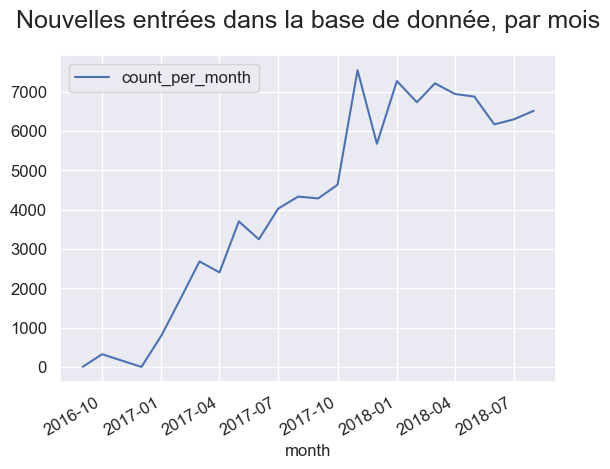

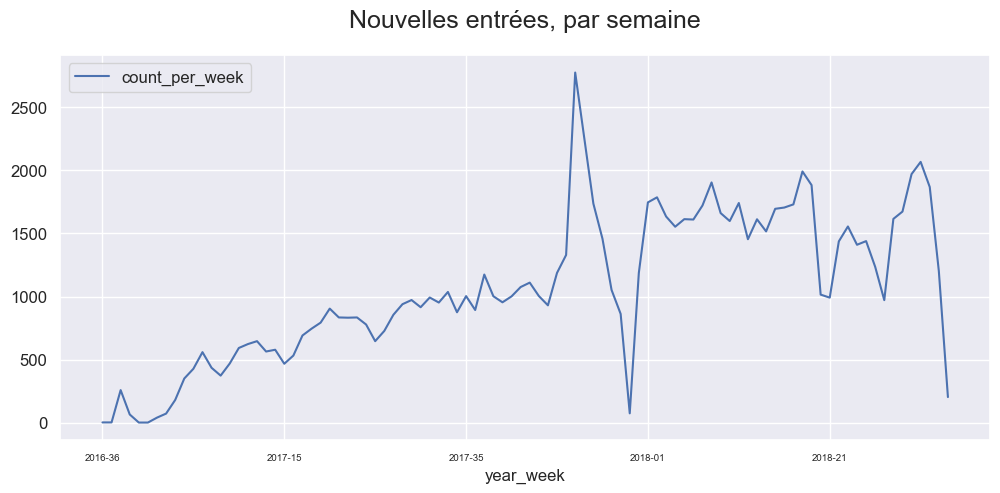

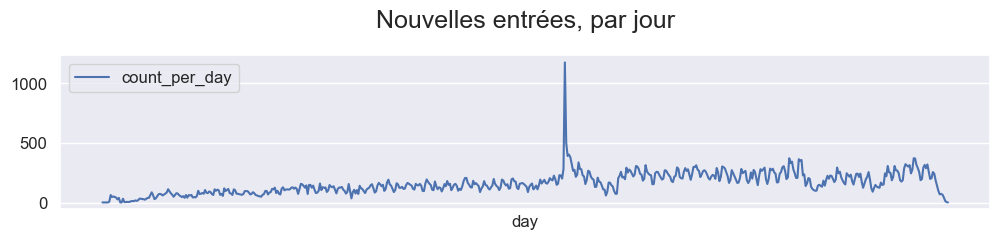

In [9]:
# Est-ce que c mieux ?

orders_df = df_orders_cut.copy()

# par mois :
# c mieux
orders_df['year_month'] = raw_df_orders['order_purchase_timestamp'].map(lambda dt: dt.strftime('%Y-%m'))
grouped_df_month = orders_df.groupby('year_month').size().to_frame("count_per_month").reset_index()
grouped_df_month['month'] = pd.to_datetime(grouped_df_month['year_month'])

grouped_df_month.plot(kind='line', x='month', y='count_per_month', fontsize=12)
plt.title('Nouvelles entrées dans la base de donnée, par mois', fontsize=18, pad=20)
plt.legend(loc='upper left', fontsize=12)
plt.show()

# par semaine
# chute tjs, besoin d'observer fin aout
# (les 2 années ?)
orders_df['year_week'] = orders_df['order_purchase_timestamp'].map(lambda dt: dt.strftime('%Y-%U'))
grouped_week = orders_df.groupby('year_week').size().to_frame("count_per_week").reset_index()

fig, ax = plt.subplots(figsize=(12, 5))  

grouped_week.plot(kind='line', x='year_week', y='count_per_week', fontsize=12, ax=ax)
plt.title('Nouvelles entrées, par semaine', fontsize=18, pad=20)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(fontsize=7)
plt.show()

# par jour
orders_df['day'] = orders_df['order_purchase_timestamp'].map(lambda dt: dt.strftime('%Y-%m-%d'))

grouped_day = orders_df.groupby('day').size().to_frame("count_per_day").reset_index()
grouped_day = grouped_day.sort_values('day')

fig1, ax1 = plt.subplots(figsize=(12, 2))  

grouped_day.plot(kind='line', x='day', y='count_per_day', fontsize=12, ax=ax1)
plt.title('Nouvelles entrées, par jour', fontsize=18, pad=20)
plt.legend(loc='upper left', fontsize=12)
# Remove x-ticks, de ttes façons ici on verra rien 
plt.xticks([])
plt.show()


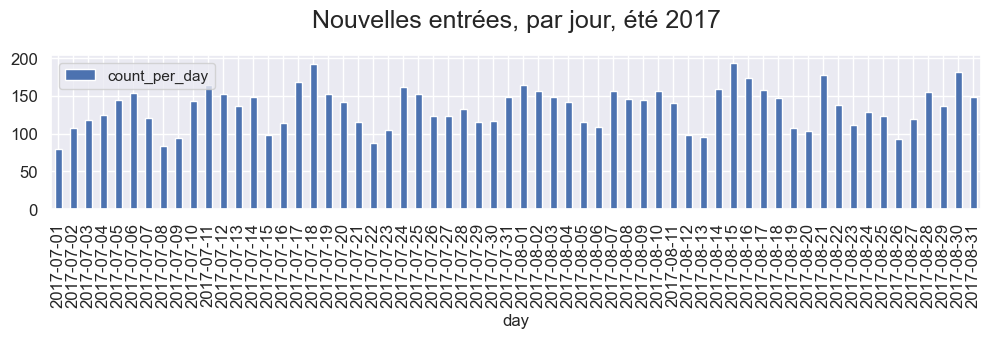

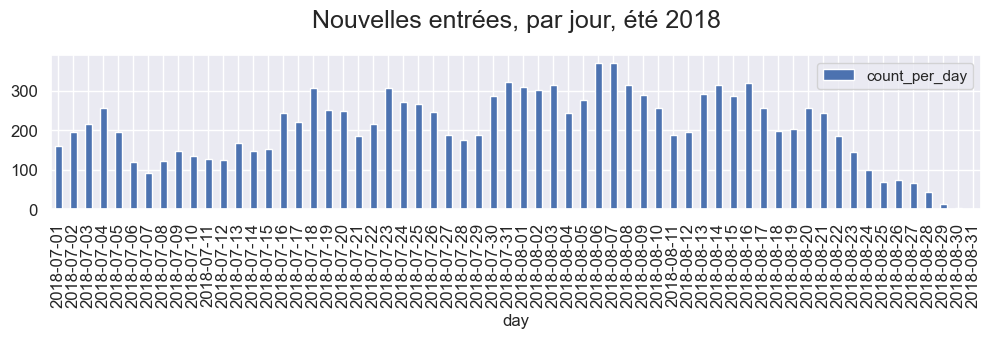

In [10]:
# juillet aout

summer_2017 = orders_df.loc[(orders_df['year_month'] == '2017-07')
                            | (orders_df['year_month'] == '2017-08'), :].copy()

summer_2018 = orders_df.loc[(orders_df['year_month'] == '2018-07')
                            | (orders_df['year_month'] == '2018-08'), :].copy()

# par jour
# 2017
summer_2017['day'] = summer_2017['order_purchase_timestamp'].map(lambda dt: dt.strftime('%Y-%m-%d'))

grouped_summer_2017 = summer_2017.groupby('day').size().to_frame("count_per_day").reset_index()
grouped_summer_2017 = grouped_summer_2017.sort_values('day')

fig, ax = plt.subplots(figsize=(12, 2))  

grouped_summer_2017.plot(kind='bar', x='day', y='count_per_day', fontsize=12, ax=ax)
plt.title('Nouvelles entrées, par jour, été 2017', fontsize=18, pad=20)
# plt.legend(loc='upper left', fontsize=12)
# plt.xticks([])
plt.show()

# 2018
summer_2018['day'] = summer_2018['order_purchase_timestamp'].map(lambda dt: dt.strftime('%Y-%m-%d'))

grouped_summer_2018 = summer_2018.groupby('day').size().to_frame("count_per_day").reset_index()
grouped_summer_2018 = grouped_summer_2018.sort_values('day')

fig1, ax1 = plt.subplots(figsize=(12, 2))  

grouped_summer_2018.plot(kind='bar', x='day', y='count_per_day', fontsize=12, ax=ax1)
plt.title('Nouvelles entrées, par jour, été 2018', fontsize=18, pad=20)
# plt.legend(loc='upper left', fontsize=12)
# plt.xticks([])
plt.show()


In [11]:
# Oui truc bizarre on va dire derniere semaine d'aout en gros
# ça commence à s'effondrer.

# Les modèles vont pouvoir prédire ça ??
# Garder un peu moins ?

# Vérifier aussi début de période (voir notebook 3)


### geo

In [12]:
raw_df_geo = pd.read_csv('data/archive/olist_geolocation_dataset.csv', sep=',')

print('Geolocation_dataset :', '\n')
quick_look(raw_df_geo)

# Yes, des maps !! I love maps

# Pas hyper utile ici malheureusement..
# Permet juste de préciser les coordonnées de chaque zipcode possible.
# Remarque : pourrait être utile pour identifier / cibler les zones où concentrer les efforts marketing,
# mais pas notre objectif.
# En plus on a déjà la ville et le pays dans le datase customers, ça nous suffit largemment.

# + de 1 000 000 lignes !

print(raw_df_geo[raw_df_geo.duplicated(keep=False)].shape)
print(raw_df_geo[raw_df_geo.duplicated(keep='first')].shape)

# dont environ 260 000 doublons, les premiers que nous rencontrons.
# On n'aime pas trop les doublons, par ici !


Geolocation_dataset : 

shape : (1000163, 5)


geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
1000158                        99950       -28.068639       -52.010705   
1000159                        99900       -27.877125       -52.224882   
1000160                        99950       -28.071855       -52.014716   
1000161                        99980       -28.388932       -51.846871   
1000162                        99950       -28.070104       -52.018658   

        geolocation_city geolocation_state  
1000158         tapejara                RS  
1000159   getulio vargas                RS  
1000160         tapejara                RS  
1000161  david canabarro                RS  
1000162         tapejara                RS

uniques :


geolocation_zip_code_prefix     19015
geolocation_lat                717360
geolocation_lng                717613
geolocation_city                 8011
geolocation_state                  27
dtype: int64

Doublons ?  261831 



column_name  missing  present  \
geolocation_zip_code_prefix  geolocation_zip_code_prefix        0  1000163   
geolocation_lat                          geolocation_lat        0  1000163   
geolocation_lng                          geolocation_lng        0  1000163   
geolocation_city                        geolocation_city        0  1000163   
geolocation_state                      geolocation_state        0  1000163   

                             percent_missing     type  
geolocation_zip_code_prefix              0.0    int64  
geolocation_lat                          0.0  float64  
geolocation_lng                          0.0  float64  
geolocation_city                         0.0   object  
geolocation_state                        0.0   object

(390005, 5)
(261831, 5)


In [13]:
df_geo = raw_df_geo.drop_duplicates().copy()
df_geo = df_geo.rename(columns={'geolocation_zip_code_prefix': 'zipcode'})

print(df_geo.shape)
# OK

quick_look(df_geo)


(738332, 5)
shape : (738332, 5)


zipcode  geolocation_lat  geolocation_lng geolocation_city  \
0     1037       -23.545621       -46.639292        sao paulo   
1     1046       -23.546081       -46.644820        sao paulo   
2     1046       -23.546129       -46.642951        sao paulo   
3     1041       -23.544392       -46.639499        sao paulo   
4     1035       -23.541578       -46.641607        sao paulo   

  geolocation_state  
0                SP  
1                SP  
2                SP  
3                SP  
4                SP

zipcode  geolocation_lat  geolocation_lng geolocation_city  \
1000155    99965       -28.180655       -52.034367       agua santa   
1000156    99950       -28.072188       -52.011272         tapejara   
1000157    99950       -28.068864       -52.012964         tapejara   
1000158    99950       -28.068639       -52.010705         tapejara   
1000161    99980       -28.388932       -51.846871  david canabarro   

        geolocation_state  
1000155                RS  
1000156                RS  
1000157                RS  
1000158                RS  
1000161                RS

uniques :


zipcode               19015
geolocation_lat      717360
geolocation_lng      717613
geolocation_city       8011
geolocation_state        27
dtype: int64

Doublons ?  0 



column_name  missing  present  percent_missing  \
zipcode                      zipcode        0   738332              0.0   
geolocation_lat      geolocation_lat        0   738332              0.0   
geolocation_lng      geolocation_lng        0   738332              0.0   
geolocation_city    geolocation_city        0   738332              0.0   
geolocation_state  geolocation_state        0   738332              0.0   

                      type  
zipcode              int64  
geolocation_lat    float64  
geolocation_lng    float64  
geolocation_city    object  
geolocation_state   object

In [14]:
# On a encore + de 700 000 doublons sur zipcode !
display(df_geo[df_geo['zipcode'].duplicated(keep=False)].sort_values(by='zipcode').head(60))


zipcode  geolocation_lat  geolocation_lng geolocation_city  \
851      1001       -23.549825       -46.633970        sao paulo   
326      1001       -23.551427       -46.634074        sao paulo   
299      1001       -23.549698       -46.633909        sao paulo   
235      1001       -23.550642       -46.634410        sao paulo   
519      1001       -23.551337       -46.634027        sao paulo   
206      1001       -23.550498       -46.634338        sao paulo   
1182     1001       -23.549779       -46.633957        sao paulo   
575      1001       -23.549779       -46.633957        são paulo   
99       1001       -23.549292       -46.633559        sao paulo   
608      1001       -23.550263       -46.634196        são paulo   
1351     1001       -23.549951       -46.634027        são paulo   
73       1002       -23.548318       -46.635421        sao paulo   
720      1002       -23.548878       -46.634004        sao paulo   
214      1002       -23.547417       -46.636361        sao paulo   
1251     1002       -23.544641       -46.633180        são paulo   
516      1002       -23.548137       -46.635905        sao paulo   
514      1002       -23.548551       -46.635072        sao paulo   
725      1003       -23.548958       -46.634862        sao paulo   
309      1003       -23.548960       -46.636172        sao paulo   
1046     1003       -23.548977       -46.635740        sao paulo   
478      1003       -23.549083       -46.634864        são paulo   
500      1003       -23.548976       -46.635322        sao paulo   
90       1003       -23.549032       -46.635313        sao paulo   
799      1003       -23.549083       -46.634864        sao paulo   
179      1003       -23.548901       -46.637157        sao paulo   
184      1003       -23.549044       -46.635183        sao paulo   
1271     1003       -23.549043       -46.635133        sao paulo   
853      1003       -23.548940       -46.636788        sao paulo   
1102     1004       -23.549565       -46.634439        sao paulo   
978      1004       -23.549637       -46.634057        sao paulo   
242      1004       -23.550116       -46.635122        sao paulo   
278      1004       -23.549513       -46.634719        sao paulo   
1052     1004       -23.549507       -46.634428        são paulo   
998      1004       -23.550202       -46.635221        sao paulo   
487      1004       -23.549535       -46.634307        sao paulo   
804      1004       -23.549497       -46.634468        sao paulo   
549      1004       -23.550467       -46.635233        sao paulo   
1257     1004       -23.550699       -46.635371        sao paulo   
507      1004       -23.549181       -46.634822        sao paulo   
457      1004       -23.549394       -46.634951        sao paulo   
443      1004       -23.550765       -46.635323        sao paulo   
1448     1004       -23.549530       -46.634628        sao paulo   
967      1005       -23.549980       -46.634768        sao paulo   
1164     1005       -23.549780       -46.635359        sao paulo   
451      1005       -23.549612       -46.636532        sao paulo   
937      1005       -23.549690       -46.636719        sao paulo   
584      1005       -23.549980       -46.634768        são paulo   
30       1005       -23.549819       -46.635606        sao paulo   
185      1005       -23.549471       -46.637404        sao paulo   
193      1005       -23.548758       -46.638411        sao paulo   
398      1005       -23.549770       -46.635839        sao paulo   
1278     1005       -23.549763       -46.636100        sao paulo   
933      1005       -23.548779       -46.638303        sao paulo   
1213     1005       -23.549780       -46.635359        são paulo   
1049     1005       -23.548933       -46.638112        sao paulo   
347      1006       -23.549099       -46.635841        sao paulo   
205      1006       -23.550259       -46.636360        sao paulo   
367      1006       -23.550696       -46.634885        sao pau

In [15]:
# Ah zut, je comprends mieux !
# That's why they mention the zipcode column only contains the beginning 
# It only allows us to locate a client (/seller) approximatively
# Du coup en l'état c pas vraiment une clé.

# Je pense qu'on peut approximer la geoloc des clients à leur quartier.
# Bon compromis pour avoir qd même de quoi tester + tard (partie 2 ?)
# si certains de nos clusters ont une dimension géo
# (par exemple est-ce qu'il y a des différences de comportement selon les zones, pays, etc... ?)
# Note du futur : piste non explorée au final

df_geo = df_geo.groupby('zipcode').agg({
    'geolocation_lat': 'mean',  # Rename 
    'geolocation_lng': 'mean',  
    'geolocation_city': 'first',  
    'geolocation_state': 'first',  
}).reset_index()

df_geo = df_geo.rename(columns={'geolocation_lat': 'latitude',
                                'geolocation_lng': 'longitude'})

quick_look(df_geo)


shape : (19015, 5)


zipcode   latitude  longitude geolocation_city geolocation_state
0     1001 -23.550227 -46.634039        sao paulo                SP
1     1002 -23.547657 -46.634991        sao paulo                SP
2     1003 -23.549000 -46.635582        sao paulo                SP
3     1004 -23.549829 -46.634792        sao paulo                SP
4     1005 -23.549547 -46.636406        sao paulo                SP

zipcode   latitude  longitude geolocation_city geolocation_state
19010    99960 -27.953722 -52.025511          charrua                RS
19011    99965 -28.183372 -52.039850       agua santa                RS
19012    99970 -28.343920 -51.874988          ciriaco                RS
19013    99980 -28.389500 -51.843122  david canabarro                RS
19014    99990 -28.329595 -51.769362        muliterno                RS

uniques :


zipcode              19015
latitude             19001
longitude            19001
geolocation_city      5955
geolocation_state       27
dtype: int64

Doublons ?  0 



column_name  missing  present  percent_missing  \
zipcode                      zipcode        0    19015              0.0   
latitude                    latitude        0    19015              0.0   
longitude                  longitude        0    19015              0.0   
geolocation_city    geolocation_city        0    19015              0.0   
geolocation_state  geolocation_state        0    19015              0.0   

                      type  
zipcode              int64  
latitude           float64  
longitude          float64  
geolocation_city    object  
geolocation_state   object

#### distorted map

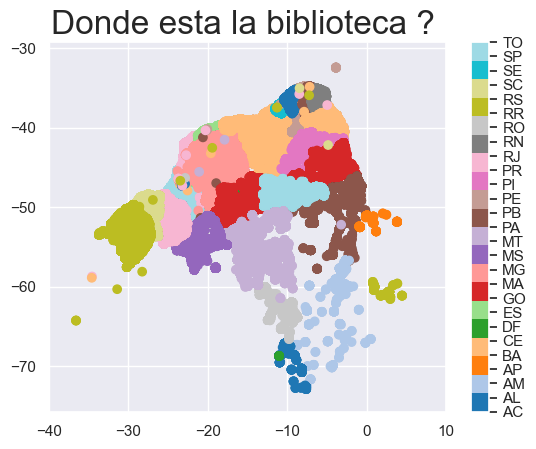

In [16]:
# Assuming 'geolocation_state' is a categorical variable
neighborhood_colors = raw_df_geo['geolocation_state'].astype('category')
neighborhood_labels = neighborhood_colors.cat.categories
neighborhood_codes = neighborhood_colors.cat.codes

# Set a custom colormap (e.g., 'viridis')
custom_cmap = 'tab20'

plt.scatter(raw_df_geo['geolocation_lat'], raw_df_geo['geolocation_lng'], c=neighborhood_codes, cmap=custom_cmap)

# Set equal aspect ratio to maintain real proportions
plt.axis('equal')

# Create a custom colorbar with labels
cbar = plt.colorbar(ticks=range(len(neighborhood_labels)))
cbar.set_ticklabels(neighborhood_labels)

plt.xlim(-40, 10)
plt.ylim(-75, -30)
plt.title("Donde esta la biblioteca ? ", fontsize=24)   
plt.show()


#### Attention les yeux !

In [17]:
# Create a 3D scatter plot with Earth coordinates
earth = go.Scattergeo(
    lon=raw_df_geo['geolocation_lng'].iloc[::20],
    lat=raw_df_geo['geolocation_lat'].iloc[::20],
    mode='markers',
    marker=dict(size=3, color='red')
)

# Create a layout with a 3D scene
layout = go.Layout(
    geo=dict(
        showland=True,
        showocean=True,
        showcoastlines=True,
        projection_type='orthographic',
        landcolor='rgb(200, 200, 200)',
        oceancolor='rgb(0, 0, 255)',
        bgcolor='black',
        projection_rotation=dict(lon=-60, lat=-15)  # Rotate the Earth view
    )
)

# Create a figure that combines the Earth plot and the layout
fig = go.Figure(data=[earth], layout=layout)

# go figure...

fig.update_layout(
    title={
        'text': "Is this Nicaragua ?",
        'x': 0.1,
        'xanchor': 'left',
        'y': 0.9,
        'yanchor': 'top',
        'font': {
            'size': 17,
            'color': 'silver'
        }
    },
    annotations=[
        dict(
            text="No, esta es la casa d'El Gringo",
            x=1.1,
            xref="paper",
            y=-0.1,
            yref="paper",
            showarrow=False,
            font=dict(size=17, color='silver'),
        )
    ],
    height=600,
    width=800,
    paper_bgcolor='black'
)
# Display the 3D Earth plot
fig.show()


### order_items

In [18]:
raw_df_order_items = pd.read_csv('data/archive/olist_order_items_dataset.csv', sep=',')

print('Order_items_dataset :', '\n')
quick_look(raw_df_order_items)

# Il y a environ 800 commandes dont on n'a pas le détail.

# shape 0 = 112 650 detail des commandes
# pour 98 666 id

# on a l'id commande, 
# un order_item_id (21 uniques. c quoi ??),
# -> c le nb d'articles / commande
# id produit, vendeur, date limite expedition, prix, frais d'envoi.

# c quoi order_item_id exactement ? 
# surement important car PRIX 
# OK. Comme son nom l'indique en fait.

print(raw_df_order_items['order_item_id'].unique())

display(raw_df_order_items.describe())

# Le prix moyen est de 120 qqch.
# Ca fait cher !
# Ou pas. Aucune idée connais pas la monnaie.

# 22-23 euros apparement.


Order_items_dataset : 

shape : (112650, 7)


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

order_id  order_item_id  \
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  
112645  2018-05-02 04:11:01  299.99          43.41  
112646  2018-07-20 04:31:48  350.00          36.53  
112647  2017-10-30 17:14:25   99.90          16.95  
112648  2017-08-21 00:04:32   55.99           8.72  
112649  2018-06-12 17:10:13   43.00          12.79

uniques :


order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

Doublons ?  0 



column_name  missing  present  percent_missing  \
order_id                        order_id        0   112650              0.0   
order_item_id              order_item_id        0   112650              0.0   
product_id                    product_id        0   112650              0.0   
seller_id                      seller_id        0   112650              0.0   
shipping_limit_date  shipping_limit_date        0   112650              0.0   
price                              price        0   112650              0.0   
freight_value              freight_value        0   112650              0.0   

                        type  
order_id              object  
order_item_id          int64  
product_id            object  
seller_id             object  
shipping_limit_date   object  
price                float64  
freight_value        float64

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


order_item_id          price  freight_value
count  112650.000000  112650.000000  112650.000000
mean        1.197834     120.653739      19.990320
std         0.705124     183.633928      15.806405
min         1.000000       0.850000       0.000000
25%         1.000000      39.900000      13.080000
50%         1.000000      74.990000      16.260000
75%         1.000000     134.900000      21.150000
max        21.000000    6735.000000     409.680000

In [19]:
# Observons par commande :

display(raw_df_order_items[raw_df_order_items['order_id'].duplicated(keep=False)].sort_values(by='order_id').head(60))

# Ici on a donc le prix de la commande, au détail. 
# Il faudra calculer le prix total avec sum()
# ou le retrouver dans la table payment

# Pas sûr qu'on ait besoin de product_id, mais ça peut être utile si on a besoin de regarder
# ce que les clients achètent.

# le vendeur et la date d'envoi, on drop

df_order_items = raw_df_order_items.drop(['seller_id', 'shipping_limit_date'], axis=1).copy()
print(df_order_items.shape)


order_id  order_item_id  \
13   0008288aa423d2a3f00fcb17cd7d8719              1   
14   0008288aa423d2a3f00fcb17cd7d8719              2   
32   00143d0f86d6fbd9f9b38ab440ac16f5              1   
33   00143d0f86d6fbd9f9b38ab440ac16f5              2   
34   00143d0f86d6fbd9f9b38ab440ac16f5              3   
42   001ab0a7578dd66cd4b0a71f5b6e1e41              1   
43   001ab0a7578dd66cd4b0a71f5b6e1e41              2   
44   001ab0a7578dd66cd4b0a71f5b6e1e41              3   
49   001d8f0e34a38c37f7dba2a37d4eba8b              2   
48   001d8f0e34a38c37f7dba2a37d4eba8b              1   
75   002c9def9c9b951b1bec6d50753c9891              1   
76   002c9def9c9b951b1bec6d50753c9891              2   
80   002f98c0f7efd42638ed6100ca699b42              1   
81   002f98c0f7efd42638ed6100ca699b42              2   
87   003324c70b19a16798817b2b3640e721              1   
88   003324c70b19a16798817b2b3640e721              2   
91   00337fe25a3780b3424d9ad7c5a4b35e              1   
92   00337fe25a3780b3424d9ad7c5a4b35e              2   
101  003822434f91204da0a51fe4cf2aba18              1   
102  003822434f91204da0a51fe4cf2aba18              2   
112  003f201cdd39cdd59b6447cff2195456              2   
111  003f201cdd39cdd59b6447cff2195456              1   
135  005059edee63c8c708ba61910793b31b              1   
136  005059edee63c8c708ba61910793b31b              2   
137  00526a9d4ebde463baee25f386963ddc              1   
138  00526a9d4ebde463baee25f386963ddc              2   
139  00526a9d4ebde463baee25f386963ddc              3   
140  00526a9d4ebde463baee25f386963ddc              4   
143  00571ded73b3c061925584feab0db425              1   
144  00571ded73b3c061925584feab0db425              2   
153  005d9a5423d47281ac463a968b3936fb              3   
151  005d9a5423d47281ac463a968b3936fb              1   
152  005d9a5423d47281ac463a968b3936fb              2   
166  0068c109948b9a1dfb8530d1978acef3              1   
167  0068c109948b9a1dfb8530d1978acef3              2   
209  008d9bf350ff02ed444b3452cf3f57e0              1   
210  008d9bf350ff02ed444b3452cf3f57e0              2   
219  00946f674d880be1f188abc10ad7cf46              1   
220  00946f674d880be1f188abc10ad7cf46              2   
230  0097f0545a302aafa32782f1734ff71c              1   
231  0097f0545a302aafa32782f1734ff71c              2   
235  009905140e9f8cc35d5be897937381db              2   
234  009905140e9f8cc35d5be897937381db              1   
254  00a57dfbb049fbaae10763e2cf15f797              3   
253  00a57dfbb049fbaae10763e2cf15f797              2   
252  00a57dfbb049fbaae10763e2cf15f797              1   
274  00b1861aeb89afa498404c684148a619              1   
275  00b1861aeb89afa498404c684148a619              2   
287  00b6e66f005a657a6b13eedcacdf9342              1   
288  00b6e66f005a657a6b13eedcacdf9342              2   
296  00bcee890eba57a9767c7b5ca12d3a1b              1   
297  00bcee890eba57a9767c7b5ca12d3a1b              2   
298  00bcee890eba57a9767c7b5ca12d3a1b              3   
299  00bcee890eba57a9767c7b5ca12d3a1b              4   
308  00c00d5b36157595e21108ba1da2828f              2   
307  00c00d5b36157595e21108ba1da2828f              1   
326  00c9f7d4b0e87781465e562dc109f6aa              1   
327  00c9f7d4b0e87781465e562dc109f6aa              2   
328  00c9f7d4b0e87781465e562dc109f6aa              3   
329  00c9f7d4b0e87781465e562dc109f6aa              4   

                           product_id                         seller_id  \
13   368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   
14   368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   
32   e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   
33   e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   
34   e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   
42   0b0172eb0fd18479d29c3bc122c058c2  5656537e588803a555b8eb41f07a944b   
43   0b0172eb0fd18479d29c3bc122c058c2  5656537e588803a555b8eb41f07a944b   
44   0b0172e

(112650, 5)


### order_payments

In [20]:
raw_df_order_payments = pd.read_csv('data/archive/olist_order_payments_dataset.csv', sep=',')

print('Order_payments_dataset :', '\n')
quick_look(raw_df_order_payments)

# shape 0 = 103 886 ??
# pour 99 440 id 
# (99 441 = nb commandes. il y a un rapport ?)

# 5 features. IMPORTANT. MONEY
# Encore que ? 

print(raw_df_order_payments['payment_sequential'].unique())
# 1-20
print(raw_df_order_payments['payment_type'].unique())
# 5
print(raw_df_order_payments['payment_installments'].unique())
# sur 2 ans max (24 mois)

display(raw_df_order_payments.describe())

# Le paiement moyen est de 154 qqch. ( > 120 + 20 (prix moyen cell precedente + transport moyen))


Order_payments_dataset : 

shape : (103886, 5)


order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

order_id  payment_sequential payment_type  \
103881  0406037ad97740d563a178ecc7a2075c                   1       boleto   
103882  7b905861d7c825891d6347454ea7863f                   1  credit_card   
103883  32609bbb3dd69b3c066a6860554a77bf                   1  credit_card   
103884  b8b61059626efa996a60be9bb9320e10                   1  credit_card   
103885  28bbae6599b09d39ca406b747b6632b1                   1       boleto   

        payment_installments  payment_value  
103881                     1         363.31  
103882                     2          96.80  
103883                     1          47.77  
103884                     5         369.54  
103885                     1         191.58

uniques :


order_id                99440
payment_sequential         29
payment_type                5
payment_installments       24
payment_value           29077
dtype: int64

Doublons ?  0 



column_name  missing  present  percent_missing  \
order_id                          order_id        0   103886              0.0   
payment_sequential      payment_sequential        0   103886              0.0   
payment_type                  payment_type        0   103886              0.0   
payment_installments  payment_installments        0   103886              0.0   
payment_value                payment_value        0   103886              0.0   

                         type  
order_id               object  
payment_sequential      int64  
payment_type           object  
payment_installments    int64  
payment_value         float64

[ 1  2  4  5  3  8  6  7 10 11 17 19 27 12  9 15 13 14 16 25 22 26 29 28
 18 21 24 23 20]
['credit_card' 'boleto' 'voucher' 'debit_card' 'not_defined']
[ 8  1  2  3  6  5  4 10  7 12  9 13 15 24 11 18 14 20 21 17 22  0 16 23]


payment_sequential  payment_installments  payment_value
count       103886.000000         103886.000000  103886.000000
mean             1.092679              2.853349     154.100380
std              0.706584              2.687051     217.494064
min              1.000000              0.000000       0.000000
25%              1.000000              1.000000      56.790000
50%              1.000000              1.000000     100.000000
75%              1.000000              4.000000     171.837500
max             29.000000             24.000000   13664.080000

In [21]:
# On a besoin que 'order_id' soit une clé

prefered_payment = raw_df_order_payments.copy()

print(prefered_payment[prefered_payment['order_id'].duplicated(keep=False)].shape)
display(prefered_payment[prefered_payment['order_id'].duplicated(keep=False)].sort_values(by='order_id'))

quick_look(prefered_payment)

print(prefered_payment.dtypes)


(7407, 5)


order_id  payment_sequential payment_type  \
80856  0016dfedd97fc2950e388d2971d718c7                   2      voucher   
89575  0016dfedd97fc2950e388d2971d718c7                   1  credit_card   
20036  002f19a65a2ddd70a090297872e6d64e                   1      voucher   
98894  002f19a65a2ddd70a090297872e6d64e                   2      voucher   
30155  0071ee2429bc1efdc43aa3e073a5290e                   2      voucher   
...                                 ...                 ...          ...   
21648  ffa1dd97810de91a03abd7bd76d2fed1                   2      voucher   
32912  ffa39020fe7c8a3e907320e1bec4b985                   1  credit_card   
3009   ffa39020fe7c8a3e907320e1bec4b985                   2      voucher   
75188  ffc730a0615d28ec19f9cad02cb41442                   1  credit_card   
28537  ffc730a0615d28ec19f9cad02cb41442                   2  credit_card   

       payment_installments  payment_value  
80856                     1          17.92  
89575                     5          52.63  
20036                     1          44.11  
98894                     1          33.18  
30155                     1          92.44  
...                     ...            ...  
21648                     1         418.73  
32912                     1           7.13  
3009                      1          64.01  
75188                     1          14.76  
28537                     1          12.63  

[7407 rows x 5 columns]

shape : (103886, 5)


order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

order_id  payment_sequential payment_type  \
103881  0406037ad97740d563a178ecc7a2075c                   1       boleto   
103882  7b905861d7c825891d6347454ea7863f                   1  credit_card   
103883  32609bbb3dd69b3c066a6860554a77bf                   1  credit_card   
103884  b8b61059626efa996a60be9bb9320e10                   1  credit_card   
103885  28bbae6599b09d39ca406b747b6632b1                   1       boleto   

        payment_installments  payment_value  
103881                     1         363.31  
103882                     2          96.80  
103883                     1          47.77  
103884                     5         369.54  
103885                     1         191.58

uniques :


order_id                99440
payment_sequential         29
payment_type                5
payment_installments       24
payment_value           29077
dtype: int64

Doublons ?  0 



column_name  missing  present  percent_missing  \
order_id                          order_id        0   103886              0.0   
payment_sequential      payment_sequential        0   103886              0.0   
payment_type                  payment_type        0   103886              0.0   
payment_installments  payment_installments        0   103886              0.0   
payment_value                payment_value        0   103886              0.0   

                         type  
order_id               object  
payment_sequential      int64  
payment_type           object  
payment_installments    int64  
payment_value         float64

order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object


In [22]:
# Si on veut garder les moyens de paiement (5 types possibles), le mieux est de créer 5 variables

prefered_payment['payment_total'] = 0.0

for type in prefered_payment['payment_type'].unique():
    prefered_payment['payment_type_' + str(type)] = 0.0
    prefered_payment.loc[prefered_payment['payment_type'] == type, 'payment_type_' + str(type)] = prefered_payment.loc[prefered_payment['payment_type'] == type, 'payment_value']
    prefered_payment['payment_total'] += prefered_payment['payment_type_' + str(type)]

quick_look(prefered_payment)
# seems OK

payment_df = prefered_payment.drop(['payment_sequential', 'payment_type', 'payment_value'], axis=1).copy()
grouped_payment_df = payment_df.groupby('order_id').sum().reset_index()

quick_look(grouped_payment_df)
# Ok, shape[0] == 'order_id'.nunique
# On a notre clé.


shape : (103886, 11)


order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  payment_total  \
0                     8          99.33          99.33   
1                     1          24.39          24.39   
2                     1          65.71          65.71   
3                     8         107.78         107.78   
4                     2         128.45         128.45   

   payment_type_credit_card  payment_type_boleto  payment_type_voucher  \
0                     99.33                  0.0                   0.0   
1                     24.39                  0.0                   0.0   
2                     65.71                  0.0                   0.0   
3                    107.78                  0.0                   0.0   
4                    128.45                  0.0                   0.0   

   payment_type_debit_card  payment_type_not_defined  
0                      0.0                       0.0  
1                      0.0                       0.0  
2                      0.0                       0.0  
3                      0.0                       0.0  
4                      0.0                       0.0

order_id  payment_sequential payment_type  \
103881  0406037ad97740d563a178ecc7a2075c                   1       boleto   
103882  7b905861d7c825891d6347454ea7863f                   1  credit_card   
103883  32609bbb3dd69b3c066a6860554a77bf                   1  credit_card   
103884  b8b61059626efa996a60be9bb9320e10                   1  credit_card   
103885  28bbae6599b09d39ca406b747b6632b1                   1       boleto   

        payment_installments  payment_value  payment_total  \
103881                     1         363.31         363.31   
103882                     2          96.80          96.80   
103883                     1          47.77          47.77   
103884                     5         369.54         369.54   
103885                     1         191.58         191.58   

        payment_type_credit_card  payment_type_boleto  payment_type_voucher  \
103881                      0.00               363.31                   0.0   
103882                     96.80                 0.00                   0.0   
103883                     47.77                 0.00                   0.0   
103884                    369.54                 0.00                   0.0   
103885                      0.00               191.58                   0.0   

        payment_type_debit_card  payment_type_not_defined  
103881                      0.0                       0.0  
103882                      0.0                       0.0  
103883                      0.0                       0.0  
103884                      0.0                       0.0  
103885                      0.0                       0.0

uniques :


order_id                    99440
payment_sequential             29
payment_type                    5
payment_installments           24
payment_value               29077
payment_total               29077
payment_type_credit_card    25500
payment_type_boleto         10542
payment_type_voucher         3539
payment_type_debit_card      1384
payment_type_not_defined        1
dtype: int64

Doublons ?  0 



column_name  missing  present  \
order_id                                  order_id        0   103886   
payment_sequential              payment_sequential        0   103886   
payment_type                          payment_type        0   103886   
payment_installments          payment_installments        0   103886   
payment_value                        payment_value        0   103886   
payment_total                        payment_total        0   103886   
payment_type_credit_card  payment_type_credit_card        0   103886   
payment_type_boleto            payment_type_boleto        0   103886   
payment_type_voucher          payment_type_voucher        0   103886   
payment_type_debit_card    payment_type_debit_card        0   103886   
payment_type_not_defined  payment_type_not_defined        0   103886   

                          percent_missing     type  
order_id                              0.0   object  
payment_sequential                    0.0    int64  
payment_type                          0.0   object  
payment_installments                  0.0    int64  
payment_value                         0.0  float64  
payment_total                         0.0  float64  
payment_type_credit_card              0.0  float64  
payment_type_boleto                   0.0  float64  
payment_type_voucher                  0.0  float64  
payment_type_debit_card               0.0  float64  
payment_type_not_defined              0.0  float64

shape : (99440, 8)


order_id  payment_installments  payment_total  \
0  00010242fe8c5a6d1ba2dd792cb16214                     2          72.19   
1  00018f77f2f0320c557190d7a144bdd3                     3         259.83   
2  000229ec398224ef6ca0657da4fc703e                     5         216.87   
3  00024acbcdf0a6daa1e931b038114c75                     2          25.78   
4  00042b26cf59d7ce69dfabb4e55b4fd9                     3         218.04   

   payment_type_credit_card  payment_type_boleto  payment_type_voucher  \
0                     72.19                  0.0                   0.0   
1                    259.83                  0.0                   0.0   
2                    216.87                  0.0                   0.0   
3                     25.78                  0.0                   0.0   
4                    218.04                  0.0                   0.0   

   payment_type_debit_card  payment_type_not_defined  
0                      0.0                       0.0  
1                      0.0                       0.0  
2                      0.0                       0.0  
3                      0.0                       0.0  
4                      0.0                       0.0

order_id  payment_installments  payment_total  \
99435  fffc94f6ce00a00581880bf54a75a037                     1         343.40   
99436  fffcd46ef2263f404302a634eb57f7eb                     1         386.53   
99437  fffce4705a9662cd70adb13d4a31832d                     3         116.85   
99438  fffe18544ffabc95dfada21779c9644f                     3          64.71   
99439  fffe41c64501cc87c801fd61db3f6244                     1          55.79   

       payment_type_credit_card  payment_type_boleto  payment_type_voucher  \
99435                      0.00               343.40                   0.0   
99436                      0.00               386.53                   0.0   
99437                    116.85                 0.00                   0.0   
99438                     64.71                 0.00                   0.0   
99439                     55.79                 0.00                   0.0   

       payment_type_debit_card  payment_type_not_defined  
99435                      0.0                       0.0  
99436                      0.0                       0.0  
99437                      0.0                       0.0  
99438                      0.0                       0.0  
99439                      0.0                       0.0

uniques :


order_id                    99440
payment_installments           28
payment_total               27979
payment_type_credit_card    25430
payment_type_boleto         10542
payment_type_voucher         2838
payment_type_debit_card      1382
payment_type_not_defined        1
dtype: int64

Doublons ?  0 



column_name  missing  present  \
order_id                                  order_id        0    99440   
payment_installments          payment_installments        0    99440   
payment_total                        payment_total        0    99440   
payment_type_credit_card  payment_type_credit_card        0    99440   
payment_type_boleto            payment_type_boleto        0    99440   
payment_type_voucher          payment_type_voucher        0    99440   
payment_type_debit_card    payment_type_debit_card        0    99440   
payment_type_not_defined  payment_type_not_defined        0    99440   

                          percent_missing     type  
order_id                              0.0   object  
payment_installments                  0.0    int64  
payment_total                         0.0  float64  
payment_type_credit_card              0.0  float64  
payment_type_boleto                   0.0  float64  
payment_type_voucher                  0.0  float64  
payment_type_debit_card               0.0  float64  
payment_type_not_defined              0.0  float64

### order_reviews

In [23]:
raw_df_order_reviews = pd.read_csv('data/archive/olist_order_reviews_dataset.csv', sep=',')

print('Order_reviews_dataset :', '\n')
quick_look(raw_df_order_reviews)

# shape 0 < nb commandes, logique.
# Intéressant ! Commentaires, score...
# du texte en Portugais à clusteriser ?

# environ 100 000 lignes

# environ 40% avec commentaire
# environ 10% avec titre

# 7 features : clés, score, titre, message, date message, date réponse.

display(raw_df_order_reviews.describe())

# Le score moyen est plutôt bon !
# On a encore pas de clé !

# scor moy, concat, drop dates.


Order_reviews_dataset : 

shape : (99224, 7)


review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

review_id                          order_id  \
99219  574ed12dd733e5fa530cfd4bbf39d7c9  2a8c23fee101d4d5662fa670396eb8da   
99220  f3897127253a9592a73be9bdfdf4ed7a  22ec9f0669f784db00fa86d035cf8602   
99221  b3de70c89b1510c4cd3d0649fd302472  55d4004744368f5571d1f590031933e4   
99222  1adeb9d84d72fe4e337617733eb85149  7725825d039fc1f0ceb7635e3f7d9206   
99223  efe49f1d6f951dd88b51e6ccd4cc548f  90531360ecb1eec2a1fbb265a0db0508   

       review_score review_comment_title  \
99219             5                  NaN   
99220             5                  NaN   
99221             5                  NaN   
99222             4                  NaN   
99223             1                  NaN   

                                  review_comment_message review_creation_date  \
99219                                                NaN  2018-07-07 00:00:00   
99220                                                NaN  2017-12-09 00:00:00   
99221  Excelente mochila, entrega super rápida. Super...  2018-03-22 00:00:00   
99222                                                NaN  2018-07-01 00:00:00   
99223  meu produto chegou e ja tenho que devolver, po...  2017-07-03 00:00:00   

      review_answer_timestamp  
99219     2018-07-14 17:18:30  
99220     2017-12-11 20:06:42  
99221     2018-03-23 09:10:43  
99222     2018-07-02 12:59:13  
99223     2017-07-03 21:01:49

uniques :


review_id                  98410
order_id                   98673
review_score                   5
review_comment_title        4527
review_comment_message     36159
review_creation_date         636
review_answer_timestamp    98248
dtype: int64

Doublons ?  0 



column_name  missing  present  \
review_id                              review_id        0    99224   
order_id                                order_id        0    99224   
review_score                        review_score        0    99224   
review_creation_date        review_creation_date        0    99224   
review_answer_timestamp  review_answer_timestamp        0    99224   
review_comment_message    review_comment_message    58247    40977   
review_comment_title        review_comment_title    87656    11568   

                         percent_missing    type  
review_id                           0.00  object  
order_id                            0.00  object  
review_score                        0.00   int64  
review_creation_date                0.00  object  
review_answer_timestamp             0.00  object  
review_comment_message             58.70  object  
review_comment_title               88.34  object

review_score
count  99224.000000
mean       4.086421
std        1.347579
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000

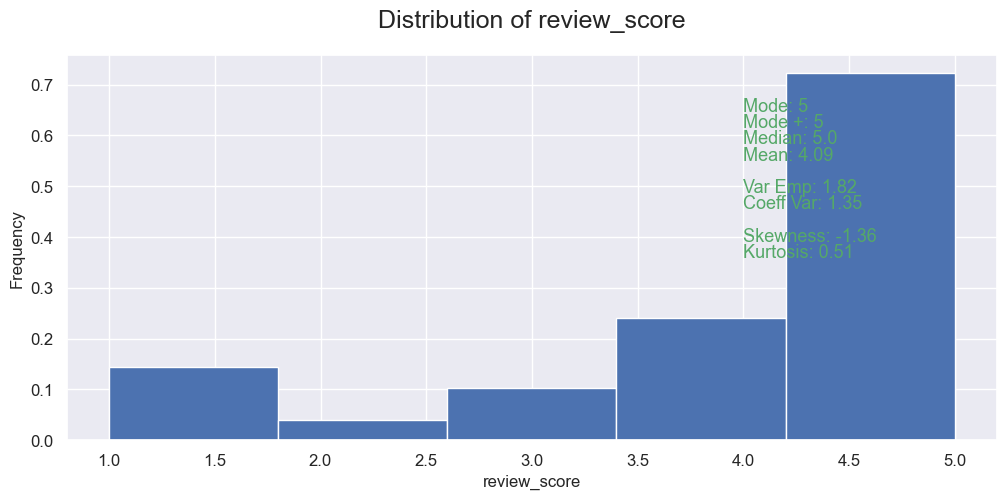

-1.36

In [24]:
hist_distrib(raw_df_order_reviews, 'review_score', 5, 2)


(1098, 7)


review_id                          order_id  \
25612  89a02c45c340aeeb1354a24e7d4b2c1e  0035246a40f520710769010f752e7507   
22423  2a74b0559eb58fc1ff842ecc999594cb  0035246a40f520710769010f752e7507   
22779  ab30810c29da5da8045216f0f62652a2  013056cfe49763c6f66bda03396c5ee3   
68633  73413b847f63e02bc752b364f6d05ee9  013056cfe49763c6f66bda03396c5ee3   
854    830636803620cdf8b6ffaf1b2f6e92b2  0176a6846bcb3b0d3aa3116a9a768597   
...                                 ...                               ...   
27465  5e78482ee783451be6026e5cf0c72de1  ff763b73e473d03c321bcd5a053316e8   
41355  39de8ad3a1a494fc68cc2d5382f052f4  ff850ba359507b996e8b2fbb26df8d03   
18783  80f25f32c00540d49d57796fb6658535  ff850ba359507b996e8b2fbb26df8d03   
92230  870d856a4873d3a67252b0c51d79b950  ffaabba06c9d293a3c614e0515ddbabc   
53962  5476dd0eaee7c4e2725cafb011aa758c  ffaabba06c9d293a3c614e0515ddbabc   

       review_score review_comment_title  \
25612             5                  NaN   
22423             5                  NaN   
22779             5                  NaN   
68633             4                  NaN   
854               5                  NaN   
...             ...                  ...   
27465             3                  NaN   
41355             5                  NaN   
18783             5                  NaN   
92230             3                  NaN   
53962             3                  NaN   

                                  review_comment_message review_creation_date  \
25612                                                NaN  2017-08-29 00:00:00   
22423  Estou acostumada a comprar produtos pelo barat...  2017-08-25 00:00:00   
22779                                                NaN  2018-02-22 00:00:00   
68633                                                NaN  2018-03-04 00:00:00   
854                                                  NaN  2017-12-30 00:00:00   
...                                                  ...                  ...   
27465  Não sei que haverá acontecido os demais chegaram   2017-11-18 00:00:00   
41355                       Envio rapido... Produto 100%  2017-08-16 00:00:00   
18783  Envio rapido, produto conforme descrito no anu...  2017-08-22 00:00:00   
92230                                                NaN  2017-12-20 00:00:00   
53962                                                NaN  2017-12-20 00:00:00   

      review_answer_timestamp  
25612     2017-08-30 01:59:12  
22423     2017-08-29 21:45:57  
22779     2018-02-23 12:12:30  
68633     2018-03-05 17:02:00  
854       2018-01-02 10:54:06  
...                       ...  
27465     2017-11-18 09:02:48  
41355     2017-08-17 11:56:55  
18783     2017-08-25 11:40:22  
92230     2017-12-20 18:50:16  
53962     2017-12-21 13:24:55  

[1098 rows x 7 columns]

[nan False True]
(1098, 8)


review_id                          order_id  \
25612  89a02c45c340aeeb1354a24e7d4b2c1e  0035246a40f520710769010f752e7507   
22423  2a74b0559eb58fc1ff842ecc999594cb  0035246a40f520710769010f752e7507   
22779  ab30810c29da5da8045216f0f62652a2  013056cfe49763c6f66bda03396c5ee3   
68633  73413b847f63e02bc752b364f6d05ee9  013056cfe49763c6f66bda03396c5ee3   
854    830636803620cdf8b6ffaf1b2f6e92b2  0176a6846bcb3b0d3aa3116a9a768597   
...                                 ...                               ...   
27465  5e78482ee783451be6026e5cf0c72de1  ff763b73e473d03c321bcd5a053316e8   
41355  39de8ad3a1a494fc68cc2d5382f052f4  ff850ba359507b996e8b2fbb26df8d03   
18783  80f25f32c00540d49d57796fb6658535  ff850ba359507b996e8b2fbb26df8d03   
92230  870d856a4873d3a67252b0c51d79b950  ffaabba06c9d293a3c614e0515ddbabc   
53962  5476dd0eaee7c4e2725cafb011aa758c  ffaabba06c9d293a3c614e0515ddbabc   

       review_score review_comment_title  \
25612           5.0                  NaN   
22423           5.0                  NaN   
22779           4.5                  NaN   
68633           4.5                  NaN   
854             5.0                  NaN   
...             ...                  ...   
27465           4.0                  NaN   
41355           5.0                  NaN   
18783           5.0                  NaN   
92230           3.0                  NaN   
53962           3.0                  NaN   

                                  review_comment_message review_creation_date  \
25612                                                NaN  2017-08-29 00:00:00   
22423  Estou acostumada a comprar produtos pelo barat...  2017-08-25 00:00:00   
22779                                                NaN  2018-02-22 00:00:00   
68633                                                NaN  2018-03-04 00:00:00   
854                                                  NaN  2017-12-30 00:00:00   
...                                                  ...                  ...   
27465  Não sei que haverá acontecido os demais chegaram   2017-11-18 00:00:00   
41355                       Envio rapido... Produto 100%  2017-08-16 00:00:00   
18783  Envio rapido, produto conforme descrito no anu...  2017-08-22 00:00:00   
92230                                                NaN  2017-12-20 00:00:00   
53962                                                NaN  2017-12-20 00:00:00   

      review_answer_timestamp contains_string  
25612     2017-08-30 01:59:12             NaN  
22423     2017-08-29 21:45:57           False  
22779     2018-02-23 12:12:30             NaN  
68633     2018-03-05 17:02:00             NaN  
854       2018-01-02 10:54:06             NaN  
...                       ...             ...  
27465     2017-11-18 09:02:48           False  
41355     2017-08-17 11:56:55           False  
18783     2017-08-25 11:40:22           False  
92230     2017-12-20 18:50:16             NaN  
53962     2017-12-21 13:24:55             NaN  

[1098 rows x 8 columns]

object
shape : (98673, 3)


review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score  
0           4.0  
1           5.0  
2           5.0  
3           5.0  
4           5.0

review_id                          order_id  \
98668  574ed12dd733e5fa530cfd4bbf39d7c9  2a8c23fee101d4d5662fa670396eb8da   
98669  f3897127253a9592a73be9bdfdf4ed7a  22ec9f0669f784db00fa86d035cf8602   
98670  b3de70c89b1510c4cd3d0649fd302472  55d4004744368f5571d1f590031933e4   
98671  1adeb9d84d72fe4e337617733eb85149  7725825d039fc1f0ceb7635e3f7d9206   
98672  efe49f1d6f951dd88b51e6ccd4cc548f  90531360ecb1eec2a1fbb265a0db0508   

       review_score  
98668           5.0  
98669           5.0  
98670           5.0  
98671           4.0  
98672           1.0

uniques :


review_id       98156
order_id        98673
review_score       11
dtype: int64

Doublons ?  0 



column_name  missing  present  percent_missing     type
review_id        review_id        0    98673              0.0   object
order_id          order_id        0    98673              0.0   object
review_score  review_score        0    98673              0.0  float64

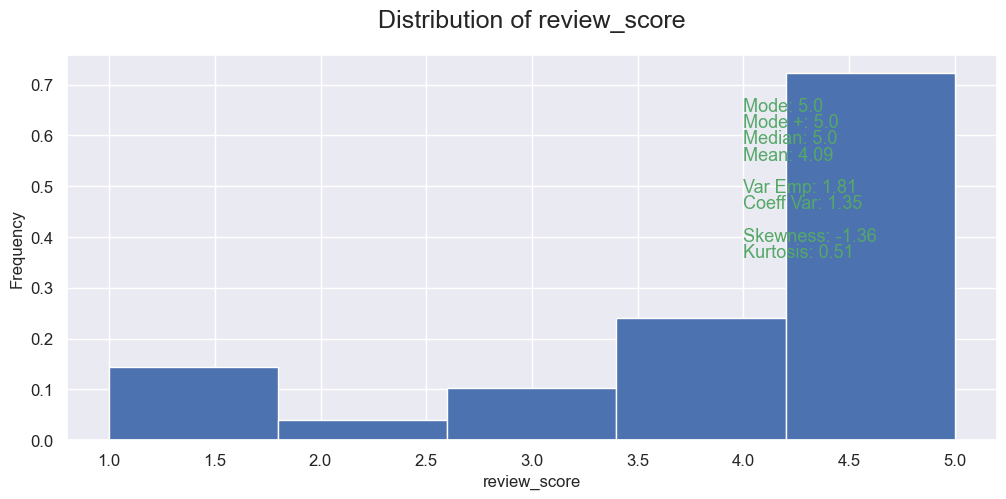

-1.36

In [25]:
print(raw_df_order_reviews[raw_df_order_reviews['order_id'].duplicated(keep=False)].shape)
display(raw_df_order_reviews[raw_df_order_reviews['order_id'].duplicated(keep=False)].sort_values(by='order_id'))

# Ok quand il y a plusieurs avis pour 1 seule commande, on peut commencer par 
# - prendre la moyenne (pour le score)
# - effacer les lignes sans titre ni message

df_reviews = raw_df_order_reviews.copy()

# Group by 'order_id' and transform 'review_score' to the mean of each group
df_reviews['review_score'] = df_reviews.groupby('order_id')['review_score'].transform('mean')

# Concatenate 'message' and 'title ' values 
# quick check
string_to_concat = r' \* \* \* '  # Use a raw string (r) to avoid interpreting backslashes as escape characters

df_reviews['contains_string'] = df_reviews['review_comment_message'].str.contains(string_to_concat)
print(df_reviews['contains_string'].unique())

# df_reviews['messages'] = df_reviews.groupby('order_id')['review_comment_message'].transform(
#     lambda x: string_to_concat.join(str(val) for val in x)
# )
# df_reviews['titles'] = df_reviews.groupby('order_id')['review_comment_title'].transform(
#     lambda x: string_to_concat.join(str(val) for val in x)
# )

# Prend trooooooooooop de temps,je ne vois pas comment optimiser sensiblement
# pas indispensable non plus, on va se contenter du score moyen.

print(df_reviews[df_reviews['order_id'].duplicated(keep=False)].shape)
display(df_reviews[df_reviews['order_id'].duplicated(keep=False)].sort_values(by='order_id'))

print(df_reviews['review_creation_date'].dtype)

df_review_score = df_reviews[['review_id', 'order_id', 'review_score']].copy()

# Drop duplicates based on the 'order_id' column
df_review_score.drop_duplicates(subset='order_id', inplace=True)

# Reset the index after dropping duplicates
df_review_score.reset_index(drop=True, inplace=True)

quick_look(df_review_score)
hist_distrib(df_review_score, 'review_score', 5, 2)

# c tt bon ! Rien n'a bougé excepté var empirique : -0.01
# La forme de la distrib semble idéale pour repérer les clients très insatisfaits per clustering


### products

In [26]:
raw_df_products = pd.read_csv('data/archive/olist_products_dataset.csv', sep=',')

print('Products_dataset :', '\n')
quick_look(raw_df_products)

# Inutile ici il me semble, sauf étude approfondie des paniers

# shape 0 = 32 951 produits
# 9 features. description generale du produit :
# id, categ, longueur nom, lg description, nb photos, poids, longueur, hauteur, largeur cm

# qq missing values but easy to fix if we need to (categorical)

# display(raw_df_products.describe())

# Allez, on va qd mm garder les categories

df_products = raw_df_products[['product_id', 'product_category_name']].copy()
print(df_products.shape)


Products_dataset : 

shape : (32951, 9)


product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

product_id              product_category_name  \
32946  a0b7d5a992ccda646f2d34e418fff5a0                   moveis_decoracao   
32947  bf4538d88321d0fd4412a93c974510e6  construcao_ferramentas_iluminacao   
32948  9a7c6041fa9592d9d9ef6cfe62a71f8c                    cama_mesa_banho   
32949  83808703fc0706a22e264b9d75f04a2e             informatica_acessorios   
32950  106392145fca363410d287a815be6de4                    cama_mesa_banho   

       product_name_lenght  product_description_lenght  product_photos_qty  \
32946                 45.0                        67.0                 2.0   
32947                 41.0                       971.0                 1.0   
32948                 50.0                       799.0                 1.0   
32949                 60.0                       156.0                 2.0   
32950                 58.0                       309.0                 1.0   

       product_weight_g  product_length_cm  product_height_cm  \
32946           12300.0               40.0               40.0   
32947            1700.0               16.0               19.0   
32948            1400.0               27.0                7.0   
32949             700.0               31.0               13.0   
32950            2083.0               12.0                2.0   

       product_width_cm  
32946              40.0  
32947              16.0  
32948              27.0  
32949              20.0  
32950               7.0

uniques :


product_id                    32951
product_category_name            73
product_name_lenght              66
product_description_lenght     2960
product_photos_qty               19
product_weight_g               2204
product_length_cm                99
product_height_cm               102
product_width_cm                 95
dtype: int64

Doublons ?  0 



column_name  missing  present  \
product_id                                  product_id        0    32951   
product_weight_g                      product_weight_g        2    32949   
product_length_cm                    product_length_cm        2    32949   
product_height_cm                    product_height_cm        2    32949   
product_width_cm                      product_width_cm        2    32949   
product_category_name            product_category_name      610    32341   
product_name_lenght                product_name_lenght      610    32341   
product_description_lenght  product_description_lenght      610    32341   
product_photos_qty                  product_photos_qty      610    32341   

                            percent_missing     type  
product_id                             0.00   object  
product_weight_g                       0.01  float64  
product_length_cm                      0.01  float64  
product_height_cm                      0.01  float64  
product_width_cm                       0.01  float64  
product_category_name                  1.85   object  
product_name_lenght                    1.85  float64  
product_description_lenght             1.85  float64  
product_photos_qty                     1.85  float64

(32951, 2)


### sellers

In [27]:
raw_df_sellers = pd.read_csv('data/archive/olist_sellers_dataset.csv', sep=',')

print('Sellers_dataset :', '\n')
quick_look(raw_df_sellers)

# COMPLETEMENT INUTILE ici il me semble.
# On segmente les clients, pas les vendeurs.

# Similaire au fichier clients (customers dataset)


Sellers_dataset : 

shape : (3095, 4)


seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP

seller_id  seller_zip_code_prefix seller_city  \
3090  98dddbc4601dd4443ca174359b237166                   87111     sarandi   
3091  f8201cab383e484733266d1906e2fdfa                   88137     palhoca   
3092  74871d19219c7d518d0090283e03c137                    4650   sao paulo   
3093  e603cf3fec55f8697c9059638d6c8eb5                   96080     pelotas   
3094  9e25199f6ef7e7c347120ff175652c3b                   12051     taubate   

     seller_state  
3090           PR  
3091           SC  
3092           SP  
3093           RS  
3094           SP

uniques :


seller_id                 3095
seller_zip_code_prefix    2246
seller_city                611
seller_state                23
dtype: int64

Doublons ?  0 



column_name  missing  present  \
seller_id                            seller_id        0     3095   
seller_zip_code_prefix  seller_zip_code_prefix        0     3095   
seller_city                        seller_city        0     3095   
seller_state                      seller_state        0     3095   

                        percent_missing    type  
seller_id                           0.0  object  
seller_zip_code_prefix              0.0   int64  
seller_city                         0.0  object  
seller_state                        0.0  object

### translation et Marketing Funnel

In [28]:
raw_df_translation = pd.read_csv('data/archive/product_category_name_translation.csv', sep=',')

print('Translation :', '\n')
quick_look(raw_df_translation)

# idem, inutile ici il me semble.

# Il y a aussi un Marketing Funnel à notre disposition
# mais il concerne les sellers.

# Construire un funnel pour les clients ? (/ entonnoir vente)

# "In the context of a "marketing funnel dataset," a funnel refers to a model or framework used to visualize 
# and analyze the stages that potential customers go through in the process of becoming actual customers. 
# It represents the customer's journey from initial awareness or contact with a product or service 
# to the eventual conversion or purchase.

# A typical marketing funnel consists of several stages, which may include:
# Awareness, interest, consideration, intent, purchase."

# Interessant, mais notre data commence au premier achat donc difficile de reconsruire 
# qqch avant ça.

# display(raw_df_translation.head(60))


Translation : 

shape : (71, 2)


product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

product_category_name product_category_name_english
66                         flores                       flowers
67             artes_e_artesanato         arts_and_craftmanship
68                fraldas_higiene           diapers_and_hygiene
69  fashion_roupa_infanto_juvenil     fashion_childrens_clothes
70             seguros_e_servicos         security_and_services

uniques :


product_category_name            71
product_category_name_english    71
dtype: int64

Doublons ?  0 



column_name  missing  \
product_category_name                  product_category_name        0   
product_category_name_english  product_category_name_english        0   

                               present  percent_missing    type  
product_category_name               71              0.0  object  
product_category_name_english       71              0.0  object

## 3 Création du fichier commandes (aka serial merging)

### commandes + clients

In [29]:
# Merge two dataframes using the common key
# how='inner' by default, which is fine here 
# (key is perfect, so any type of junction would give the same result)

merged_df_0 = df_orders_cut.merge(df_customers, on='customer_id')

print("Première jointure, orders + customers (same shape[0]), on key 'customer_id':", '\n')
quick_look(merged_df_0)


Première jointure, orders + customers (same shape[0]), on key 'customer_id': 

shape : (99421, 6)


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_purchase_timestamp                customer_unique_id  zipcode  \
0      2017-10-02 10:56:33  7c396fd4830fd04220f754e42b4e5bff     3149   
1      2018-07-24 20:41:37  af07308b275d755c9edb36a90c618231    47813   
2      2018-08-08 08:38:49  3a653a41f6f9fc3d2a113cf8398680e8    75265   
3      2017-11-18 19:28:06  7c142cf63193a1473d2e66489a9ae977    59296   
4      2018-02-13 21:18:39  72632f0f9dd73dfee390c9b22eb56dd6     9195   

  customer_state  
0             SP  
1             BA  
2             GO  
3             RN  
4             SP

order_id                       customer_id  \
99416  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99417  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99418  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99419  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99420  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_purchase_timestamp                customer_unique_id  zipcode  \
99416      2017-03-09 09:54:05  6359f309b166b0196dbf7ad2ac62bb5a    12209   
99417      2018-02-06 12:58:58  da62f9e57a76d978d02ab5362c509660    11722   
99418      2017-08-27 14:46:43  737520a9aad80b3fbbdad19b66b37b30    45920   
99419      2018-01-08 21:28:27  5097a5312c8b157bb7be58ae360ef43c    28685   
99420      2018-03-08 20:57:30  60350aa974b26ff12caad89e55993bd6    83750   

      customer_state  
99416             SP  
99417             SP  
99418             BA  
99419             RJ  
99420             PR

uniques :


order_id                    99421
customer_id                 99421
order_purchase_timestamp    98855
customer_unique_id          96090
zipcode                     14994
customer_state                 27
dtype: int64

Doublons ?  0 



column_name  missing  present  \
order_id                                  order_id        0    99421   
customer_id                            customer_id        0    99421   
order_purchase_timestamp  order_purchase_timestamp        0    99421   
customer_unique_id              customer_unique_id        0    99421   
zipcode                                    zipcode        0    99421   
customer_state                      customer_state        0    99421   

                          percent_missing            type  
order_id                              0.0          object  
customer_id                           0.0          object  
order_purchase_timestamp              0.0  datetime64[ns]  
customer_unique_id                    0.0          object  
zipcode                               0.0           int64  
customer_state                        0.0          object

### + coordonnées

In [30]:
merged_df_1 = merged_df_0.merge(df_geo[['zipcode', 'latitude', 'longitude']], on='zipcode')

print("Deuxième première jointure,  + lat lng:", '\n')
quick_look(merged_df_1)

# On perd 300 lignes
# pour des features qui vont surtout (uniquement?) servir à visualiser..
# J'hésite.

# 300 / 99 000 c pas bcp
# bon on verra si ça sert ou pas

# Au fait pourquoi on perd des gens ici ?? Ils n'ont pas ttes les adresses ?
# Ah oui je croyais encore que zipcode était une clé. Well it's not^^


Deuxième première jointure,  + lat lng: 

shape : (99143, 8)


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  70b35acffdf851e782ebf6fbc35eb620  8e8ee9b08afb49b080d193f98b0505af   
2  69923a4e07ce446644394df37a710286  31f31efcb333fcbad2b1371c8cf0fa84   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  d95ca1fcb72812383e41e2eb7ca65dc2  2fd14b072ea7ff170527396ceca430d0   

  order_purchase_timestamp                customer_unique_id  zipcode  \
0      2017-10-02 10:56:33  7c396fd4830fd04220f754e42b4e5bff     3149   
1      2018-03-22 17:23:21  8a4002923e801e3120a11070fd31c9e2     3149   
2      2017-09-04 11:26:38  7c396fd4830fd04220f754e42b4e5bff     3149   
3      2018-07-24 20:41:37  af07308b275d755c9edb36a90c618231    47813   
4      2017-03-30 20:26:30  f0aa9a24f330070e4bf9b5320c898ce7    47813   

  customer_state   latitude  longitude  
0             SP -23.577482 -46.587077  
1             SP -23.577482 -46.587077  
2             SP -23.577482 -46.587077  
3             BA -12.186877 -44.540232  
4             BA -12.186877 -44.540232

order_id                       customer_id  \
99138  87334ea6311529ce3e36b18350d2d4b3  02f29ee4753e69018942c30e71c04cfd   
99139  5bd233924f0b9c52492bd5a92e5ab2d3  d7475a536385854da614094f0bf12275   
99140  cfa78b997e329a5295b4ee6972c02979  a2f7428f0cafbc8e59f20e1444b67315   
99141  880675dff2150932f1601e1c07eadeeb  47cd45a6ac7b9fb16537df2ccffeb5ac   
99142  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   

      order_purchase_timestamp                customer_unique_id  zipcode  \
99138      2018-01-20 18:39:14  f86370dc13be4e8958cb036b628afbcc    25932   
99139      2018-05-30 13:23:37  17e3c70fc02567ec2d3831fa78e037c0    77829   
99140      2017-12-20 09:52:41  a49e8e11e850592fe685ae3c64b40eca    83870   
99141      2017-02-23 09:05:12  831ce3f1bacbd424fc4e38fbd4d66d29     5127   
99142      2017-08-27 14:46:43  737520a9aad80b3fbbdad19b66b37b30    45920   

      customer_state   latitude  longitude  
99138             RJ -22.607457 -43.163463  
99139             TO  -7.223332 -48.238048  
99140             PR -25.984014 -49.679103  
99141             SP -23.497519 -46.738910  
99142             BA -17.898045 -39.373106

uniques :


order_id                    99143
customer_id                 99143
order_purchase_timestamp    98581
customer_unique_id          95822
zipcode                     14837
customer_state                 27
latitude                    14837
longitude                   14837
dtype: int64

Doublons ?  0 



column_name  missing  present  \
order_id                                  order_id        0    99143   
customer_id                            customer_id        0    99143   
order_purchase_timestamp  order_purchase_timestamp        0    99143   
customer_unique_id              customer_unique_id        0    99143   
zipcode                                    zipcode        0    99143   
customer_state                      customer_state        0    99143   
latitude                                  latitude        0    99143   
longitude                                longitude        0    99143   

                          percent_missing            type  
order_id                              0.0          object  
customer_id                           0.0          object  
order_purchase_timestamp              0.0  datetime64[ns]  
customer_unique_id                    0.0          object  
zipcode                               0.0           int64  
customer_state                        0.0          object  
latitude                              0.0         float64  
longitude                             0.0         float64

### + détails commandes

In [31]:
# Où ils habitent, les dates de livraison... Maintenant il nous faut des montants !

merged_df_2 = df_order_items.merge(merged_df_1, on='order_id')

# Pas sûr que ça nous sera utile de savoir quel produit, ou le détail de la commande, 
# mais pour l'instant on prend large.

print("Deuxième jointure, on ajoute le detail des commandes", '\n')
quick_look(merged_df_2)

# problem !
# le nb de valeurs uniques pour 'order_id' a baissé

# Check which values are not in the set
missing_items = df_order_items[~df_order_items['order_id'].isin(merged_df_1['order_id'].unique())]

# Print or inspect the missing categories
quick_look(missing_items)

# Concerne une unique commande, on peut drop
# (Il est impossible de relier cette commande aux autres tables)
# (en tous cas avec cette clé..)
df_order_items = df_order_items[~df_order_items['order_id'].isin(missing_items['order_id'])]

merged_df_2 = df_order_items.merge(merged_df_1, on='order_id')

print("Deuxième jointure, on ajoute encore le detail des commandes", '\n')
quick_look(merged_df_2)

# problèmes réglés, 
# merged_df_2['order_id'].nunique() == df_order_items['order_id'].nunique()


Deuxième jointure, on ajoute le detail des commandes 

shape : (112347, 12)


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1  e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2  c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3  7634da152a4610f1595efa32f14722fc   12.99          12.79   
4  ac6c3623068f30de03045865e4e10089  199.90          18.14   

                        customer_id order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795      2017-02-04 13:57:51   

                 customer_unique_id  zipcode customer_state   latitude  \
0  871766c5855e863f6eccc05f988b23cb    28013             RJ -21.763186   
1  eb28e67c4c0b83846050ddfb8a35d051    15775             SP -20.222506   
2  3818d81c6709e39d06b2738a8d3a2474    35661             MG -19.869998   
3  af861d436cfc08b2c2ddefd0ba074622    12952             SP -23.105968   
4  64b576fb70d441e8f1b2d7d446e483c5    13226             SP -23.243402   

   longitude  
0 -41.310265  
1 -50.898951  
2 -44.593059  
3 -46.590277  
4 -46.827614

order_id  order_item_id  \
112342  fffc94f6ce00a00581880bf54a75a037              1   
112343  fffcd46ef2263f404302a634eb57f7eb              1   
112344  fffce4705a9662cd70adb13d4a31832d              1   
112345  fffe18544ffabc95dfada21779c9644f              1   
112346  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id   price  freight_value  \
112342  4aa6014eceb682077f9dc4bffebc05b0  299.99          43.41   
112343  32e07fd915822b0765e448c4dd74c828  350.00          36.53   
112344  72a30483855e2eafc67aee5dc2560482   99.90          16.95   
112345  9c422a519119dcad7575db5af1ba540e   55.99           8.72   
112346  350688d9dc1e75ff97be326363655e01   43.00          12.79   

                             customer_id order_purchase_timestamp  \
112342  b51593916b4b8e0d6f66f2ae24f2673d      2018-04-23 13:57:06   
112343  84c5d4fbaf120aae381fad077416eaa0      2018-07-14 10:26:46   
112344  29309aa813182aaddc9b259e31b870e6      2017-10-23 17:07:56   
112345  b5e6afd5a41800fdf401e0272ca74655      2017-08-14 23:02:59   
112346  96d649da0cc4ff33bb408b199d4c7dcf      2018-06-09 17:00:18   

                      customer_unique_id  zipcode customer_state   latitude  \
112342  0c9aeda10a71f369396d0c04dce13a64    65077             MA  -2.499937   
112343  0da9fe112eae0c74d3ba1fe16de0988b    81690             PR -25.582933   
112344  cd79b407828f02fdbba457111c38e4c4     4039             SP -23.597320   
112345  eb803377c9315b564bdedad672039306    13289             SP -23.039798   
112346  cd76a00d8e3ca5e6ab9ed9ecb6667ac4    18605             SP -22.916837   

        longitude  
112342 -44.295904  
112343 -49.313298  
112344 -46.643843  
112345 -46.979488  
112346 -48.441730

uniques :


order_id                    98391
order_item_id                  21
product_id                  32904
price                        5957
freight_value                6993
customer_id                 98391
order_purchase_timestamp    97841
customer_unique_id          95156
zipcode                     14820
customer_state                 27
latitude                    14820
longitude                   14820
dtype: int64

Doublons ?  0 



column_name  missing  present  \
order_id                                  order_id        0   112347   
order_item_id                        order_item_id        0   112347   
product_id                              product_id        0   112347   
price                                        price        0   112347   
freight_value                        freight_value        0   112347   
customer_id                            customer_id        0   112347   
order_purchase_timestamp  order_purchase_timestamp        0   112347   
customer_unique_id              customer_unique_id        0   112347   
zipcode                                    zipcode        0   112347   
customer_state                      customer_state        0   112347   
latitude                                  latitude        0   112347   
longitude                                longitude        0   112347   

                          percent_missing            type  
order_id                              0.0          object  
order_item_id                         0.0           int64  
product_id                            0.0          object  
price                                 0.0         float64  
freight_value                         0.0         float64  
customer_id                           0.0          object  
order_purchase_timestamp              0.0  datetime64[ns]  
customer_unique_id                    0.0          object  
zipcode                               0.0           int64  
customer_state                        0.0          object  
latitude                              0.0         float64  
longitude                             0.0         float64

shape : (303, 5)


order_id  order_item_id  \
241   009fa9bd0d92710e840793bfefa80867              1   
799   01d3d4cb8c553d507dfd26fbd8b41e95              1   
1032  02623e799dcc1e41066ddfe4af591f24              1   
1152  02acaa2a6f24e9c4e0bec7141b65f29b              1   
1816  041cba819a99569f87996b65b73ea82e              1   

                            product_id   price  freight_value  
241   617186c3d97ea56c9c683a8a3974e8c1   84.99          15.34  
799   33e77eecc23c25a65d10f627e5053617  114.94          34.16  
1032  ffd34459c21034d1da6df9800de0d7a3   52.99          15.12  
1152  06c6e01186af8b98ee1fc9e01f9471e9   29.90          14.10  
1816  154e7e31ebfa092203795c972e5804a6   23.99          14.16

order_id  order_item_id  \
110420  fae78da81b7ad4a5389732f61e0264ef              3   
110421  fae78da81b7ad4a5389732f61e0264ef              4   
111537  fd5c73fb6edc88486582bf0a0bb989aa              1   
112018  fe784ed3dfc728fd4de44fa9918fe1eb              1   
112058  fe94f63f2f4d326a6da25bfe07ffaf93              1   

                              product_id   price  freight_value  
110420  25bf7c5e5f9d008845212122805014e5   18.90          15.10  
110421  25bf7c5e5f9d008845212122805014e5   18.90          15.10  
111537  5861173d9af66445f070078cfc29a597  199.99          13.84  
112018  9ac1378f05cd222b3fb34a3cccc626c7   39.90          18.08  
112058  86ecc269de40ba13205e7beeee12f26f   29.99          15.31

uniques :


order_id         275
order_item_id      5
product_id       269
price            196
freight_value    212
dtype: int64

Doublons ?  0 



column_name  missing  present  percent_missing     type
order_id            order_id        0      303              0.0   object
order_item_id  order_item_id        0      303              0.0    int64
product_id        product_id        0      303              0.0   object
price                  price        0      303              0.0  float64
freight_value  freight_value        0      303              0.0  float64

Deuxième jointure, on ajoute encore le detail des commandes 

shape : (112347, 12)


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1  e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2  c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3  7634da152a4610f1595efa32f14722fc   12.99          12.79   
4  ac6c3623068f30de03045865e4e10089  199.90          18.14   

                        customer_id order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795      2017-02-04 13:57:51   

                 customer_unique_id  zipcode customer_state   latitude  \
0  871766c5855e863f6eccc05f988b23cb    28013             RJ -21.763186   
1  eb28e67c4c0b83846050ddfb8a35d051    15775             SP -20.222506   
2  3818d81c6709e39d06b2738a8d3a2474    35661             MG -19.869998   
3  af861d436cfc08b2c2ddefd0ba074622    12952             SP -23.105968   
4  64b576fb70d441e8f1b2d7d446e483c5    13226             SP -23.243402   

   longitude  
0 -41.310265  
1 -50.898951  
2 -44.593059  
3 -46.590277  
4 -46.827614

order_id  order_item_id  \
112342  fffc94f6ce00a00581880bf54a75a037              1   
112343  fffcd46ef2263f404302a634eb57f7eb              1   
112344  fffce4705a9662cd70adb13d4a31832d              1   
112345  fffe18544ffabc95dfada21779c9644f              1   
112346  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id   price  freight_value  \
112342  4aa6014eceb682077f9dc4bffebc05b0  299.99          43.41   
112343  32e07fd915822b0765e448c4dd74c828  350.00          36.53   
112344  72a30483855e2eafc67aee5dc2560482   99.90          16.95   
112345  9c422a519119dcad7575db5af1ba540e   55.99           8.72   
112346  350688d9dc1e75ff97be326363655e01   43.00          12.79   

                             customer_id order_purchase_timestamp  \
112342  b51593916b4b8e0d6f66f2ae24f2673d      2018-04-23 13:57:06   
112343  84c5d4fbaf120aae381fad077416eaa0      2018-07-14 10:26:46   
112344  29309aa813182aaddc9b259e31b870e6      2017-10-23 17:07:56   
112345  b5e6afd5a41800fdf401e0272ca74655      2017-08-14 23:02:59   
112346  96d649da0cc4ff33bb408b199d4c7dcf      2018-06-09 17:00:18   

                      customer_unique_id  zipcode customer_state   latitude  \
112342  0c9aeda10a71f369396d0c04dce13a64    65077             MA  -2.499937   
112343  0da9fe112eae0c74d3ba1fe16de0988b    81690             PR -25.582933   
112344  cd79b407828f02fdbba457111c38e4c4     4039             SP -23.597320   
112345  eb803377c9315b564bdedad672039306    13289             SP -23.039798   
112346  cd76a00d8e3ca5e6ab9ed9ecb6667ac4    18605             SP -22.916837   

        longitude  
112342 -44.295904  
112343 -49.313298  
112344 -46.643843  
112345 -46.979488  
112346 -48.441730

uniques :


order_id                    98391
order_item_id                  21
product_id                  32904
price                        5957
freight_value                6993
customer_id                 98391
order_purchase_timestamp    97841
customer_unique_id          95156
zipcode                     14820
customer_state                 27
latitude                    14820
longitude                   14820
dtype: int64

Doublons ?  0 



column_name  missing  present  \
order_id                                  order_id        0   112347   
order_item_id                        order_item_id        0   112347   
product_id                              product_id        0   112347   
price                                        price        0   112347   
freight_value                        freight_value        0   112347   
customer_id                            customer_id        0   112347   
order_purchase_timestamp  order_purchase_timestamp        0   112347   
customer_unique_id              customer_unique_id        0   112347   
zipcode                                    zipcode        0   112347   
customer_state                      customer_state        0   112347   
latitude                                  latitude        0   112347   
longitude                                longitude        0   112347   

                          percent_missing            type  
order_id                              0.0          object  
order_item_id                         0.0           int64  
product_id                            0.0          object  
price                                 0.0         float64  
freight_value                         0.0         float64  
customer_id                           0.0          object  
order_purchase_timestamp              0.0  datetime64[ns]  
customer_unique_id                    0.0          object  
zipcode                               0.0           int64  
customer_state                        0.0          object  
latitude                              0.0         float64  
longitude                             0.0         float64

### + méthode de paiement

In [32]:
# Get a set of unique 'order_id' values from merged_df_2
order_ids_in_merged_df_2 = set(merged_df_2['order_id'])

# Get a set of unique 'order_id' values from raw_df_order_payments
order_ids_in_order_payments = set(raw_df_order_payments['order_id'])

# Identify the missing 'order_id' values
missing_order_ids = order_ids_in_merged_df_2 - order_ids_in_order_payments

# Display the missing 'order_id' values
print("Missing 'order_id' values in raw_df_order_payments:")
print(missing_order_ids)
# {'bfbd0f9bdef84302105ad712db648a6c'}

display(merged_df_2.loc[merged_df_2['order_id'] == 'bfbd0f9bdef84302105ad712db648a6c', :])

# OK on a 1 commande (3 articles, environ 10 euros au total) concernée,
# où on n'a pas de coordonnées bancaires.
# Je pense que ces données bancaires peuvent être pertinentes, on va donc supprimer ces 3 lignes,
# pour éviter d'introduire ici des NaN ou valeurs manquantes. Vaut pas le coup pour 1 commande / +100 000

merged_df_2 = merged_df_2[~merged_df_2['order_id'].isin(missing_order_ids)].copy()

quick_look(merged_df_2)
# OK


Missing 'order_id' values in raw_df_order_payments:
{'bfbd0f9bdef84302105ad712db648a6c'}


order_id  order_item_id  \
84156  bfbd0f9bdef84302105ad712db648a6c              1   
84157  bfbd0f9bdef84302105ad712db648a6c              2   
84158  bfbd0f9bdef84302105ad712db648a6c              3   

                             product_id  price  freight_value  \
84156  5a6b04657a4c5ee34285d1e4619a96b4  44.99           2.83   
84157  5a6b04657a4c5ee34285d1e4619a96b4  44.99           2.83   
84158  5a6b04657a4c5ee34285d1e4619a96b4  44.99           2.83   

                            customer_id order_purchase_timestamp  \
84156  86dc2ffce2dfff336de2f386a786e574      2016-09-15 12:16:38   
84157  86dc2ffce2dfff336de2f386a786e574      2016-09-15 12:16:38   
84158  86dc2ffce2dfff336de2f386a786e574      2016-09-15 12:16:38   

                     customer_unique_id  zipcode customer_state   latitude  \
84156  830d5b7aaa3b6f1e9ad63703bec97d23    14600             SP -20.585829   
84157  830d5b7aaa3b6f1e9ad63703bec97d23    14600             SP -20.585829   
84158  830d5b7aaa3b6f1e9ad63703bec97d23    14600             SP -20.585829   

       longitude  
84156 -47.863559  
84157 -47.863559  
84158 -47.863559

shape : (112344, 12)


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1  e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2  c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3  7634da152a4610f1595efa32f14722fc   12.99          12.79   
4  ac6c3623068f30de03045865e4e10089  199.90          18.14   

                        customer_id order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795      2017-02-04 13:57:51   

                 customer_unique_id  zipcode customer_state   latitude  \
0  871766c5855e863f6eccc05f988b23cb    28013             RJ -21.763186   
1  eb28e67c4c0b83846050ddfb8a35d051    15775             SP -20.222506   
2  3818d81c6709e39d06b2738a8d3a2474    35661             MG -19.869998   
3  af861d436cfc08b2c2ddefd0ba074622    12952             SP -23.105968   
4  64b576fb70d441e8f1b2d7d446e483c5    13226             SP -23.243402   

   longitude  
0 -41.310265  
1 -50.898951  
2 -44.593059  
3 -46.590277  
4 -46.827614

order_id  order_item_id  \
112342  fffc94f6ce00a00581880bf54a75a037              1   
112343  fffcd46ef2263f404302a634eb57f7eb              1   
112344  fffce4705a9662cd70adb13d4a31832d              1   
112345  fffe18544ffabc95dfada21779c9644f              1   
112346  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id   price  freight_value  \
112342  4aa6014eceb682077f9dc4bffebc05b0  299.99          43.41   
112343  32e07fd915822b0765e448c4dd74c828  350.00          36.53   
112344  72a30483855e2eafc67aee5dc2560482   99.90          16.95   
112345  9c422a519119dcad7575db5af1ba540e   55.99           8.72   
112346  350688d9dc1e75ff97be326363655e01   43.00          12.79   

                             customer_id order_purchase_timestamp  \
112342  b51593916b4b8e0d6f66f2ae24f2673d      2018-04-23 13:57:06   
112343  84c5d4fbaf120aae381fad077416eaa0      2018-07-14 10:26:46   
112344  29309aa813182aaddc9b259e31b870e6      2017-10-23 17:07:56   
112345  b5e6afd5a41800fdf401e0272ca74655      2017-08-14 23:02:59   
112346  96d649da0cc4ff33bb408b199d4c7dcf      2018-06-09 17:00:18   

                      customer_unique_id  zipcode customer_state   latitude  \
112342  0c9aeda10a71f369396d0c04dce13a64    65077             MA  -2.499937   
112343  0da9fe112eae0c74d3ba1fe16de0988b    81690             PR -25.582933   
112344  cd79b407828f02fdbba457111c38e4c4     4039             SP -23.597320   
112345  eb803377c9315b564bdedad672039306    13289             SP -23.039798   
112346  cd76a00d8e3ca5e6ab9ed9ecb6667ac4    18605             SP -22.916837   

        longitude  
112342 -44.295904  
112343 -49.313298  
112344 -46.643843  
112345 -46.979488  
112346 -48.441730

uniques :


order_id                    98390
order_item_id                  21
product_id                  32904
price                        5957
freight_value                6993
customer_id                 98390
order_purchase_timestamp    97840
customer_unique_id          95155
zipcode                     14820
customer_state                 27
latitude                    14820
longitude                   14820
dtype: int64

Doublons ?  0 



column_name  missing  present  \
order_id                                  order_id        0   112344   
order_item_id                        order_item_id        0   112344   
product_id                              product_id        0   112344   
price                                        price        0   112344   
freight_value                        freight_value        0   112344   
customer_id                            customer_id        0   112344   
order_purchase_timestamp  order_purchase_timestamp        0   112344   
customer_unique_id              customer_unique_id        0   112344   
zipcode                                    zipcode        0   112344   
customer_state                      customer_state        0   112344   
latitude                                  latitude        0   112344   
longitude                                longitude        0   112344   

                          percent_missing            type  
order_id                              0.0          object  
order_item_id                         0.0           int64  
product_id                            0.0          object  
price                                 0.0         float64  
freight_value                         0.0         float64  
customer_id                           0.0          object  
order_purchase_timestamp              0.0  datetime64[ns]  
customer_unique_id                    0.0          object  
zipcode                               0.0           int64  
customer_state                        0.0          object  
latitude                              0.0         float64  
longitude                             0.0         float64

In [33]:
merged_df_3 = merged_df_2.merge(grouped_payment_df, on='order_id')

print("Troisième jointure, infos sur méthode de paiement", '\n')
quick_look(merged_df_3)


Troisième jointure, infos sur méthode de paiement 

shape : (112344, 19)


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1  e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2  c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3  7634da152a4610f1595efa32f14722fc   12.99          12.79   
4  ac6c3623068f30de03045865e4e10089  199.90          18.14   

                        customer_id order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795      2017-02-04 13:57:51   

                 customer_unique_id  zipcode customer_state   latitude  \
0  871766c5855e863f6eccc05f988b23cb    28013             RJ -21.763186   
1  eb28e67c4c0b83846050ddfb8a35d051    15775             SP -20.222506   
2  3818d81c6709e39d06b2738a8d3a2474    35661             MG -19.869998   
3  af861d436cfc08b2c2ddefd0ba074622    12952             SP -23.105968   
4  64b576fb70d441e8f1b2d7d446e483c5    13226             SP -23.243402   

   longitude  payment_installments  payment_total  payment_type_credit_card  \
0 -41.310265                     2          72.19                     72.19   
1 -50.898951                     3         259.83                    259.83   
2 -44.593059                     5         216.87                    216.87   
3 -46.590277                     2          25.78                     25.78   
4 -46.827614                     3         218.04                    218.04   

   payment_type_boleto  payment_type_voucher  payment_type_debit_card  \
0                  0.0                   0.0                      0.0   
1                  0.0                   0.0                      0.0   
2                  0.0                   0.0                      0.0   
3                  0.0                   0.0                      0.0   
4                  0.0                   0.0                      0.0   

   payment_type_not_defined  
0                       0.0  
1                       0.0  
2                       0.0  
3                       0.0  
4                       0.0

order_id  order_item_id  \
112339  fffc94f6ce00a00581880bf54a75a037              1   
112340  fffcd46ef2263f404302a634eb57f7eb              1   
112341  fffce4705a9662cd70adb13d4a31832d              1   
112342  fffe18544ffabc95dfada21779c9644f              1   
112343  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id   price  freight_value  \
112339  4aa6014eceb682077f9dc4bffebc05b0  299.99          43.41   
112340  32e07fd915822b0765e448c4dd74c828  350.00          36.53   
112341  72a30483855e2eafc67aee5dc2560482   99.90          16.95   
112342  9c422a519119dcad7575db5af1ba540e   55.99           8.72   
112343  350688d9dc1e75ff97be326363655e01   43.00          12.79   

                             customer_id order_purchase_timestamp  \
112339  b51593916b4b8e0d6f66f2ae24f2673d      2018-04-23 13:57:06   
112340  84c5d4fbaf120aae381fad077416eaa0      2018-07-14 10:26:46   
112341  29309aa813182aaddc9b259e31b870e6      2017-10-23 17:07:56   
112342  b5e6afd5a41800fdf401e0272ca74655      2017-08-14 23:02:59   
112343  96d649da0cc4ff33bb408b199d4c7dcf      2018-06-09 17:00:18   

                      customer_unique_id  zipcode customer_state   latitude  \
112339  0c9aeda10a71f369396d0c04dce13a64    65077             MA  -2.499937   
112340  0da9fe112eae0c74d3ba1fe16de0988b    81690             PR -25.582933   
112341  cd79b407828f02fdbba457111c38e4c4     4039             SP -23.597320   
112342  eb803377c9315b564bdedad672039306    13289             SP -23.039798   
112343  cd76a00d8e3ca5e6ab9ed9ecb6667ac4    18605             SP -22.916837   

        longitude  payment_installments  payment_total  \
112339 -44.295904                     1         343.40   
112340 -49.313298                     1         386.53   
112341 -46.643843                     3         116.85   
112342 -46.979488                     3          64.71   
112343 -48.441730                     1          55.79   

        payment_type_credit_card  payment_type_boleto  payment_type_voucher  \
112339                      0.00               343.40                   0.0   
112340                      0.00               386.53                   0.0   
112341                    116.85                 0.00                   0.0   
112342                     64.71                 0.00                   0.0   
112343                     55.79                 0.00                   0.0   

        payment_type_debit_card  payment_type_not_defined  
112339                      0.0                       0.0  
112340                      0.0                       0.0  
112341                      0.0                       0.0  
112342                      0.0                       0.0  
112343                      0.0                       0.0

uniques :


order_id                    98390
order_item_id                  21
product_id                  32904
price                        5957
freight_value                6993
customer_id                 98390
order_purchase_timestamp    97840
customer_unique_id          95155
zipcode                     14820
customer_state                 27
latitude                    14820
longitude                   14820
payment_installments           28
payment_total               27815
payment_type_credit_card    25290
payment_type_boleto         10455
payment_type_voucher         2756
payment_type_debit_card      1378
payment_type_not_defined        1
dtype: int64

Doublons ?  0 



column_name  missing  present  \
order_id                                  order_id        0   112344   
payment_type_voucher          payment_type_voucher        0   112344   
payment_type_boleto            payment_type_boleto        0   112344   
payment_type_credit_card  payment_type_credit_card        0   112344   
payment_total                        payment_total        0   112344   
payment_installments          payment_installments        0   112344   
longitude                                longitude        0   112344   
latitude                                  latitude        0   112344   
payment_type_debit_card    payment_type_debit_card        0   112344   
customer_state                      customer_state        0   112344   
customer_unique_id              customer_unique_id        0   112344   
order_purchase_timestamp  order_purchase_timestamp        0   112344   
customer_id                            customer_id        0   112344   
freight_value                        freight_value        0   112344   
price                                        price        0   112344   
product_id                              product_id        0   112344   
order_item_id                        order_item_id        0   112344   
zipcode                                    zipcode        0   112344   
payment_type_not_defined  payment_type_not_defined        0   112344   

                          percent_missing            type  
order_id                              0.0          object  
payment_type_voucher                  0.0         float64  
payment_type_boleto                   0.0         float64  
payment_type_credit_card              0.0         float64  
payment_total                         0.0         float64  
payment_installments                  0.0           int64  
longitude                             0.0         float64  
latitude                              0.0         float64  
payment_type_debit_card               0.0         float64  
customer_state                        0.0          object  
customer_unique_id                    0.0          object  
order_purchase_timestamp              0.0  datetime64[ns]  
customer_id                           0.0          object  
freight_value                         0.0         float64  
price                                 0.0         float64  
product_id                            0.0          object  
order_item_id                         0.0           int64  
zipcode                               0.0           int64  
payment_type_not_defined              0.0         float64

### + catégories de produits

In [34]:
merged_df_4 = merged_df_3.merge(df_products, on='product_id')

print("Quatrième jointure, infos sur catégories des produits", '\n')
quick_look(merged_df_4)


Quatrième jointure, infos sur catégories des produits 

shape : (112344, 20)


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  130898c0987d1801452a8ed92a670612              1   
2  532ed5e14e24ae1f0d735b91524b98b9              1   
3  6f8c31653edb8c83e1a739408b5ff750              1   
4  7d19f4ef4d04461989632411b7e588b9              1   

                         product_id  price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.9          13.29   
1  4244733e06e7ecb4970a6e2683c13e61   55.9          17.96   
2  4244733e06e7ecb4970a6e2683c13e61   64.9          18.33   
3  4244733e06e7ecb4970a6e2683c13e61   58.9          16.17   
4  4244733e06e7ecb4970a6e2683c13e61   58.9          13.29   

                        customer_id order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a      2017-09-13 08:59:02   
1  e6eecc5a77de221464d1c4eaff0a9b64      2017-06-28 11:52:20   
2  4ef55bf80f711b372afebcb7c715344a      2018-05-18 10:25:53   
3  30407a72ad8b3f4df4d15369126b20c9      2017-08-01 18:38:42   
4  91a792fef70ecd8cc69d3c7feb3d12da      2017-08-10 21:48:40   

                 customer_unique_id  zipcode customer_state   latitude  \
0  871766c5855e863f6eccc05f988b23cb    28013             RJ -21.763186   
1  0fb8e3eab2d3e79d92bb3fffbb97f188    75800             GO -17.884803   
2  3419052c8c6b45daf79c1e426f9e9bcb    30720             MG -19.913964   
3  e7c828d22c0682c1565252deefbe334d    83070             PR -25.520334   
4  0bb98ba72dcc08e95f9d8cc434e9a2cc    36400             MG -20.655379   

   longitude  payment_installments  payment_total  payment_type_credit_card  \
0 -41.310265                     2          72.19                     72.19   
1 -51.717167                     1          73.86                      0.00   
2 -43.976106                     2          83.23                     83.23   
3 -49.124988                     3          75.07                     75.07   
4 -43.776331                     4          72.19                     72.19   

   payment_type_boleto  payment_type_voucher  payment_type_debit_card  \
0                 0.00                   0.0                      0.0   
1                73.86                   0.0                      0.0   
2                 0.00                   0.0                      0.0   
3                 0.00                   0.0                      0.0   
4                 0.00                   0.0                      0.0   

   payment_type_not_defined product_category_name  
0                       0.0            cool_stuff  
1                       0.0            cool_stuff  
2                       0.0            cool_stuff  
3                       0.0            cool_stuff  
4                       0.0            cool_stuff

order_id  order_item_id  \
112339  ffebd80e3291e811c308365936897efd              1   
112340  ffee31fb4b5e35c9123608015637c495              1   
112341  fff7c4452f050315db1b3f24d9df5fcd              1   
112342  fffa82886406ccf10c7b4e35c4ff2788              1   
112343  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id  price  freight_value  \
112339  4cc4d02efc8f249c13355147fb44e34d  129.9          51.20   
112340  b10ecf8e33aaaea419a9fa860ea80fb5   99.0          13.52   
112341  dd469c03ad67e201bc2179ef077dcd48  736.0          20.91   
112342  bbe7651fef80287a816ead73f065fc4b  229.9          44.02   
112343  350688d9dc1e75ff97be326363655e01   43.0          12.79   

                             customer_id order_purchase_timestamp  \
112339  050309b91cc5e04e68841938e7984aaf      2018-07-13 20:04:05   
112340  11e0f43ab4e2d2c48348dd9332c0ef80      2018-08-18 10:00:59   
112341  dec8952e97ef6124259c56914fb3569c      2017-06-01 16:53:03   
112342  a5201e1a6d71a8d21e869151bd5b4085      2017-12-18 16:33:07   
112343  96d649da0cc4ff33bb408b199d4c7dcf      2018-06-09 17:00:18   

                      customer_unique_id  zipcode customer_state   latitude  \
112339  a1c2e4b4c1b29e41684ebdf3cc6538f8    28740             RJ -22.087256   
112340  4e15fee963523774998876e3624952f4    83065             PR -25.512617   
112341  c86ab5ff2bac777c4e770a383feca4eb    27261             RJ -22.523608   
112342  2a3ab9bf9639491997586882c502540a    59955             RN  -6.464059   
112343  cd76a00d8e3ca5e6ab9ed9ecb6667ac4    18605             SP -22.916837   

        longitude  payment_installments  payment_total  \
112339 -41.867524                     1         181.10   
112340 -49.160863                     2         112.52   
112341 -44.102280                     1         756.91   
112342 -38.179981                     7         273.92   
112343 -48.441730                     1          55.79   

        payment_type_credit_card  payment_type_boleto  payment_type_voucher  \
112339                    181.10                  0.0                   0.0   
112340                    112.52                  0.0                   0.0   
112341                    756.91                  0.0                   0.0   
112342                    273.92                  0.0                   0.0   
112343                     55.79                  0.0                   0.0   

        payment_type_debit_card  payment_type_not_defined  \
112339                      0.0                       0.0   
112340                      0.0                       0.0   
112341                      0.0                       0.0   
112342                      0.0                       0.0   
112343                      0.0                       0.0   

       product_category_name  
112339    ferramentas_jardim  
112340      moveis_decoracao  
112341    relogios_presentes  
112342         esporte_lazer  
112343       cama_mesa_banho

uniques :


order_id                    98390
order_item_id                  21
product_id                  32904
price                        5957
freight_value                6993
customer_id                 98390
order_purchase_timestamp    97840
customer_unique_id          95155
zipcode                     14820
customer_state                 27
latitude                    14820
longitude                   14820
payment_installments           28
payment_total               27815
payment_type_credit_card    25290
payment_type_boleto         10455
payment_type_voucher         2756
payment_type_debit_card      1378
payment_type_not_defined        1
product_category_name          73
dtype: int64

Doublons ?  0 



column_name  missing  present  \
order_id                                  order_id        0   112344   
payment_type_debit_card    payment_type_debit_card        0   112344   
payment_type_voucher          payment_type_voucher        0   112344   
payment_type_boleto            payment_type_boleto        0   112344   
payment_type_credit_card  payment_type_credit_card        0   112344   
payment_total                        payment_total        0   112344   
payment_installments          payment_installments        0   112344   
longitude                                longitude        0   112344   
latitude                                  latitude        0   112344   
customer_state                      customer_state        0   112344   
zipcode                                    zipcode        0   112344   
customer_unique_id              customer_unique_id        0   112344   
order_purchase_timestamp  order_purchase_timestamp        0   112344   
customer_id                            customer_id        0   112344   
freight_value                        freight_value        0   112344   
price                                        price        0   112344   
product_id                              product_id        0   112344   
order_item_id                        order_item_id        0   112344   
payment_type_not_defined  payment_type_not_defined        0   112344   
product_category_name        product_category_name     1597   110747   

                          percent_missing            type  
order_id                             0.00          object  
payment_type_debit_card              0.00         float64  
payment_type_voucher                 0.00         float64  
payment_type_boleto                  0.00         float64  
payment_type_credit_card             0.00         float64  
payment_total                        0.00         float64  
payment_installments                 0.00           int64  
longitude                            0.00         float64  
latitude                             0.00         float64  
customer_state                       0.00          object  
zipcode                              0.00           int64  
customer_unique_id                   0.00          object  
order_purchase_timestamp             0.00  datetime64[ns]  
customer_id                          0.00          object  
freight_value                        0.00         float64  
price                                0.00         float64  
product_id                           0.00          object  
order_item_id                        0.00           int64  
payment_type_not_defined             0.00         float64  
product_category_name                1.42          object

### + reviews

In [35]:
# df_review_score

merged_df_5 = merged_df_4.merge(df_review_score, on='order_id')

print("Cinquième et dernière jointure, score moyen reviews", '\n')
quick_look(merged_df_5)

# La on perd 600 lignes pour score inconnu, c'est dommage.
# on pourrait essayer plus tard de deviner leur score.

# Du coup au cas où ici je préfère tout garder (jointure à gauche),
# et introduire ces qq valeurs manquantes qu'on traitera plus tard si besoin

merged_df_5 = merged_df_4.merge(df_review_score, on='order_id', how='left')

print("Cinquième et dernière, je dis bien dernière jointure, score moyen reviews", '\n')
quick_look(merged_df_5)

# OK, order_id                    97642

# Comment ça zero valeurs manquantes pour le score ? c étonnant.
# Ca signifie que le score est sans doute pré-rempli, donc pas tellement significatif.


Cinquième et dernière jointure, score moyen reviews 

shape : (111403, 22)


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  130898c0987d1801452a8ed92a670612              1   
2  532ed5e14e24ae1f0d735b91524b98b9              1   
3  6f8c31653edb8c83e1a739408b5ff750              1   
4  7d19f4ef4d04461989632411b7e588b9              1   

                         product_id  price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.9          13.29   
1  4244733e06e7ecb4970a6e2683c13e61   55.9          17.96   
2  4244733e06e7ecb4970a6e2683c13e61   64.9          18.33   
3  4244733e06e7ecb4970a6e2683c13e61   58.9          16.17   
4  4244733e06e7ecb4970a6e2683c13e61   58.9          13.29   

                        customer_id order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a      2017-09-13 08:59:02   
1  e6eecc5a77de221464d1c4eaff0a9b64      2017-06-28 11:52:20   
2  4ef55bf80f711b372afebcb7c715344a      2018-05-18 10:25:53   
3  30407a72ad8b3f4df4d15369126b20c9      2017-08-01 18:38:42   
4  91a792fef70ecd8cc69d3c7feb3d12da      2017-08-10 21:48:40   

                 customer_unique_id  zipcode customer_state   latitude  \
0  871766c5855e863f6eccc05f988b23cb    28013             RJ -21.763186   
1  0fb8e3eab2d3e79d92bb3fffbb97f188    75800             GO -17.884803   
2  3419052c8c6b45daf79c1e426f9e9bcb    30720             MG -19.913964   
3  e7c828d22c0682c1565252deefbe334d    83070             PR -25.520334   
4  0bb98ba72dcc08e95f9d8cc434e9a2cc    36400             MG -20.655379   

   longitude  payment_installments  payment_total  payment_type_credit_card  \
0 -41.310265                     2          72.19                     72.19   
1 -51.717167                     1          73.86                      0.00   
2 -43.976106                     2          83.23                     83.23   
3 -49.124988                     3          75.07                     75.07   
4 -43.776331                     4          72.19                     72.19   

   payment_type_boleto  payment_type_voucher  payment_type_debit_card  \
0                 0.00                   0.0                      0.0   
1                73.86                   0.0                      0.0   
2                 0.00                   0.0                      0.0   
3                 0.00                   0.0                      0.0   
4                 0.00                   0.0                      0.0   

   payment_type_not_defined product_category_name  \
0                       0.0            cool_stuff   
1                       0.0            cool_stuff   
2                       0.0            cool_stuff   
3                       0.0            cool_stuff   
4                       0.0            cool_stuff   

                          review_id  review_score  
0  97ca439bc427b48bc1cd7177abe71365           5.0  
1  b11cba360bbe71410c291b764753d37f           5.0  
2  af01c4017c5ab46df6cc810e069e654a           4.0  
3  8304ff37d8b16b57086fa283fe0c44f8           5.0  
4  426f43a82185969503fb3c86241a9535           5.0

order_id  order_item_id  \
111398  ffebd80e3291e811c308365936897efd              1   
111399  ffee31fb4b5e35c9123608015637c495              1   
111400  fff7c4452f050315db1b3f24d9df5fcd              1   
111401  fffa82886406ccf10c7b4e35c4ff2788              1   
111402  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id  price  freight_value  \
111398  4cc4d02efc8f249c13355147fb44e34d  129.9          51.20   
111399  b10ecf8e33aaaea419a9fa860ea80fb5   99.0          13.52   
111400  dd469c03ad67e201bc2179ef077dcd48  736.0          20.91   
111401  bbe7651fef80287a816ead73f065fc4b  229.9          44.02   
111402  350688d9dc1e75ff97be326363655e01   43.0          12.79   

                             customer_id order_purchase_timestamp  \
111398  050309b91cc5e04e68841938e7984aaf      2018-07-13 20:04:05   
111399  11e0f43ab4e2d2c48348dd9332c0ef80      2018-08-18 10:00:59   
111400  dec8952e97ef6124259c56914fb3569c      2017-06-01 16:53:03   
111401  a5201e1a6d71a8d21e869151bd5b4085      2017-12-18 16:33:07   
111402  96d649da0cc4ff33bb408b199d4c7dcf      2018-06-09 17:00:18   

                      customer_unique_id  zipcode customer_state   latitude  \
111398  a1c2e4b4c1b29e41684ebdf3cc6538f8    28740             RJ -22.087256   
111399  4e15fee963523774998876e3624952f4    83065             PR -25.512617   
111400  c86ab5ff2bac777c4e770a383feca4eb    27261             RJ -22.523608   
111401  2a3ab9bf9639491997586882c502540a    59955             RN  -6.464059   
111402  cd76a00d8e3ca5e6ab9ed9ecb6667ac4    18605             SP -22.916837   

        longitude  payment_installments  payment_total  \
111398 -41.867524                     1         181.10   
111399 -49.160863                     2         112.52   
111400 -44.102280                     1         756.91   
111401 -38.179981                     7         273.92   
111402 -48.441730                     1          55.79   

        payment_type_credit_card  payment_type_boleto  payment_type_voucher  \
111398                    181.10                  0.0                   0.0   
111399                    112.52                  0.0                   0.0   
111400                    756.91                  0.0                   0.0   
111401                    273.92                  0.0                   0.0   
111402                     55.79                  0.0                   0.0   

        payment_type_debit_card  payment_type_not_defined  \
111398                      0.0                       0.0   
111399                      0.0                       0.0   
111400                      0.0                       0.0   
111401                      0.0                       0.0   
111402                      0.0                       0.0   

       product_category_name                         review_id  review_score  
111398    ferramentas_jardim  d8b7a27e0ca2736c310d24a87bcba62a           5.0  
111399      moveis_decoracao  4e78f83fed69a70a3eb2796a9f24b368           4.0  
111400    relogios_presentes  18fd272eb3b30d832d8f459ca0bfc24b           5.0  
111401         esporte_lazer  b49f4e0ca71a9801d56ff4e47cff1ded           4.0  
111402       cama_mesa_banho  b2700869a37f1aafc9dda829dc2f9027           5.0

uniques :


order_id                    97642
order_item_id                  21
product_id                  32742
price                        5937
freight_value                6970
customer_id                 97642
order_purchase_timestamp    97100
customer_unique_id          94457
zipcode                     14800
customer_state                 27
latitude                    14800
longitude                   14800
payment_installments           28
payment_total               27706
payment_type_credit_card    25187
payment_type_boleto         10401
payment_type_voucher         2735
payment_type_debit_card      1373
payment_type_not_defined        1
product_category_name          73
review_id                   97182
review_score                   11
dtype: int64

Doublons ?  0 



column_name  missing  present  \
order_id                                  order_id        0   111403   
payment_type_not_defined  payment_type_not_defined        0   111403   
payment_type_debit_card    payment_type_debit_card        0   111403   
payment_type_voucher          payment_type_voucher        0   111403   
payment_type_boleto            payment_type_boleto        0   111403   
payment_type_credit_card  payment_type_credit_card        0   111403   
payment_total                        payment_total        0   111403   
payment_installments          payment_installments        0   111403   
longitude                                longitude        0   111403   
review_id                                review_id        0   111403   
latitude                                  latitude        0   111403   
zipcode                                    zipcode        0   111403   
customer_unique_id              customer_unique_id        0   111403   
order_purchase_timestamp  order_purchase_timestamp        0   111403   
customer_id                            customer_id        0   111403   
freight_value                        freight_value        0   111403   
price                                        price        0   111403   
product_id                              product_id        0   111403   
order_item_id                        order_item_id        0   111403   
customer_state                      customer_state        0   111403   
review_score                          review_score        0   111403   
product_category_name        product_category_name     1583   109820   

                          percent_missing            type  
order_id                             0.00          object  
payment_type_not_defined             0.00         float64  
payment_type_debit_card              0.00         float64  
payment_type_voucher                 0.00         float64  
payment_type_boleto                  0.00         float64  
payment_type_credit_card             0.00         float64  
payment_total                        0.00         float64  
payment_installments                 0.00           int64  
longitude                            0.00         float64  
review_id                            0.00          object  
latitude                             0.00         float64  
zipcode                              0.00           int64  
customer_unique_id                   0.00          object  
order_purchase_timestamp             0.00  datetime64[ns]  
customer_id                          0.00          object  
freight_value                        0.00         float64  
price                                0.00         float64  
product_id                           0.00          object  
order_item_id                        0.00           int64  
customer_state                       0.00          object  
review_score                         0.00         float64  
product_category_name                1.42          object

Cinquième et dernière, je dis bien dernière jointure, score moyen reviews 

shape : (112344, 22)


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  130898c0987d1801452a8ed92a670612              1   
2  532ed5e14e24ae1f0d735b91524b98b9              1   
3  6f8c31653edb8c83e1a739408b5ff750              1   
4  7d19f4ef4d04461989632411b7e588b9              1   

                         product_id  price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.9          13.29   
1  4244733e06e7ecb4970a6e2683c13e61   55.9          17.96   
2  4244733e06e7ecb4970a6e2683c13e61   64.9          18.33   
3  4244733e06e7ecb4970a6e2683c13e61   58.9          16.17   
4  4244733e06e7ecb4970a6e2683c13e61   58.9          13.29   

                        customer_id order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a      2017-09-13 08:59:02   
1  e6eecc5a77de221464d1c4eaff0a9b64      2017-06-28 11:52:20   
2  4ef55bf80f711b372afebcb7c715344a      2018-05-18 10:25:53   
3  30407a72ad8b3f4df4d15369126b20c9      2017-08-01 18:38:42   
4  91a792fef70ecd8cc69d3c7feb3d12da      2017-08-10 21:48:40   

                 customer_unique_id  zipcode customer_state   latitude  \
0  871766c5855e863f6eccc05f988b23cb    28013             RJ -21.763186   
1  0fb8e3eab2d3e79d92bb3fffbb97f188    75800             GO -17.884803   
2  3419052c8c6b45daf79c1e426f9e9bcb    30720             MG -19.913964   
3  e7c828d22c0682c1565252deefbe334d    83070             PR -25.520334   
4  0bb98ba72dcc08e95f9d8cc434e9a2cc    36400             MG -20.655379   

   longitude  payment_installments  payment_total  payment_type_credit_card  \
0 -41.310265                     2          72.19                     72.19   
1 -51.717167                     1          73.86                      0.00   
2 -43.976106                     2          83.23                     83.23   
3 -49.124988                     3          75.07                     75.07   
4 -43.776331                     4          72.19                     72.19   

   payment_type_boleto  payment_type_voucher  payment_type_debit_card  \
0                 0.00                   0.0                      0.0   
1                73.86                   0.0                      0.0   
2                 0.00                   0.0                      0.0   
3                 0.00                   0.0                      0.0   
4                 0.00                   0.0                      0.0   

   payment_type_not_defined product_category_name  \
0                       0.0            cool_stuff   
1                       0.0            cool_stuff   
2                       0.0            cool_stuff   
3                       0.0            cool_stuff   
4                       0.0            cool_stuff   

                          review_id  review_score  
0  97ca439bc427b48bc1cd7177abe71365           5.0  
1  b11cba360bbe71410c291b764753d37f           5.0  
2  af01c4017c5ab46df6cc810e069e654a           4.0  
3  8304ff37d8b16b57086fa283fe0c44f8           5.0  
4  426f43a82185969503fb3c86241a9535           5.0

order_id  order_item_id  \
112339  ffebd80e3291e811c308365936897efd              1   
112340  ffee31fb4b5e35c9123608015637c495              1   
112341  fff7c4452f050315db1b3f24d9df5fcd              1   
112342  fffa82886406ccf10c7b4e35c4ff2788              1   
112343  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id  price  freight_value  \
112339  4cc4d02efc8f249c13355147fb44e34d  129.9          51.20   
112340  b10ecf8e33aaaea419a9fa860ea80fb5   99.0          13.52   
112341  dd469c03ad67e201bc2179ef077dcd48  736.0          20.91   
112342  bbe7651fef80287a816ead73f065fc4b  229.9          44.02   
112343  350688d9dc1e75ff97be326363655e01   43.0          12.79   

                             customer_id order_purchase_timestamp  \
112339  050309b91cc5e04e68841938e7984aaf      2018-07-13 20:04:05   
112340  11e0f43ab4e2d2c48348dd9332c0ef80      2018-08-18 10:00:59   
112341  dec8952e97ef6124259c56914fb3569c      2017-06-01 16:53:03   
112342  a5201e1a6d71a8d21e869151bd5b4085      2017-12-18 16:33:07   
112343  96d649da0cc4ff33bb408b199d4c7dcf      2018-06-09 17:00:18   

                      customer_unique_id  zipcode customer_state   latitude  \
112339  a1c2e4b4c1b29e41684ebdf3cc6538f8    28740             RJ -22.087256   
112340  4e15fee963523774998876e3624952f4    83065             PR -25.512617   
112341  c86ab5ff2bac777c4e770a383feca4eb    27261             RJ -22.523608   
112342  2a3ab9bf9639491997586882c502540a    59955             RN  -6.464059   
112343  cd76a00d8e3ca5e6ab9ed9ecb6667ac4    18605             SP -22.916837   

        longitude  payment_installments  payment_total  \
112339 -41.867524                     1         181.10   
112340 -49.160863                     2         112.52   
112341 -44.102280                     1         756.91   
112342 -38.179981                     7         273.92   
112343 -48.441730                     1          55.79   

        payment_type_credit_card  payment_type_boleto  payment_type_voucher  \
112339                    181.10                  0.0                   0.0   
112340                    112.52                  0.0                   0.0   
112341                    756.91                  0.0                   0.0   
112342                    273.92                  0.0                   0.0   
112343                     55.79                  0.0                   0.0   

        payment_type_debit_card  payment_type_not_defined  \
112339                      0.0                       0.0   
112340                      0.0                       0.0   
112341                      0.0                       0.0   
112342                      0.0                       0.0   
112343                      0.0                       0.0   

       product_category_name                         review_id  review_score  
112339    ferramentas_jardim  d8b7a27e0ca2736c310d24a87bcba62a           5.0  
112340      moveis_decoracao  4e78f83fed69a70a3eb2796a9f24b368           4.0  
112341    relogios_presentes  18fd272eb3b30d832d8f459ca0bfc24b           5.0  
112342         esporte_lazer  b49f4e0ca71a9801d56ff4e47cff1ded           4.0  
112343       cama_mesa_banho  b2700869a37f1aafc9dda829dc2f9027           5.0

uniques :


order_id                    98390
order_item_id                  21
product_id                  32904
price                        5957
freight_value                6993
customer_id                 98390
order_purchase_timestamp    97840
customer_unique_id          95155
zipcode                     14820
customer_state                 27
latitude                    14820
longitude                   14820
payment_installments           28
payment_total               27815
payment_type_credit_card    25290
payment_type_boleto         10455
payment_type_voucher         2756
payment_type_debit_card      1378
payment_type_not_defined        1
product_category_name          73
review_id                   97182
review_score                   11
dtype: int64

Doublons ?  0 



column_name  missing  present  \
order_id                                  order_id        0   112344   
payment_type_not_defined  payment_type_not_defined        0   112344   
payment_type_debit_card    payment_type_debit_card        0   112344   
payment_type_voucher          payment_type_voucher        0   112344   
payment_type_boleto            payment_type_boleto        0   112344   
payment_type_credit_card  payment_type_credit_card        0   112344   
payment_total                        payment_total        0   112344   
payment_installments          payment_installments        0   112344   
longitude                                longitude        0   112344   
latitude                                  latitude        0   112344   
zipcode                                    zipcode        0   112344   
customer_unique_id              customer_unique_id        0   112344   
order_purchase_timestamp  order_purchase_timestamp        0   112344   
customer_id                            customer_id        0   112344   
freight_value                        freight_value        0   112344   
price                                        price        0   112344   
product_id                              product_id        0   112344   
order_item_id                        order_item_id        0   112344   
customer_state                      customer_state        0   112344   
review_id                                review_id      941   111403   
review_score                          review_score      941   111403   
product_category_name        product_category_name     1597   110747   

                          percent_missing            type  
order_id                             0.00          object  
payment_type_not_defined             0.00         float64  
payment_type_debit_card              0.00         float64  
payment_type_voucher                 0.00         float64  
payment_type_boleto                  0.00         float64  
payment_type_credit_card             0.00         float64  
payment_total                        0.00         float64  
payment_installments                 0.00           int64  
longitude                            0.00         float64  
latitude                             0.00         float64  
zipcode                              0.00           int64  
customer_unique_id                   0.00          object  
order_purchase_timestamp             0.00  datetime64[ns]  
customer_id                          0.00          object  
freight_value                        0.00         float64  
price                                0.00         float64  
product_id                           0.00          object  
order_item_id                        0.00           int64  
customer_state                       0.00          object  
review_id                            0.84          object  
review_score                         0.84         float64  
product_category_name                1.42          object

### Fichier commande obtenu :

In [36]:
# Observons par commande :

display(merged_df_5[merged_df_5['order_id'].duplicated(keep=False)].sort_values(by='order_id').head(60))

# Ca a l'air pas mal, 
# on va pouvoir partir de là pour construire notre fichier clients

# Maintenant on peut drop 'order_item_id', 'product_id', 'customer_id', 'review_id',
# les clés dont on n'a plus besoin maintenant que les tables sont rassemblées.
# Mais on doit garder 'order_id' pour la création du fichier clients

fichier_commandes = merged_df_5.drop(['order_item_id', 'product_id', 'customer_id', 'review_id'], axis=1).copy()


order_id  order_item_id  \
588   0008288aa423d2a3f00fcb17cd7d8719              2   
587   0008288aa423d2a3f00fcb17cd7d8719              1   
1311  00143d0f86d6fbd9f9b38ab440ac16f5              3   
1310  00143d0f86d6fbd9f9b38ab440ac16f5              2   
1309  00143d0f86d6fbd9f9b38ab440ac16f5              1   
1535  001ab0a7578dd66cd4b0a71f5b6e1e41              2   
1534  001ab0a7578dd66cd4b0a71f5b6e1e41              1   
1536  001ab0a7578dd66cd4b0a71f5b6e1e41              3   
1756  001d8f0e34a38c37f7dba2a37d4eba8b              1   
1757  001d8f0e34a38c37f7dba2a37d4eba8b              2   
2179  002c9def9c9b951b1bec6d50753c9891              2   
2178  002c9def9c9b951b1bec6d50753c9891              1   
2191  002f98c0f7efd42638ed6100ca699b42              1   
2200  002f98c0f7efd42638ed6100ca699b42              2   
2322  003324c70b19a16798817b2b3640e721              1   
2323  003324c70b19a16798817b2b3640e721              2   
2350  00337fe25a3780b3424d9ad7c5a4b35e              2   
2348  00337fe25a3780b3424d9ad7c5a4b35e              1   
2439  003822434f91204da0a51fe4cf2aba18              2   
2438  003822434f91204da0a51fe4cf2aba18              1   
2643  003f201cdd39cdd59b6447cff2195456              1   
2644  003f201cdd39cdd59b6447cff2195456              2   
1647  005059edee63c8c708ba61910793b31b              2   
1646  005059edee63c8c708ba61910793b31b              1   
4108  00526a9d4ebde463baee25f386963ddc              1   
4109  00526a9d4ebde463baee25f386963ddc              2   
4110  00526a9d4ebde463baee25f386963ddc              3   
4111  00526a9d4ebde463baee25f386963ddc              4   
4456  00571ded73b3c061925584feab0db425              2   
4455  00571ded73b3c061925584feab0db425              1   
4580  005d9a5423d47281ac463a968b3936fb              1   
4617  005d9a5423d47281ac463a968b3936fb              3   
4616  005d9a5423d47281ac463a968b3936fb              2   
4720  0068c109948b9a1dfb8530d1978acef3              1   
4721  0068c109948b9a1dfb8530d1978acef3              2   
5469  008d9bf350ff02ed444b3452cf3f57e0              1   
5470  008d9bf350ff02ed444b3452cf3f57e0              2   
5578  00946f674d880be1f188abc10ad7cf46              2   
5572  00946f674d880be1f188abc10ad7cf46              1   
5673  0097f0545a302aafa32782f1734ff71c              1   
5674  0097f0545a302aafa32782f1734ff71c              2   
5684  009905140e9f8cc35d5be897937381db              1   
5685  009905140e9f8cc35d5be897937381db              2   
6326  00a57dfbb049fbaae10763e2cf15f797              3   
6324  00a57dfbb049fbaae10763e2cf15f797              1   
6325  00a57dfbb049fbaae10763e2cf15f797              2   
7254  00b1861aeb89afa498404c684148a619              1   
7255  00b1861aeb89afa498404c684148a619              2   
7535  00b6e66f005a657a6b13eedcacdf9342              2   
7534  00b6e66f005a657a6b13eedcacdf9342              1   
8135  00bcee890eba57a9767c7b5ca12d3a1b              1   
8137  00bcee890eba57a9767c7b5ca12d3a1b              2   
8147  00bcee890eba57a9767c7b5ca12d3a1b              3   
8148  00bcee890eba57a9767c7b5ca12d3a1b              4   
8216  00c00d5b36157595e21108ba1da2828f              1   
8217  00c00d5b36157595e21108ba1da2828f              2   
8372  00c9f7d4b0e87781465e562dc109f6aa              1   
8374  00c9f7d4b0e87781465e562dc109f6aa              3   
8373  00c9f7d4b0e87781465e562dc109f6aa              2   
8375  00c9f7d4b0e87781465e562dc109f6aa              4   

                            product_id   price  freight_value  \
588   368c6c730842d78016ad823897a372db   49.90          13.37   
587   368c6c730842d78016ad823897a372db   49.90          13.37   
1311  e95ee6822b66ac6058e2e4aff656071a   21.33          15.10   
1310  e95ee6822b66ac6058e2e4aff656071a   21.33          15.10   
1309  e95ee6822b66ac6058e2e4aff656071a   21.33          15.10   
1535  0b0172eb0fd18479d29c3bc122c058c2   24.89          17.63   
1534  0b0172eb0fd18479d29c3bc122c058c2   24.89          17.63   
1536  0b0172eb0fd18479d29c3bc122

In [37]:
quick_look(fichier_commandes)

fichier_commandes.describe()


shape : (112344, 18)


order_id  price  freight_value  \
0  00010242fe8c5a6d1ba2dd792cb16214   58.9          13.29   
1  130898c0987d1801452a8ed92a670612   55.9          17.96   
2  532ed5e14e24ae1f0d735b91524b98b9   64.9          18.33   
3  6f8c31653edb8c83e1a739408b5ff750   58.9          16.17   
4  7d19f4ef4d04461989632411b7e588b9   58.9          13.29   

  order_purchase_timestamp                customer_unique_id  zipcode  \
0      2017-09-13 08:59:02  871766c5855e863f6eccc05f988b23cb    28013   
1      2017-06-28 11:52:20  0fb8e3eab2d3e79d92bb3fffbb97f188    75800   
2      2018-05-18 10:25:53  3419052c8c6b45daf79c1e426f9e9bcb    30720   
3      2017-08-01 18:38:42  e7c828d22c0682c1565252deefbe334d    83070   
4      2017-08-10 21:48:40  0bb98ba72dcc08e95f9d8cc434e9a2cc    36400   

  customer_state   latitude  longitude  payment_installments  payment_total  \
0             RJ -21.763186 -41.310265                     2          72.19   
1             GO -17.884803 -51.717167                     1          73.86   
2             MG -19.913964 -43.976106                     2          83.23   
3             PR -25.520334 -49.124988                     3          75.07   
4             MG -20.655379 -43.776331                     4          72.19   

   payment_type_credit_card  payment_type_boleto  payment_type_voucher  \
0                     72.19                 0.00                   0.0   
1                      0.00                73.86                   0.0   
2                     83.23                 0.00                   0.0   
3                     75.07                 0.00                   0.0   
4                     72.19                 0.00                   0.0   

   payment_type_debit_card  payment_type_not_defined product_category_name  \
0                      0.0                       0.0            cool_stuff   
1                      0.0                       0.0            cool_stuff   
2                      0.0                       0.0            cool_stuff   
3                      0.0                       0.0            cool_stuff   
4                      0.0                       0.0            cool_stuff   

   review_score  
0           5.0  
1           5.0  
2           4.0  
3           5.0  
4           5.0

order_id  price  freight_value  \
112339  ffebd80e3291e811c308365936897efd  129.9          51.20   
112340  ffee31fb4b5e35c9123608015637c495   99.0          13.52   
112341  fff7c4452f050315db1b3f24d9df5fcd  736.0          20.91   
112342  fffa82886406ccf10c7b4e35c4ff2788  229.9          44.02   
112343  fffe41c64501cc87c801fd61db3f6244   43.0          12.79   

       order_purchase_timestamp                customer_unique_id  zipcode  \
112339      2018-07-13 20:04:05  a1c2e4b4c1b29e41684ebdf3cc6538f8    28740   
112340      2018-08-18 10:00:59  4e15fee963523774998876e3624952f4    83065   
112341      2017-06-01 16:53:03  c86ab5ff2bac777c4e770a383feca4eb    27261   
112342      2017-12-18 16:33:07  2a3ab9bf9639491997586882c502540a    59955   
112343      2018-06-09 17:00:18  cd76a00d8e3ca5e6ab9ed9ecb6667ac4    18605   

       customer_state   latitude  longitude  payment_installments  \
112339             RJ -22.087256 -41.867524                     1   
112340             PR -25.512617 -49.160863                     2   
112341             RJ -22.523608 -44.102280                     1   
112342             RN  -6.464059 -38.179981                     7   
112343             SP -22.916837 -48.441730                     1   

        payment_total  payment_type_credit_card  payment_type_boleto  \
112339         181.10                    181.10                  0.0   
112340         112.52                    112.52                  0.0   
112341         756.91                    756.91                  0.0   
112342         273.92                    273.92                  0.0   
112343          55.79                     55.79                  0.0   

        payment_type_voucher  payment_type_debit_card  \
112339                   0.0                      0.0   
112340                   0.0                      0.0   
112341                   0.0                      0.0   
112342                   0.0                      0.0   
112343                   0.0                      0.0   

        payment_type_not_defined product_category_name  review_score  
112339                       0.0    ferramentas_jardim           5.0  
112340                       0.0      moveis_decoracao           4.0  
112341                       0.0    relogios_presentes           5.0  
112342                       0.0         esporte_lazer           4.0  
112343                       0.0       cama_mesa_banho           5.0

uniques :


order_id                    98390
price                        5957
freight_value                6993
order_purchase_timestamp    97840
customer_unique_id          95155
zipcode                     14820
customer_state                 27
latitude                    14820
longitude                   14820
payment_installments           28
payment_total               27815
payment_type_credit_card    25290
payment_type_boleto         10455
payment_type_voucher         2756
payment_type_debit_card      1378
payment_type_not_defined        1
product_category_name          73
review_score                   11
dtype: int64

Doublons ?  11015 



column_name  missing  present  \
order_id                                  order_id        0   112344   
payment_type_not_defined  payment_type_not_defined        0   112344   
payment_type_debit_card    payment_type_debit_card        0   112344   
payment_type_voucher          payment_type_voucher        0   112344   
payment_type_boleto            payment_type_boleto        0   112344   
payment_type_credit_card  payment_type_credit_card        0   112344   
payment_total                        payment_total        0   112344   
payment_installments          payment_installments        0   112344   
longitude                                longitude        0   112344   
latitude                                  latitude        0   112344   
customer_state                      customer_state        0   112344   
zipcode                                    zipcode        0   112344   
customer_unique_id              customer_unique_id        0   112344   
order_purchase_timestamp  order_purchase_timestamp        0   112344   
freight_value                        freight_value        0   112344   
price                                        price        0   112344   
review_score                          review_score      941   111403   
product_category_name        product_category_name     1597   110747   

                          percent_missing            type  
order_id                             0.00          object  
payment_type_not_defined             0.00         float64  
payment_type_debit_card              0.00         float64  
payment_type_voucher                 0.00         float64  
payment_type_boleto                  0.00         float64  
payment_type_credit_card             0.00         float64  
payment_total                        0.00         float64  
payment_installments                 0.00           int64  
longitude                            0.00         float64  
latitude                             0.00         float64  
customer_state                       0.00          object  
zipcode                              0.00           int64  
customer_unique_id                   0.00          object  
order_purchase_timestamp             0.00  datetime64[ns]  
freight_value                        0.00         float64  
price                                0.00         float64  
review_score                         0.84         float64  
product_category_name                1.42          object

price  freight_value       order_purchase_timestamp  \
count  112344.000000  112344.000000                         112344   
mean      120.643556      19.984548  2017-12-31 23:55:38.094503936   
min         0.850000       0.000000            2016-09-04 21:15:19   
25%        39.900000      13.070000  2017-09-13 19:34:35.750000128   
50%        74.990000      16.260000     2018-01-19 22:12:34.500000   
75%       134.900000      21.150000  2018-05-04 17:39:01.750000128   
max      6735.000000     409.680000            2018-08-29 15:00:37   
std       183.677491      15.809759                            NaN   

             zipcode       latitude      longitude  payment_installments  \
count  112344.000000  112344.000000  112344.000000         112344.000000   
mean    35043.313857     -21.233210     -46.201885              3.068575   
min      1003.000000     -33.689890     -72.668821              0.000000   
25%     11250.000000     -23.591055     -48.109939              1.000000   
50%     24240.000000     -22.929151     -46.634070              2.000000   
75%     58431.000000     -20.175085     -43.635549              4.000000   
max     99990.000000      42.184003      -8.723762             29.000000   
std     29853.514923       5.570831       4.038408              2.830959   

       payment_total  payment_type_credit_card  payment_type_boleto  \
count  112344.000000             112344.000000        112344.000000   
mean      180.264502                138.406230            35.999908   
min         9.590000                  0.000000             0.000000   
25%        65.640000                 23.840000             0.000000   
50%       114.440000                 83.410000             0.000000   
75%       195.332500                165.540000             0.000000   
max     13664.080000              13664.080000          7274.880000   
std       272.948432                248.127736           149.674500   

       payment_type_voucher  payment_type_debit_card  \
count         112344.000000            112344.000000   
mean               3.601989                 2.256376   
min                0.000000                 0.000000   
25%                0.000000                 0.000000   
50%                0.000000                 0.000000   
75%                0.000000                 0.000000   
max             1839.050000              4445.500000   
std               29.332901                36.048043   

       payment_type_not_defined   review_score  
count                  112344.0  111403.000000  
mean                        0.0       4.033228  
min                         0.0       1.000000  
25%                         0.0       4.000000  
50%                         0.0       5.000000  
75%                         0.0       5.000000  
max                         0.0       5.000000  
std                         0.0       1.386020

In [38]:
# On a une vue globale maintenant.

# On peut voir par exemple que le prix moyen relevé un peu plus tôt (price, 120)
# est en fait le prix moyen d'un article. L'article le moins cher coûte 0.85,
# le plus cher 6735. 

# Sur cette feature, il on ne détecte pas de valeurs aberrantes ici, les valeurs sont
# tout à fait réalistes.

# Le prix moyen d'une commande (paymant_total) est plus élevé (logique, il peut y avoir plusieurs articles)
# et la déviation standard encore plus importante.

# Les clients règlent généralement par carte de crédit, en 3 mensualités
# (ou 2 mensualités + 1 coupon)

# D'après les courbes vues précédemment et le score moyen,
# les clients semblent globalement très satisfaits. Cela explique sans doute en partie
# l'augmentation régulière du nombre et du volume de transaction sur la plateforme.

# Maintenant, tout notre travail va consister à partir de cette première impression globale,
# pour aller vers une vision plus détaillée, précise... et plus 'actionnable' des clients.

# Le vocabulaire du marketting, on dirait un jargon pour la chasse...
# Les clients sont des proies. 


### Traduction des catégories

In [39]:
# Avant de visualiser les distributions de nos features, 
# ajoutons juste les noms des catégories d'articles en anglais
# pour les ignorants
# comme moi
# qui ne parlent pas Portugais. Fuodes !

# Assuming that there are no missing or mismatched category names 

fichier_commandes_test = fichier_commandes.merge(raw_df_translation, on='product_category_name')
quick_look(fichier_commandes_test)

# On perd environ 1600 individus
# Ca alors ! Il y aurait donc eu des erreurs de saisie,
# dans une bdd de presque 100 000 commandes,
# pour une feature entrée pqr l'utilisateur ??
# Je suis choqué.

# Check which values in fichier_commandes['product_category_name'] are not in the set
missing_categories = fichier_commandes[~fichier_commandes['product_category_name'].isin(raw_df_translation['product_category_name'].unique())]

# Print or inspect the missing categories
display(missing_categories)


shape : (110723, 19)


order_id  price  freight_value  \
0  00010242fe8c5a6d1ba2dd792cb16214   58.9          13.29   
1  130898c0987d1801452a8ed92a670612   55.9          17.96   
2  532ed5e14e24ae1f0d735b91524b98b9   64.9          18.33   
3  6f8c31653edb8c83e1a739408b5ff750   58.9          16.17   
4  7d19f4ef4d04461989632411b7e588b9   58.9          13.29   

  order_purchase_timestamp                customer_unique_id  zipcode  \
0      2017-09-13 08:59:02  871766c5855e863f6eccc05f988b23cb    28013   
1      2017-06-28 11:52:20  0fb8e3eab2d3e79d92bb3fffbb97f188    75800   
2      2018-05-18 10:25:53  3419052c8c6b45daf79c1e426f9e9bcb    30720   
3      2017-08-01 18:38:42  e7c828d22c0682c1565252deefbe334d    83070   
4      2017-08-10 21:48:40  0bb98ba72dcc08e95f9d8cc434e9a2cc    36400   

  customer_state   latitude  longitude  payment_installments  payment_total  \
0             RJ -21.763186 -41.310265                     2          72.19   
1             GO -17.884803 -51.717167                     1          73.86   
2             MG -19.913964 -43.976106                     2          83.23   
3             PR -25.520334 -49.124988                     3          75.07   
4             MG -20.655379 -43.776331                     4          72.19   

   payment_type_credit_card  payment_type_boleto  payment_type_voucher  \
0                     72.19                 0.00                   0.0   
1                      0.00                73.86                   0.0   
2                     83.23                 0.00                   0.0   
3                     75.07                 0.00                   0.0   
4                     72.19                 0.00                   0.0   

   payment_type_debit_card  payment_type_not_defined product_category_name  \
0                      0.0                       0.0            cool_stuff   
1                      0.0                       0.0            cool_stuff   
2                      0.0                       0.0            cool_stuff   
3                      0.0                       0.0            cool_stuff   
4                      0.0                       0.0            cool_stuff   

   review_score product_category_name_english  
0           5.0                    cool_stuff  
1           5.0                    cool_stuff  
2           4.0                    cool_stuff  
3           5.0                    cool_stuff  
4           5.0                    cool_stuff

order_id   price  freight_value  \
110718  b99217b1fcf2fdeace7b8d869b76cb91   39.99          10.15   
110719  bc3ac768a8963f4ca68942ea6558fc9f   39.99           6.43   
110720  cab08f0417a702d0f4782ec02356a4ac   89.99          17.07   
110721  cb53f0b6e8f9082a9f5a113765dd1236   89.99           7.49   
110722  ee86b68eb9222b0cad7da50f4f758a35  110.00          14.52   

       order_purchase_timestamp                customer_unique_id  zipcode  \
110718      2018-03-07 17:42:06  a1d53377ab83871b0ad483b03ac69d6c     3570   
110719      2018-03-21 09:40:36  cd52ca09554e5cc34d9ec28d230008af    89074   
110720      2017-09-30 18:54:53  27558f96bc671d0594c60be61566aeb4    46500   
110721      2018-06-03 22:34:58  e4469e5047c00b0188885853d357d2ab     4116   
110722      2017-05-17 17:44:34  1b553902a5bbe6ee54a3aaa7cbfb6816    26255   

       customer_state   latitude  longitude  payment_installments  \
110718             SP -23.566089 -46.487129                     3   
110719             SC -26.855335 -49.148529                     1   
110720             BA -13.020257 -42.692556                     1   
110721             SP -23.592471 -46.625596                     6   
110722             RJ -22.760521 -43.458207                     1   

        payment_total  payment_type_credit_card  payment_type_boleto  \
110718         110.44                    110.44                 0.00   
110719         106.43                      0.00               106.43   
110720         107.06                      0.00               107.06   
110721          97.48                     97.48                 0.00   
110722         124.52                    124.52                 0.00   

        payment_type_voucher  payment_type_debit_card  \
110718                   0.0                      0.0   
110719                   0.0                      0.0   
110720                   0.0                      0.0   
110721                   0.0                      0.0   
110722                   0.0                      0.0   

        payment_type_not_defined          product_category_name  review_score  \
110718                       0.0  fashion_roupa_infanto_juvenil           5.0   
110719                       0.0  fashion_roupa_infanto_juvenil           5.0   
110720                       0.0  fashion_roupa_infanto_juvenil           5.0   
110721                       0.0  fashion_roupa_infanto_juvenil           5.0   
110722                       0.0  fashion_roupa_infanto_juvenil           5.0   

       product_category_name_english  
110718     fashion_childrens_clothes  
110719     fashion_childrens_clothes  
110720     fashion_childrens_clothes  
110721     fashion_childrens_clothes  
110722     fashion_childrens_clothes

uniques :


order_id                         96986
price                             5888
freight_value                     6971
order_purchase_timestamp         96455
customer_unique_id               93829
zipcode                          14775
customer_state                      27
latitude                         14775
longitude                        14775
payment_installments                28
payment_total                    27638
payment_type_credit_card         25115
payment_type_boleto              10352
payment_type_voucher              2710
payment_type_debit_card           1354
payment_type_not_defined             1
product_category_name               71
review_score                        11
product_category_name_english       71
dtype: int64

Doublons ?  10867 



column_name  missing  \
order_id                                            order_id        0   
product_category_name                  product_category_name        0   
payment_type_not_defined            payment_type_not_defined        0   
payment_type_debit_card              payment_type_debit_card        0   
payment_type_voucher                    payment_type_voucher        0   
payment_type_boleto                      payment_type_boleto        0   
payment_type_credit_card            payment_type_credit_card        0   
payment_total                                  payment_total        0   
payment_installments                    payment_installments        0   
latitude                                            latitude        0   
customer_state                                customer_state        0   
zipcode                                              zipcode        0   
customer_unique_id                        customer_unique_id        0   
order_purchase_timestamp            order_purchase_timestamp        0   
freight_value                                  freight_value        0   
price                                                  price        0   
longitude                                          longitude        0   
product_category_name_english  product_category_name_english        0   
review_score                                    review_score      927   

                               present  percent_missing            type  
order_id                        110723             0.00          object  
product_category_name           110723             0.00          object  
payment_type_not_defined        110723             0.00         float64  
payment_type_debit_card         110723             0.00         float64  
payment_type_voucher            110723             0.00         float64  
payment_type_boleto             110723             0.00         float64  
payment_type_credit_card        110723             0.00         float64  
payment_total                   110723             0.00         float64  
payment_installments            110723             0.00           int64  
latitude                        110723             0.00         float64  
customer_state                  110723             0.00          object  
zipcode                         110723             0.00           int64  
customer_unique_id              110723             0.00          object  
order_purchase_timestamp        110723             0.00  datetime64[ns]  
freight_value                   110723             0.00         float64  
price                           110723             0.00         float64  
longitude                       110723             0.00         float64  
product_category_name_english   110723             0.00          object  
review_score                    109796             0.84         float64

order_id   price  freight_value  \
3283    0046e1d57f4c07c8c92ab26be8c3dfc0    7.79           7.78   
3284    0ca8999f0176e37f35b6e49a9b2569da    7.79           8.85   
3285    0ca8999f0176e37f35b6e49a9b2569da    7.79           8.85   
3288    00482f2670787292280e0a8153d82467    7.60          10.96   
3780    004f5d8f238e8908e6864b874eda3391  122.99          15.61   
...                                  ...     ...            ...   
112201  fe421e7d38d622aedc8ca97d58771ea6  119.90          18.27   
112216  fe7387b4827383e4868b82be1dd12722   29.90          17.06   
112232  fe97f3949cbc37b9ab48ac5769514cbe   29.90          15.10   
112236  fea563d194760a0737be8bff36ca8c40   59.90          17.67   
112313  ffa5e4c604dea4f0a59d19cc2322ac19   29.99          15.10   

       order_purchase_timestamp                customer_unique_id  zipcode  \
3283        2017-09-26 15:24:03  b0efd7adeb04d15b16edaedd11215d40     2712   
3284        2017-10-06 10:52:01  dbf27222f9c7369aaebf2fe82abf4b49     3216   
3285        2017-10-06 10:52:01  dbf27222f9c7369aaebf2fe82abf4b49     3216   
3288        2017-02-13 16:18:07  d4c784ecad19dfe09e63ffaf9ada82a3    36050   
3780        2018-02-27 12:16:30  17726716a98c98a7806b43a789820245    79304   
...                         ...                               ...      ...   
112201      2017-04-22 08:49:09  c216ddf05dece5d199d21e54250658ea    45450   
112216      2018-04-02 22:13:18  23aa908cf09e5a2f1c68dfd16af043ea    30642   
112232      2017-11-27 13:42:45  320e13a9e22b4e4cda8c17ed1c140ce0    13660   
112236      2017-06-10 18:27:07  10f7d8da052ee379d66b087ab4463e63    21775   
112313      2017-12-04 21:45:30  29d4565784c57f7afdd2d646af68f6d7    74085   

       customer_state   latitude  longitude  payment_installments  \
3283               SP -23.506635 -46.679324                     1   
3284               SP -23.608395 -46.555882                     2   
3285               SP -23.608395 -46.555882                     2   
3288               MG -21.734455 -43.348687                     1   
3780               MS -19.003710 -57.635882                     1   
...               ...        ...        ...                   ...   
112201             BA -13.744774 -39.486533                     9   
112216             MG -19.983061 -44.012185                     3   
112232             SP -21.867396 -47.478629                     4   
112236             RJ -22.887005 -43.446859                     7   
112313             GO -16.696372 -49.252843                     1   

        payment_total  payment_type_credit_card  payment_type_boleto  \
3283            15.57                     15.57                 0.00   
3284            98.80                     98.80                 0.00   
3285            98.80                     98.80                 0.00   
3288            18.56                      0.00                18.56   
3780           138.60                      0.00               138.60   
...               ...                       ...                  ...   
112201         138.17                    138.17                 0.00   
112216          46.96                     46.96                 0.00   
112232          45.00                     45.00                 0.00   
112236          77.57                     77.57                 0.00   
112313          90.18                     90.18                 0.00   

        payment_type_voucher  payment_type_debit_card  \
3283                     0.0                      0.0   
3284                     0.0                      0.0   
3285                     0.0                      0.0   
3288                     0.0                      0.0   
3780                     0.0                      0.0   
...                      ...                      ...   
112201                   0.0                      0.0   
112216                   0.0                      0.0   
112232                   0.0                      0.0   
112236                   0

In [40]:
# Ici il faut donc utiliser left join

# Merge the category names with your 'fichier_commandes' DataFrame
detail_orders_file = fichier_commandes.merge(raw_df_translation, how='left', left_on='product_category_name', right_on='product_category_name')
quick_look(detail_orders_file)


shape : (112344, 19)


order_id  price  freight_value  \
0  00010242fe8c5a6d1ba2dd792cb16214   58.9          13.29   
1  130898c0987d1801452a8ed92a670612   55.9          17.96   
2  532ed5e14e24ae1f0d735b91524b98b9   64.9          18.33   
3  6f8c31653edb8c83e1a739408b5ff750   58.9          16.17   
4  7d19f4ef4d04461989632411b7e588b9   58.9          13.29   

  order_purchase_timestamp                customer_unique_id  zipcode  \
0      2017-09-13 08:59:02  871766c5855e863f6eccc05f988b23cb    28013   
1      2017-06-28 11:52:20  0fb8e3eab2d3e79d92bb3fffbb97f188    75800   
2      2018-05-18 10:25:53  3419052c8c6b45daf79c1e426f9e9bcb    30720   
3      2017-08-01 18:38:42  e7c828d22c0682c1565252deefbe334d    83070   
4      2017-08-10 21:48:40  0bb98ba72dcc08e95f9d8cc434e9a2cc    36400   

  customer_state   latitude  longitude  payment_installments  payment_total  \
0             RJ -21.763186 -41.310265                     2          72.19   
1             GO -17.884803 -51.717167                     1          73.86   
2             MG -19.913964 -43.976106                     2          83.23   
3             PR -25.520334 -49.124988                     3          75.07   
4             MG -20.655379 -43.776331                     4          72.19   

   payment_type_credit_card  payment_type_boleto  payment_type_voucher  \
0                     72.19                 0.00                   0.0   
1                      0.00                73.86                   0.0   
2                     83.23                 0.00                   0.0   
3                     75.07                 0.00                   0.0   
4                     72.19                 0.00                   0.0   

   payment_type_debit_card  payment_type_not_defined product_category_name  \
0                      0.0                       0.0            cool_stuff   
1                      0.0                       0.0            cool_stuff   
2                      0.0                       0.0            cool_stuff   
3                      0.0                       0.0            cool_stuff   
4                      0.0                       0.0            cool_stuff   

   review_score product_category_name_english  
0           5.0                    cool_stuff  
1           5.0                    cool_stuff  
2           4.0                    cool_stuff  
3           5.0                    cool_stuff  
4           5.0                    cool_stuff

order_id  price  freight_value  \
112339  ffebd80e3291e811c308365936897efd  129.9          51.20   
112340  ffee31fb4b5e35c9123608015637c495   99.0          13.52   
112341  fff7c4452f050315db1b3f24d9df5fcd  736.0          20.91   
112342  fffa82886406ccf10c7b4e35c4ff2788  229.9          44.02   
112343  fffe41c64501cc87c801fd61db3f6244   43.0          12.79   

       order_purchase_timestamp                customer_unique_id  zipcode  \
112339      2018-07-13 20:04:05  a1c2e4b4c1b29e41684ebdf3cc6538f8    28740   
112340      2018-08-18 10:00:59  4e15fee963523774998876e3624952f4    83065   
112341      2017-06-01 16:53:03  c86ab5ff2bac777c4e770a383feca4eb    27261   
112342      2017-12-18 16:33:07  2a3ab9bf9639491997586882c502540a    59955   
112343      2018-06-09 17:00:18  cd76a00d8e3ca5e6ab9ed9ecb6667ac4    18605   

       customer_state   latitude  longitude  payment_installments  \
112339             RJ -22.087256 -41.867524                     1   
112340             PR -25.512617 -49.160863                     2   
112341             RJ -22.523608 -44.102280                     1   
112342             RN  -6.464059 -38.179981                     7   
112343             SP -22.916837 -48.441730                     1   

        payment_total  payment_type_credit_card  payment_type_boleto  \
112339         181.10                    181.10                  0.0   
112340         112.52                    112.52                  0.0   
112341         756.91                    756.91                  0.0   
112342         273.92                    273.92                  0.0   
112343          55.79                     55.79                  0.0   

        payment_type_voucher  payment_type_debit_card  \
112339                   0.0                      0.0   
112340                   0.0                      0.0   
112341                   0.0                      0.0   
112342                   0.0                      0.0   
112343                   0.0                      0.0   

        payment_type_not_defined product_category_name  review_score  \
112339                       0.0    ferramentas_jardim           5.0   
112340                       0.0      moveis_decoracao           4.0   
112341                       0.0    relogios_presentes           5.0   
112342                       0.0         esporte_lazer           4.0   
112343                       0.0       cama_mesa_banho           5.0   

       product_category_name_english  
112339                  garden_tools  
112340               furniture_decor  
112341                 watches_gifts  
112342                sports_leisure  
112343                bed_bath_table

uniques :


order_id                         98390
price                             5957
freight_value                     6993
order_purchase_timestamp         97840
customer_unique_id               95155
zipcode                          14820
customer_state                      27
latitude                         14820
longitude                        14820
payment_installments                28
payment_total                    27815
payment_type_credit_card         25290
payment_type_boleto              10455
payment_type_voucher              2756
payment_type_debit_card           1378
payment_type_not_defined             1
product_category_name               73
review_score                        11
product_category_name_english       71
dtype: int64

Doublons ?  11015 



column_name  missing  \
order_id                                            order_id        0   
payment_type_not_defined            payment_type_not_defined        0   
payment_type_debit_card              payment_type_debit_card        0   
payment_type_voucher                    payment_type_voucher        0   
payment_type_boleto                      payment_type_boleto        0   
payment_type_credit_card            payment_type_credit_card        0   
payment_total                                  payment_total        0   
longitude                                          longitude        0   
payment_installments                    payment_installments        0   
customer_state                                customer_state        0   
zipcode                                              zipcode        0   
customer_unique_id                        customer_unique_id        0   
order_purchase_timestamp            order_purchase_timestamp        0   
freight_value                                  freight_value        0   
price                                                  price        0   
latitude                                            latitude        0   
review_score                                    review_score      941   
product_category_name                  product_category_name     1597   
product_category_name_english  product_category_name_english     1621   

                               present  percent_missing            type  
order_id                        112344             0.00          object  
payment_type_not_defined        112344             0.00         float64  
payment_type_debit_card         112344             0.00         float64  
payment_type_voucher            112344             0.00         float64  
payment_type_boleto             112344             0.00         float64  
payment_type_credit_card        112344             0.00         float64  
payment_total                   112344             0.00         float64  
longitude                       112344             0.00         float64  
payment_installments            112344             0.00           int64  
customer_state                  112344             0.00          object  
zipcode                         112344             0.00           int64  
customer_unique_id              112344             0.00          object  
order_purchase_timestamp        112344             0.00  datetime64[ns]  
freight_value                   112344             0.00         float64  
price                           112344             0.00         float64  
latitude                        112344             0.00         float64  
review_score                    111403             0.84         float64  
product_category_name           110747             1.42          object  
product_category_name_english   110723             1.44          object

### Visualisation des distributions de nos features

#### montant total d'une commande

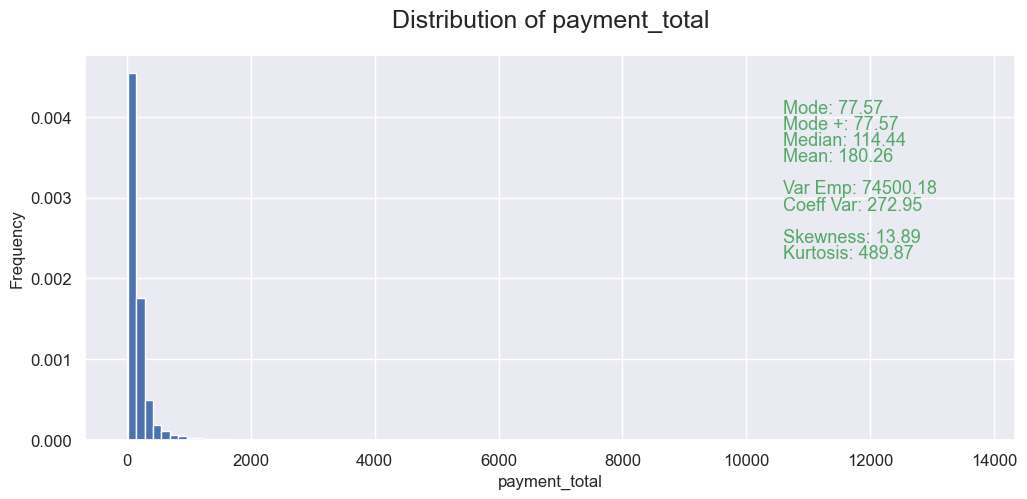

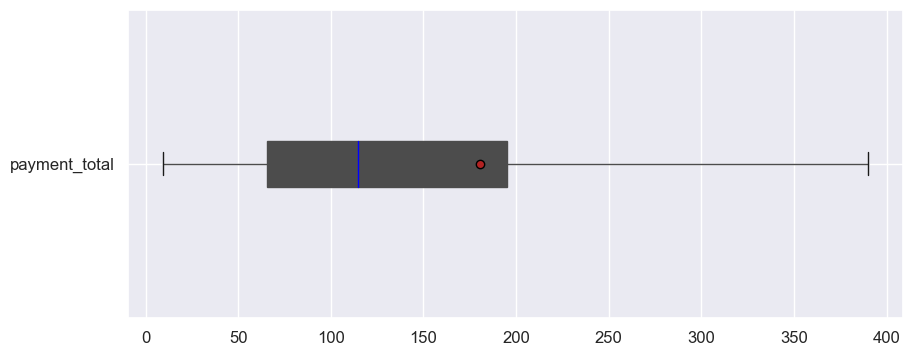

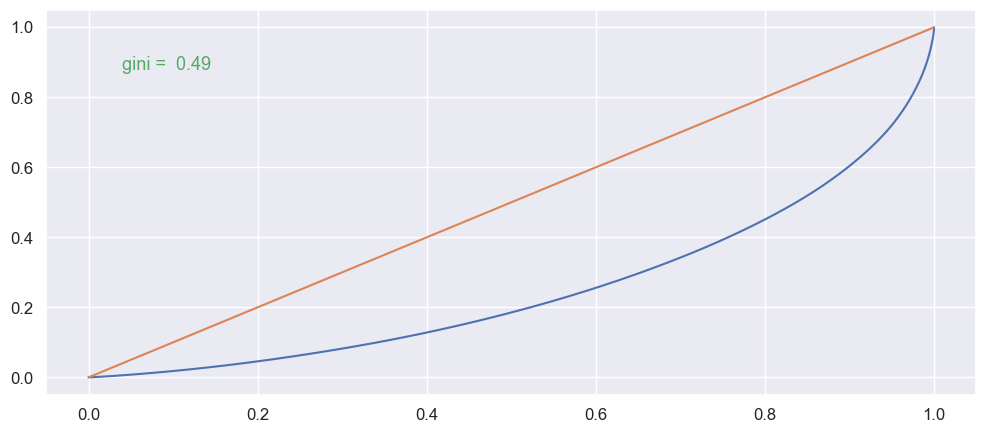

In [41]:
# "Analyser par exemple la distribution du nombre de commandes par client, la distribution des montants, 
# la distribution des catégories des produit etc." (consigne)

# nombre de commandes / client : voir plus loin, analyse fichier_clients

# distrib montants (/ commande, cf supra pour /client)
# ! Avec ce code la même commande sera affichée plusieurs fois si elle contient plusieurs articles.
# Car nous travaillons pour l'instant sur les commandes détaillées.

graphs_analyse_uni(detail_orders_file, 'payment_total', bins=100, r=2, density=True)


#### "gros" montants

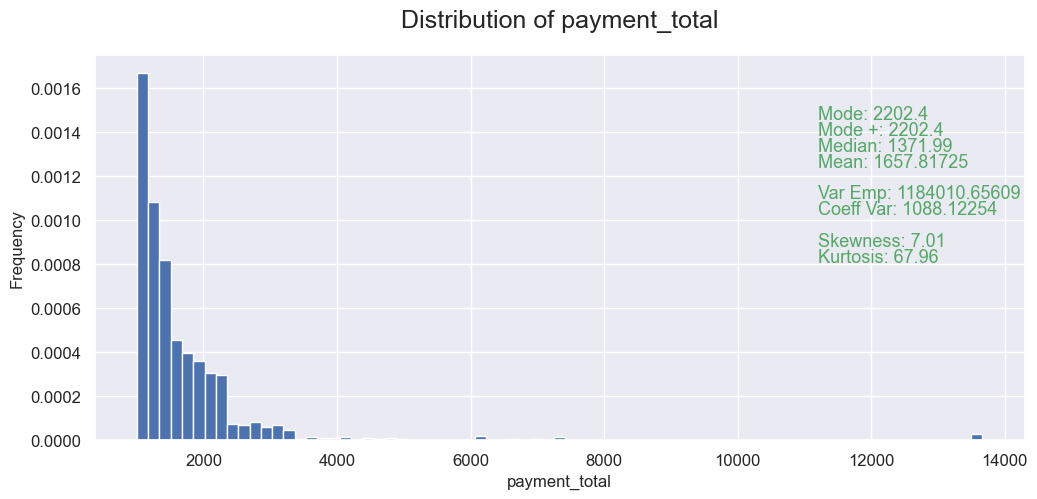

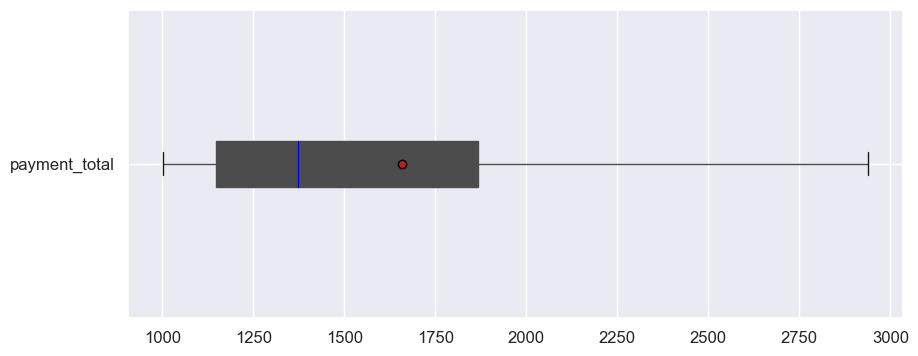

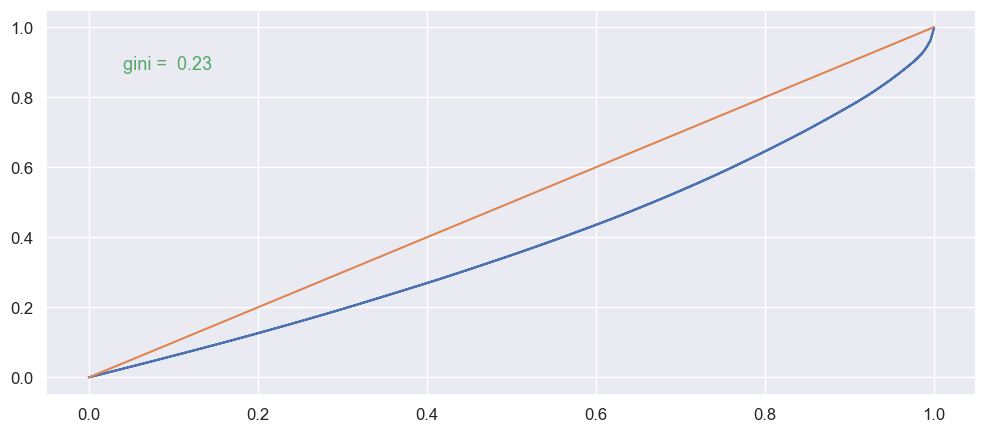

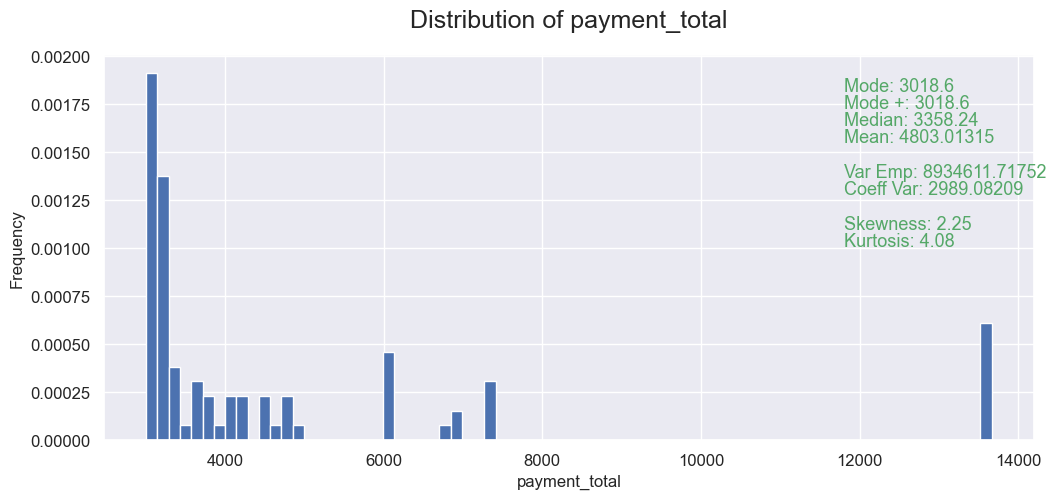

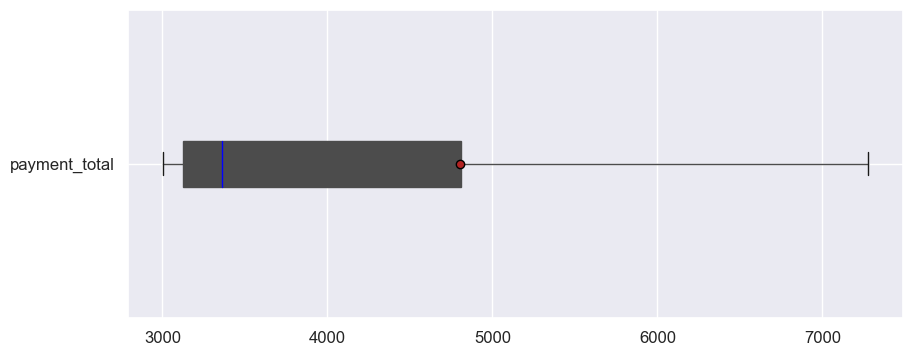

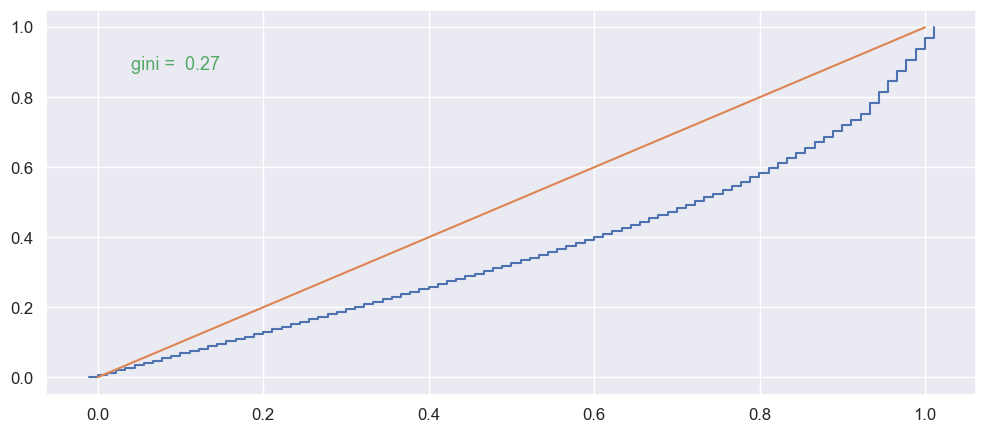

In [42]:
# On ne voit pas gd chose sur l'histogramme, trop de "petits montants" :

graphs_analyse_uni(detail_orders_file.loc[detail_orders_file['payment_total'] > 1000], 
                   'payment_total', bins=75, r=5, density=True)

graphs_analyse_uni(detail_orders_file.loc[detail_orders_file['payment_total'] > 3000], 
                   'payment_total', bins=75, r=5, density=True)


#### categories articles (quoi ds les paniers)

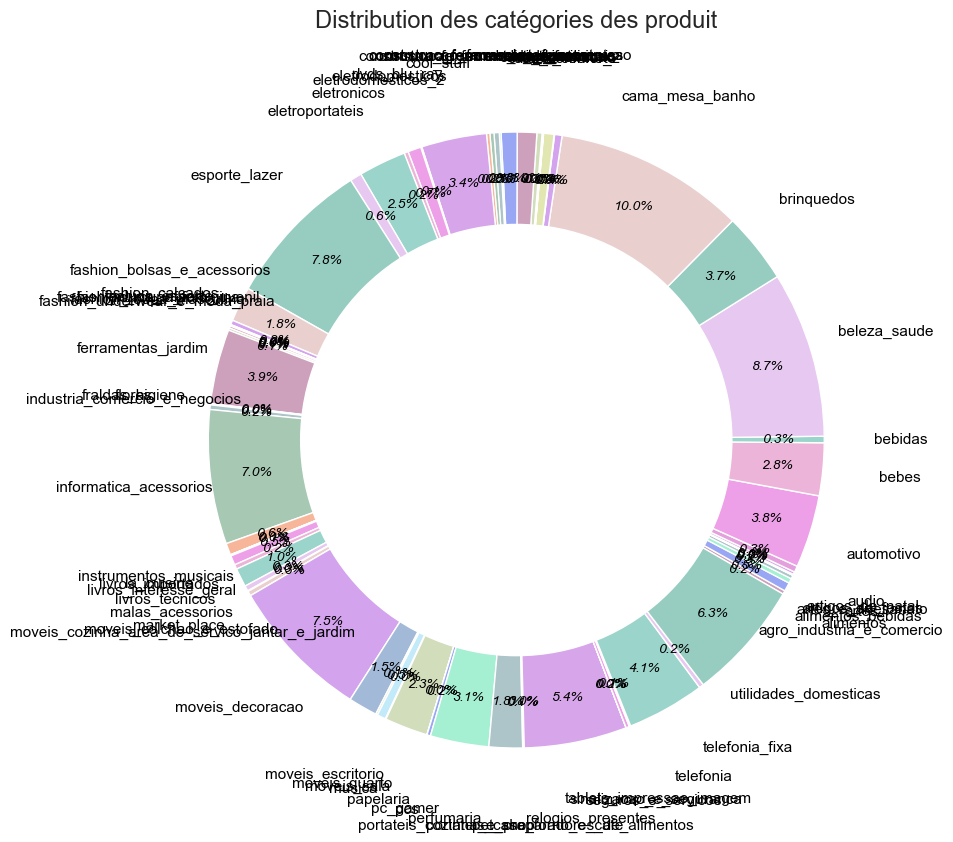

In [43]:
# Les disparités (distribution, + coeff de gini, courbe de Lorentz) tendent à diminuer quand on
# "zoom" sur les grosses commandes, puis elles réapparaissent chez les
# "ultra dépensiers", les meilleurs clients.

# la distribution des catégories des produit 
# Pour ça, ce dataframe commandes détaillées est parfait

doughnut(detail_orders_file, 'product_category_name', 'Distribution des catégories des produit')


<Axes: xlabel='product_category_name'>

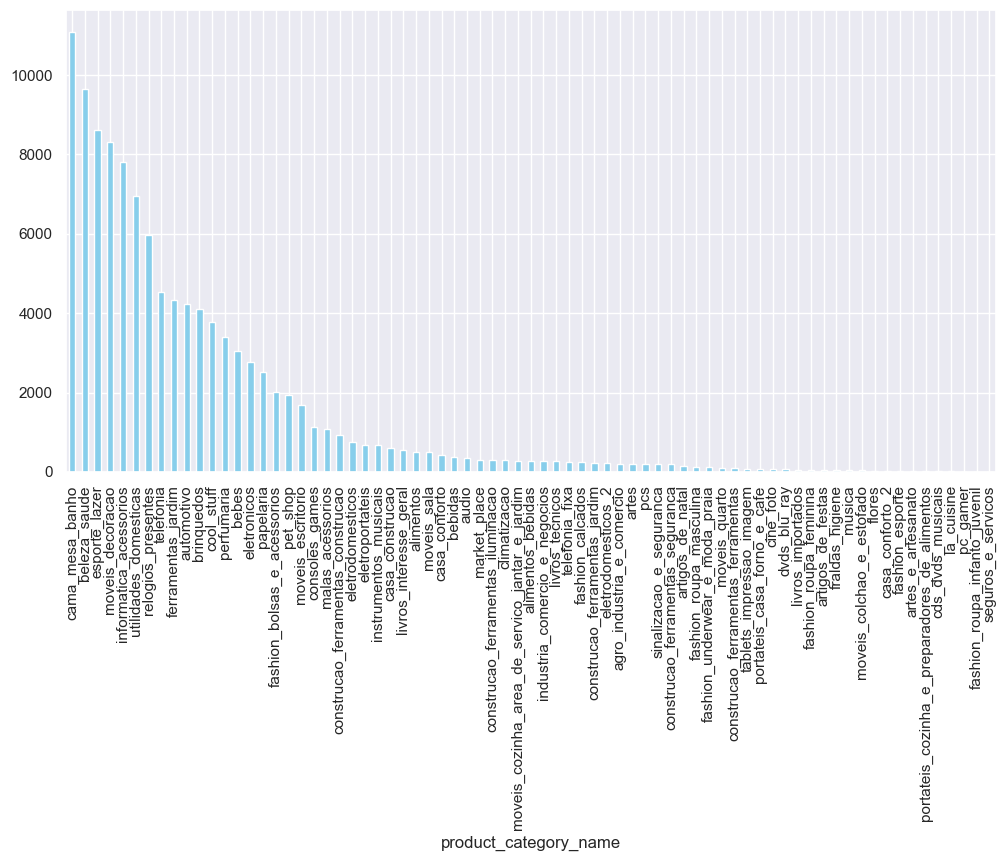

In [44]:
# mmm
# on doit pouvoir faire mieux

plt.figure(figsize=(12, 6))

detail_orders_file['product_category_name'].value_counts().plot(kind='bar', color='skyblue')


<Axes: xlabel='product_category_name_english'>

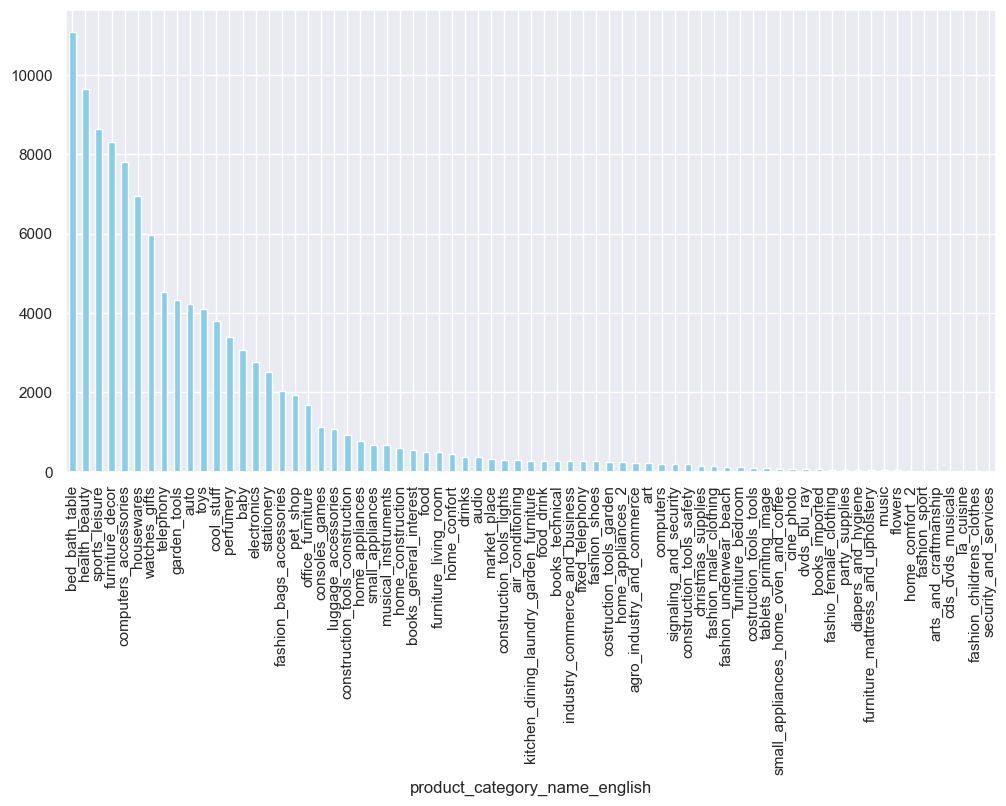

In [45]:
# en anglais

plt.figure(figsize=(12, 6))

detail_orders_file['product_category_name_english'].value_counts().plot(kind='bar', color='skyblue')


#### top 20 articles

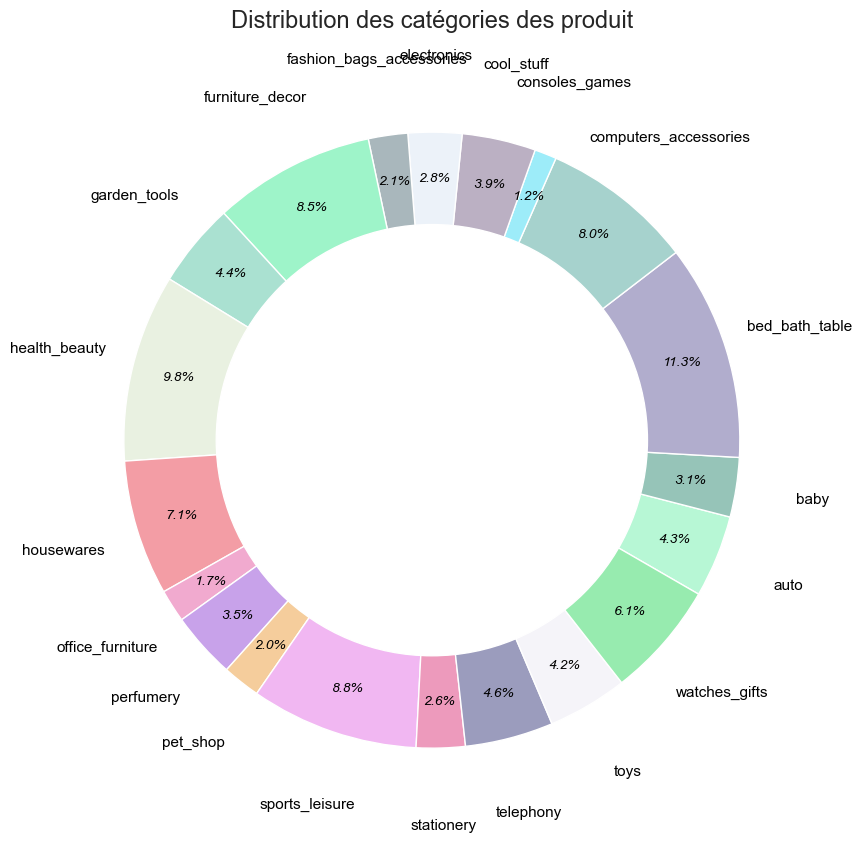

In [46]:
# On voit que ça a du sens ici de visualiser seulement les 20 meilleurs produits par exemple. (/71)
detail_orders_file['product_category_name_english'].nunique()

# Faisons un top 20
top_20_cat = detail_orders_file['product_category_name_english'].value_counts().head(20).index.tolist()
df_top_20 = detail_orders_file.loc[detail_orders_file['product_category_name_english'].isin(top_20_cat)]

doughnut(df_top_20, 'product_category_name_english', 'Distribution des catégories des produit')
# C déjà + lisible !

# Les gens achètent des trucs cools, des montres, des bébés, des téléphones, etc...


## 4 Création du fichier clients

In [47]:
# "Se concentrer dans un premier temps sur quelques features qui ont du sens du point de vue marketing, 
# pour cibler les clients plus ou moins intéressants en termes de vente : RFM"

# On retrouve le nb commandes / client

# tout d'abord, nous allons recompacter notre fichier géant (1 ligne /article)
# on veut repasser à 1 ligne / commande
# (et ensuite, 1 row / client)



# by='order_id'

# price becomes total_articles
# freight_value becomes total_frais
# for those 2 agg func is sum()

# order_purchase_timestamp should be the same for all articles in 1 order. check ?
# if not keep='first'
# maybe rename it shorter ?

# customer_unique_id doit etre le meme pour chaque commande.
# deja verif (clés) 
# idem state 

# payment_installments et les autres payment_something do not sum, they also stay as is 

# product_category_name not sure. concat ? keep first ? something simple, big dataframe.

# review score is already a mean, wont change even if we mean it again.



# Observons par commande :

display(detail_orders_file[detail_orders_file['order_id'].duplicated(keep=False)].sort_values(by='order_id').head(60))


order_id   price  freight_value  \
588   0008288aa423d2a3f00fcb17cd7d8719   49.90          13.37   
587   0008288aa423d2a3f00fcb17cd7d8719   49.90          13.37   
1311  00143d0f86d6fbd9f9b38ab440ac16f5   21.33          15.10   
1310  00143d0f86d6fbd9f9b38ab440ac16f5   21.33          15.10   
1309  00143d0f86d6fbd9f9b38ab440ac16f5   21.33          15.10   
1535  001ab0a7578dd66cd4b0a71f5b6e1e41   24.89          17.63   
1534  001ab0a7578dd66cd4b0a71f5b6e1e41   24.89          17.63   
1536  001ab0a7578dd66cd4b0a71f5b6e1e41   24.89          17.63   
1756  001d8f0e34a38c37f7dba2a37d4eba8b   18.99           7.78   
1757  001d8f0e34a38c37f7dba2a37d4eba8b   18.99           7.78   
2179  002c9def9c9b951b1bec6d50753c9891   78.00           8.90   
2178  002c9def9c9b951b1bec6d50753c9891   78.00           8.90   
2191  002f98c0f7efd42638ed6100ca699b42    8.99          32.57   
2200  002f98c0f7efd42638ed6100ca699b42   44.90           7.16   
2322  003324c70b19a16798817b2b3640e721  102.90          14.45   
2323  003324c70b19a16798817b2b3640e721  102.90          14.45   
2350  00337fe25a3780b3424d9ad7c5a4b35e   59.90           9.94   
2348  00337fe25a3780b3424d9ad7c5a4b35e   59.90           9.94   
2439  003822434f91204da0a51fe4cf2aba18   69.00          18.58   
2438  003822434f91204da0a51fe4cf2aba18   69.00          18.58   
2643  003f201cdd39cdd59b6447cff2195456   85.00          17.03   
2644  003f201cdd39cdd59b6447cff2195456   85.00          17.03   
1647  005059edee63c8c708ba61910793b31b   92.00          17.89   
1646  005059edee63c8c708ba61910793b31b   92.00          17.89   
4108  00526a9d4ebde463baee25f386963ddc   33.89           8.40   
4109  00526a9d4ebde463baee25f386963ddc   33.89           8.40   
4110  00526a9d4ebde463baee25f386963ddc   33.89           8.40   
4111  00526a9d4ebde463baee25f386963ddc   33.89           8.40   
4456  00571ded73b3c061925584feab0db425  179.90          15.01   
4455  00571ded73b3c061925584feab0db425  179.90          15.01   
4580  005d9a5423d47281ac463a968b3936fb   49.99          18.12   
4617  005d9a5423d47281ac463a968b3936fb   24.99          13.58   
4616  005d9a5423d47281ac463a968b3936fb   24.99          13.58   
4720  0068c109948b9a1dfb8530d1978acef3   35.90          15.79   
4721  0068c109948b9a1dfb8530d1978acef3   35.90          15.79   
5469  008d9bf350ff02ed444b3452cf3f57e0    9.99          15.23   
5470  008d9bf350ff02ed444b3452cf3f57e0    9.99          15.23   
5578  00946f674d880be1f188abc10ad7cf46   99.90          14.35   
5572  00946f674d880be1f188abc10ad7cf46   99.90          18.57   
5673  0097f0545a302aafa32782f1734ff71c  158.00          10.68   
5674  0097f0545a302aafa32782f1734ff71c  308.00          31.16   
5684  009905140e9f8cc35d5be897937381db   39.99          18.23   
5685  009905140e9f8cc35d5be897937381db   39.99          18.23   
6326  00a57dfbb049fbaae10763e2cf15f797   89.90          22.56   
6324  00a57dfbb049fbaae10763e2cf15f797   89.90          22.56   
6325  00a57dfbb049fbaae10763e2cf15f797   89.90          22.56   
7254  00b1861aeb89afa498404c684148a619   25.79          23.33   
7255  00b1861aeb89afa498404c684148a619   25.79          23.33   
7535  00b6e66f005a657a6b13eedcacdf9342  199.00          39.66   
7534  00b6e66f005a657a6b13eedcacdf9342  199.00          39.66   
8135  00bcee890eba57a9767c7b5ca12d3a1b  165.50          15.80   
8137  00bcee890eba57a9767c7b5ca12d3a1b  175.91          52.69   
8147  00bcee890eba57a9767c7b5ca12d3a1b  165.50          15.80   
8148  00bcee890eba57a9767c7b5ca12d3a1b  165.50          15.80   
8216  00c00d5b36157595e21108ba1da2828f  139.85          16.61   
8217  00c00d5b36157595e21108ba1da2828f  139.85          16.61   
8372  00c9f7d4b0e87781465e562dc109f6aa   14.99          15.10   
8374  00c9f7d4b0e87781465e562dc109f6aa   14.99          15.10   
8373  00c9f7d4b0e87781465e562dc109f6aa   14.99          15.10   
8375  00c9f7d4b0e87781465e562dc109f6aa   14.99          15.10   

     order_purchase_timestamp                customer_unique_id 

In [48]:
quick_look(detail_orders_file)


shape : (112344, 19)


order_id  price  freight_value  \
0  00010242fe8c5a6d1ba2dd792cb16214   58.9          13.29   
1  130898c0987d1801452a8ed92a670612   55.9          17.96   
2  532ed5e14e24ae1f0d735b91524b98b9   64.9          18.33   
3  6f8c31653edb8c83e1a739408b5ff750   58.9          16.17   
4  7d19f4ef4d04461989632411b7e588b9   58.9          13.29   

  order_purchase_timestamp                customer_unique_id  zipcode  \
0      2017-09-13 08:59:02  871766c5855e863f6eccc05f988b23cb    28013   
1      2017-06-28 11:52:20  0fb8e3eab2d3e79d92bb3fffbb97f188    75800   
2      2018-05-18 10:25:53  3419052c8c6b45daf79c1e426f9e9bcb    30720   
3      2017-08-01 18:38:42  e7c828d22c0682c1565252deefbe334d    83070   
4      2017-08-10 21:48:40  0bb98ba72dcc08e95f9d8cc434e9a2cc    36400   

  customer_state   latitude  longitude  payment_installments  payment_total  \
0             RJ -21.763186 -41.310265                     2          72.19   
1             GO -17.884803 -51.717167                     1          73.86   
2             MG -19.913964 -43.976106                     2          83.23   
3             PR -25.520334 -49.124988                     3          75.07   
4             MG -20.655379 -43.776331                     4          72.19   

   payment_type_credit_card  payment_type_boleto  payment_type_voucher  \
0                     72.19                 0.00                   0.0   
1                      0.00                73.86                   0.0   
2                     83.23                 0.00                   0.0   
3                     75.07                 0.00                   0.0   
4                     72.19                 0.00                   0.0   

   payment_type_debit_card  payment_type_not_defined product_category_name  \
0                      0.0                       0.0            cool_stuff   
1                      0.0                       0.0            cool_stuff   
2                      0.0                       0.0            cool_stuff   
3                      0.0                       0.0            cool_stuff   
4                      0.0                       0.0            cool_stuff   

   review_score product_category_name_english  
0           5.0                    cool_stuff  
1           5.0                    cool_stuff  
2           4.0                    cool_stuff  
3           5.0                    cool_stuff  
4           5.0                    cool_stuff

order_id  price  freight_value  \
112339  ffebd80e3291e811c308365936897efd  129.9          51.20   
112340  ffee31fb4b5e35c9123608015637c495   99.0          13.52   
112341  fff7c4452f050315db1b3f24d9df5fcd  736.0          20.91   
112342  fffa82886406ccf10c7b4e35c4ff2788  229.9          44.02   
112343  fffe41c64501cc87c801fd61db3f6244   43.0          12.79   

       order_purchase_timestamp                customer_unique_id  zipcode  \
112339      2018-07-13 20:04:05  a1c2e4b4c1b29e41684ebdf3cc6538f8    28740   
112340      2018-08-18 10:00:59  4e15fee963523774998876e3624952f4    83065   
112341      2017-06-01 16:53:03  c86ab5ff2bac777c4e770a383feca4eb    27261   
112342      2017-12-18 16:33:07  2a3ab9bf9639491997586882c502540a    59955   
112343      2018-06-09 17:00:18  cd76a00d8e3ca5e6ab9ed9ecb6667ac4    18605   

       customer_state   latitude  longitude  payment_installments  \
112339             RJ -22.087256 -41.867524                     1   
112340             PR -25.512617 -49.160863                     2   
112341             RJ -22.523608 -44.102280                     1   
112342             RN  -6.464059 -38.179981                     7   
112343             SP -22.916837 -48.441730                     1   

        payment_total  payment_type_credit_card  payment_type_boleto  \
112339         181.10                    181.10                  0.0   
112340         112.52                    112.52                  0.0   
112341         756.91                    756.91                  0.0   
112342         273.92                    273.92                  0.0   
112343          55.79                     55.79                  0.0   

        payment_type_voucher  payment_type_debit_card  \
112339                   0.0                      0.0   
112340                   0.0                      0.0   
112341                   0.0                      0.0   
112342                   0.0                      0.0   
112343                   0.0                      0.0   

        payment_type_not_defined product_category_name  review_score  \
112339                       0.0    ferramentas_jardim           5.0   
112340                       0.0      moveis_decoracao           4.0   
112341                       0.0    relogios_presentes           5.0   
112342                       0.0         esporte_lazer           4.0   
112343                       0.0       cama_mesa_banho           5.0   

       product_category_name_english  
112339                  garden_tools  
112340               furniture_decor  
112341                 watches_gifts  
112342                sports_leisure  
112343                bed_bath_table

uniques :


order_id                         98390
price                             5957
freight_value                     6993
order_purchase_timestamp         97840
customer_unique_id               95155
zipcode                          14820
customer_state                      27
latitude                         14820
longitude                        14820
payment_installments                28
payment_total                    27815
payment_type_credit_card         25290
payment_type_boleto              10455
payment_type_voucher              2756
payment_type_debit_card           1378
payment_type_not_defined             1
product_category_name               73
review_score                        11
product_category_name_english       71
dtype: int64

Doublons ?  11015 



column_name  missing  \
order_id                                            order_id        0   
payment_type_not_defined            payment_type_not_defined        0   
payment_type_debit_card              payment_type_debit_card        0   
payment_type_voucher                    payment_type_voucher        0   
payment_type_boleto                      payment_type_boleto        0   
payment_type_credit_card            payment_type_credit_card        0   
payment_total                                  payment_total        0   
longitude                                          longitude        0   
payment_installments                    payment_installments        0   
customer_state                                customer_state        0   
zipcode                                              zipcode        0   
customer_unique_id                        customer_unique_id        0   
order_purchase_timestamp            order_purchase_timestamp        0   
freight_value                                  freight_value        0   
price                                                  price        0   
latitude                                            latitude        0   
review_score                                    review_score      941   
product_category_name                  product_category_name     1597   
product_category_name_english  product_category_name_english     1621   

                               present  percent_missing            type  
order_id                        112344             0.00          object  
payment_type_not_defined        112344             0.00         float64  
payment_type_debit_card         112344             0.00         float64  
payment_type_voucher            112344             0.00         float64  
payment_type_boleto             112344             0.00         float64  
payment_type_credit_card        112344             0.00         float64  
payment_total                   112344             0.00         float64  
longitude                       112344             0.00         float64  
payment_installments            112344             0.00           int64  
customer_state                  112344             0.00          object  
zipcode                         112344             0.00           int64  
customer_unique_id              112344             0.00          object  
order_purchase_timestamp        112344             0.00  datetime64[ns]  
freight_value                   112344             0.00         float64  
price                           112344             0.00         float64  
latitude                        112344             0.00         float64  
review_score                    111403             0.84         float64  
product_category_name           110747             1.42          object  
product_category_name_english   110723             1.44          object

### Aggrégation

In [49]:
# Group by 'order_id' and aggregate the data

fichier_par_commande = detail_orders_file.groupby('order_id').agg({
    'price': 'sum',  # Rename to 'total_articles'
    'freight_value': 'sum',  # Rename to 'total_frais'
    'order_purchase_timestamp': 'first',  # Keep the first timestamp
    'customer_unique_id': 'first',  # Make sure it's the same for each order
    'customer_state': 'first',  # Make sure it's the same for each order
    'payment_installments': 'first',  # Keep the first value
    'payment_total': 'first',  # Keep the first value or use an appropriate aggregation
    'payment_type_credit_card': 'first',  # Keep the first value or use an appropriate aggregation
    'payment_type_boleto': 'first',  # Keep the first value or use an appropriate aggregation
    'payment_type_voucher': 'first',  # Keep the first value or use an appropriate aggregation
    'payment_type_debit_card': 'first',  # Keep the first value or use an appropriate aggregation
    'payment_type_not_defined': 'first',  # Keep the first value or use an appropriate aggregation
    'product_category_name': 'first',  # Keep the first category or use an appropriate aggregation
    'review_score': 'mean',  # Calculate the mean review score
    'product_category_name_english': 'first',  # Keep the first category or use an appropriate aggregation
    'latitude': 'first',  # Keep the first category or use an appropriate aggregation
    'longitude': 'first',  # Keep the first category or use an appropriate aggregation
})

quick_look(fichier_par_commande)
fichier_par_commande.describe()

# On retrouve bien shape0 = 98664 (ou 98390 si seulement client localisables)


shape : (98390, 17)


price  freight_value  \
order_id                                                  
00010242fe8c5a6d1ba2dd792cb16214   58.90          13.29   
00018f77f2f0320c557190d7a144bdd3  239.90          19.93   
000229ec398224ef6ca0657da4fc703e  199.00          17.87   
00024acbcdf0a6daa1e931b038114c75   12.99          12.79   
00042b26cf59d7ce69dfabb4e55b4fd9  199.90          18.14   

                                 order_purchase_timestamp  \
order_id                                                    
00010242fe8c5a6d1ba2dd792cb16214      2017-09-13 08:59:02   
00018f77f2f0320c557190d7a144bdd3      2017-04-26 10:53:06   
000229ec398224ef6ca0657da4fc703e      2018-01-14 14:33:31   
00024acbcdf0a6daa1e931b038114c75      2018-08-08 10:00:35   
00042b26cf59d7ce69dfabb4e55b4fd9      2017-02-04 13:57:51   

                                                customer_unique_id  \
order_id                                                             
00010242fe8c5a6d1ba2dd792cb16214  871766c5855e863f6eccc05f988b23cb   
00018f77f2f0320c557190d7a144bdd3  eb28e67c4c0b83846050ddfb8a35d051   
000229ec398224ef6ca0657da4fc703e  3818d81c6709e39d06b2738a8d3a2474   
00024acbcdf0a6daa1e931b038114c75  af861d436cfc08b2c2ddefd0ba074622   
00042b26cf59d7ce69dfabb4e55b4fd9  64b576fb70d441e8f1b2d7d446e483c5   

                                 customer_state  payment_installments  \
order_id                                                                
00010242fe8c5a6d1ba2dd792cb16214             RJ                     2   
00018f77f2f0320c557190d7a144bdd3             SP                     3   
000229ec398224ef6ca0657da4fc703e             MG                     5   
00024acbcdf0a6daa1e931b038114c75             SP                     2   
00042b26cf59d7ce69dfabb4e55b4fd9             SP                     3   

                                  payment_total  payment_type_credit_card  \
order_id                                                                    
00010242fe8c5a6d1ba2dd792cb16214          72.19                     72.19   
00018f77f2f0320c557190d7a144bdd3         259.83                    259.83   
000229ec398224ef6ca0657da4fc703e         216.87                    216.87   
00024acbcdf0a6daa1e931b038114c75          25.78                     25.78   
00042b26cf59d7ce69dfabb4e55b4fd9         218.04                    218.04   

                                  payment_type_boleto  payment_type_voucher  \
order_id                                                                      
00010242fe8c5a6d1ba2dd792cb16214                  0.0                   0.0   
00018f77f2f0320c557190d7a144bdd3                  0.0                   0.0   
000229ec398224ef6ca0657da4fc703e                  0.0                   0.0   
00024acbcdf0a6daa1e931b038114c75                  0.0                   0.0   
00042b26cf59d7ce69dfabb4e55b4fd9                  0.0                   0.0   

                                  payment_type_debit_card  \
order_id                                                    
00010242fe8c5a6d1ba2dd792cb16214                      0.0   
00018f77f2f0320c557190d7a144bdd3                      0.0   
000229ec398224ef6ca0657da4fc703e                      0.0   
00024acbcdf0a6daa1e931b038114c75                      0.0   
00042b26cf59d7ce69dfabb4e55b4fd9                      0.0   

                                  payment_type_not_defined  \
order_id                                                     
00010242fe8c5a6d1ba2dd792cb16214                       0.0   
00018f77f2f0320c557190d7a144bdd3                       0.0   
000229ec398224ef6ca0657da4fc703e                       0.0   
00024acbcdf0a6daa1e931b038114c75                       0.0   
00042b26cf59d7ce69dfabb4e55b4fd9                       0.0   

                                 product_category_name  review_score  \
order_id                                                               
00010242fe8c5a6d1ba2dd792cb16214            cool_stuff           5.0   
00018f77f2f0320c5

price  freight_value  \
order_id                                                  
fffc94f6ce00a00581880bf54a75a037  299.99          43.41   
fffcd46ef2263f404302a634eb57f7eb  350.00          36.53   
fffce4705a9662cd70adb13d4a31832d   99.90          16.95   
fffe18544ffabc95dfada21779c9644f   55.99           8.72   
fffe41c64501cc87c801fd61db3f6244   43.00          12.79   

                                 order_purchase_timestamp  \
order_id                                                    
fffc94f6ce00a00581880bf54a75a037      2018-04-23 13:57:06   
fffcd46ef2263f404302a634eb57f7eb      2018-07-14 10:26:46   
fffce4705a9662cd70adb13d4a31832d      2017-10-23 17:07:56   
fffe18544ffabc95dfada21779c9644f      2017-08-14 23:02:59   
fffe41c64501cc87c801fd61db3f6244      2018-06-09 17:00:18   

                                                customer_unique_id  \
order_id                                                             
fffc94f6ce00a00581880bf54a75a037  0c9aeda10a71f369396d0c04dce13a64   
fffcd46ef2263f404302a634eb57f7eb  0da9fe112eae0c74d3ba1fe16de0988b   
fffce4705a9662cd70adb13d4a31832d  cd79b407828f02fdbba457111c38e4c4   
fffe18544ffabc95dfada21779c9644f  eb803377c9315b564bdedad672039306   
fffe41c64501cc87c801fd61db3f6244  cd76a00d8e3ca5e6ab9ed9ecb6667ac4   

                                 customer_state  payment_installments  \
order_id                                                                
fffc94f6ce00a00581880bf54a75a037             MA                     1   
fffcd46ef2263f404302a634eb57f7eb             PR                     1   
fffce4705a9662cd70adb13d4a31832d             SP                     3   
fffe18544ffabc95dfada21779c9644f             SP                     3   
fffe41c64501cc87c801fd61db3f6244             SP                     1   

                                  payment_total  payment_type_credit_card  \
order_id                                                                    
fffc94f6ce00a00581880bf54a75a037         343.40                      0.00   
fffcd46ef2263f404302a634eb57f7eb         386.53                      0.00   
fffce4705a9662cd70adb13d4a31832d         116.85                    116.85   
fffe18544ffabc95dfada21779c9644f          64.71                     64.71   
fffe41c64501cc87c801fd61db3f6244          55.79                     55.79   

                                  payment_type_boleto  payment_type_voucher  \
order_id                                                                      
fffc94f6ce00a00581880bf54a75a037               343.40                   0.0   
fffcd46ef2263f404302a634eb57f7eb               386.53                   0.0   
fffce4705a9662cd70adb13d4a31832d                 0.00                   0.0   
fffe18544ffabc95dfada21779c9644f                 0.00                   0.0   
fffe41c64501cc87c801fd61db3f6244                 0.00                   0.0   

                                  payment_type_debit_card  \
order_id                                                    
fffc94f6ce00a00581880bf54a75a037                      0.0   
fffcd46ef2263f404302a634eb57f7eb                      0.0   
fffce4705a9662cd70adb13d4a31832d                      0.0   
fffe18544ffabc95dfada21779c9644f                      0.0   
fffe41c64501cc87c801fd61db3f6244                      0.0   

                                  payment_type_not_defined  \
order_id                                                     
fffc94f6ce00a00581880bf54a75a037                       0.0   
fffcd46ef2263f404302a634eb57f7eb                       0.0   
fffce4705a9662cd70adb13d4a31832d                       0.0   
fffe18544ffabc95dfada21779c9644f                       0.0   
fffe41c64501cc87c801fd61db3f6244                       0.0   

                                   product_category_name  review_score  \
order_id                                                                 
fffc94f6ce00a00581880bf54a75a037   utilidades_domesticas           5.0   
fffcd46ef22

uniques :


price                             7744
freight_value                     7961
order_purchase_timestamp         97840
customer_unique_id               95155
customer_state                      27
payment_installments                28
payment_total                    27815
payment_type_credit_card         25290
payment_type_boleto              10455
payment_type_voucher              2756
payment_type_debit_card           1378
payment_type_not_defined             1
product_category_name               73
review_score                        11
product_category_name_english       71
latitude                         14820
longitude                        14820
dtype: int64

Doublons ?  34 



column_name  missing  \
price                                                  price        0   
payment_type_not_defined            payment_type_not_defined        0   
payment_type_debit_card              payment_type_debit_card        0   
payment_type_voucher                    payment_type_voucher        0   
latitude                                            latitude        0   
payment_type_credit_card            payment_type_credit_card        0   
payment_type_boleto                      payment_type_boleto        0   
payment_installments                    payment_installments        0   
customer_state                                customer_state        0   
customer_unique_id                        customer_unique_id        0   
order_purchase_timestamp            order_purchase_timestamp        0   
freight_value                                  freight_value        0   
payment_total                                  payment_total        0   
longitude                                          longitude        0   
review_score                                    review_score      748   
product_category_name                  product_category_name     1383   
product_category_name_english  product_category_name_english     1404   

                               present  percent_missing            type  
price                            98390             0.00         float64  
payment_type_not_defined         98390             0.00         float64  
payment_type_debit_card          98390             0.00         float64  
payment_type_voucher             98390             0.00         float64  
latitude                         98390             0.00         float64  
payment_type_credit_card         98390             0.00         float64  
payment_type_boleto              98390             0.00         float64  
payment_installments             98390             0.00           int64  
customer_state                   98390             0.00          object  
customer_unique_id               98390             0.00          object  
order_purchase_timestamp         98390             0.00  datetime64[ns]  
freight_value                    98390             0.00         float64  
payment_total                    98390             0.00         float64  
longitude                        98390             0.00         float64  
review_score                     97642             0.76         float64  
product_category_name            97007             1.41          object  
product_category_name_english    96986             1.43          object

price  freight_value       order_purchase_timestamp  \
count  98390.000000   98390.000000                          98390   
mean     137.753631      22.818824  2017-12-31 21:30:40.930989312   
min        0.850000       0.000000            2016-09-04 21:15:19   
25%       45.900000      13.832500            2017-09-12 23:02:01   
50%       86.900000      17.170000     2018-01-19 17:27:10.500000   
75%      149.900000      24.037500  2018-05-04 20:05:35.249999872   
max    13440.000000    1794.960000            2018-08-29 15:00:37   
std      210.697529      21.660108                            NaN   

       payment_installments  payment_total  payment_type_credit_card  \
count          98390.000000   98390.000000              98390.000000   
mean               2.982112     160.601628                126.052315   
min                0.000000       9.590000                  0.000000   
25%                1.000000      61.990000                 24.420000   
50%                2.000000     105.290000                 77.570000   
75%                4.000000     176.870000                154.137500   
max               29.000000   13664.080000              13664.080000   
std                2.741237     220.538700                207.062778   

       payment_type_boleto  payment_type_voucher  payment_type_debit_card  \
count         98390.000000          98390.000000             98390.000000   
mean             28.790161              3.573339                 2.185813   
min               0.000000              0.000000                 0.000000   
25%               0.000000              0.000000                 0.000000   
50%               0.000000              0.000000                 0.000000   
75%               0.000000              0.000000                 0.000000   
max            7274.880000           1839.050000              4445.500000   
std             111.338531             28.957576                34.536405   

       payment_type_not_defined  review_score      latitude     longitude  
count                   98390.0  97642.000000  98390.000000  98390.000000  
mean                        0.0      4.105033    -21.187535    -46.172997  
min                         0.0      1.000000    -33.689890    -72.668821  
25%                         0.0      4.000000    -23.589417    -48.102823  
50%                         0.0      5.000000    -22.924079    -46.630097  
75%                         0.0      5.000000    -20.139309    -43.592658  
max                         0.0      5.000000     42.184003     -8.723762  
std                         0.0      1.330276      5.612944      4.058452

### Evolution du volume des ventes

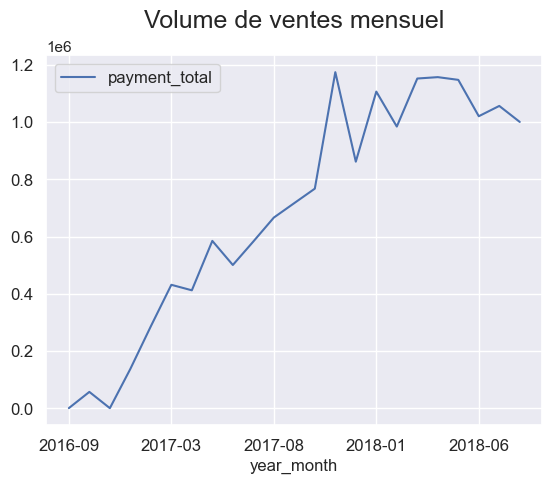

In [50]:
# Toujours pas de valeurs aberrantes

commandes = fichier_par_commande.copy()

# par mois 
commandes['year_month'] = commandes['order_purchase_timestamp'].map(lambda dt: dt.strftime('%Y-%m'))
grouped_commandes_month = commandes.groupby('year_month')['payment_total'].sum().reset_index()

grouped_commandes_month.plot(kind='line', x='year_month', y='payment_total', fontsize=12)
plt.title('Volume de ventes mensuel', fontsize=18, pad=20)
plt.legend(loc='upper left', fontsize=12)
# plt.xlim(grouped_df_month['month'].min(), grouped_df_month['month'].max())
plt.show()


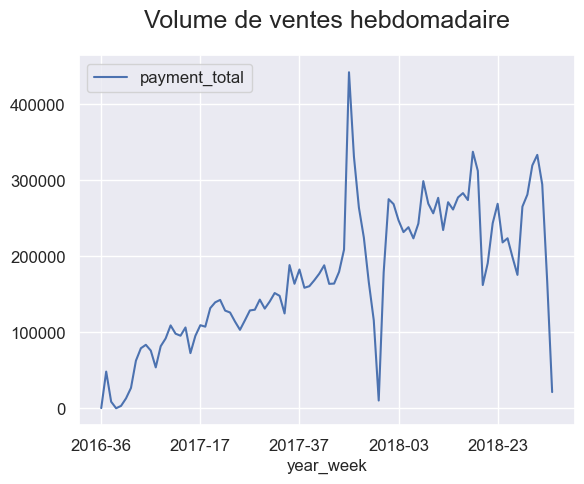

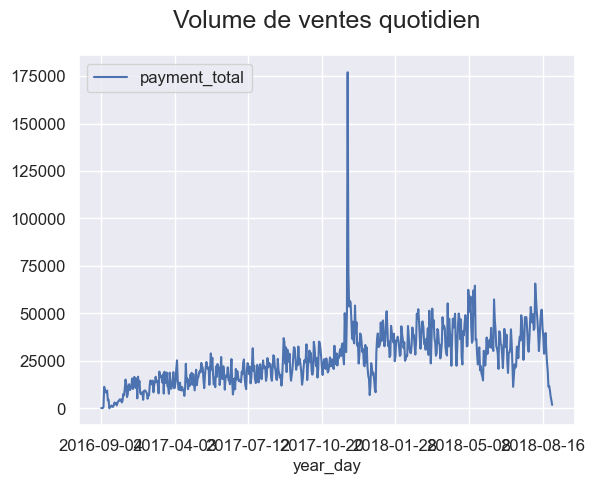

In [51]:
# par semaine
commandes['year_week'] = commandes['order_purchase_timestamp'].map(lambda dt: dt.strftime('%Y-%U'))
grouped_commandes_week = commandes.groupby('year_week')['payment_total'].sum().reset_index()

grouped_commandes_week.plot(kind='line', x='year_week', y='payment_total', fontsize=12)
plt.title('Volume de ventes hebdomadaire', fontsize=18, pad=20)
plt.legend(loc='upper left', fontsize=12)
plt.show()

# par jour
commandes['year_day'] = commandes['order_purchase_timestamp'].map(lambda dt: dt.strftime('%Y-%m-%d'))
grouped_commandes_day = commandes.groupby('year_day')['payment_total'].sum().reset_index()

grouped_commandes_day.plot(kind='line', x='year_day', y='payment_total', fontsize=12)
plt.title('Volume de ventes quotidien', fontsize=18, pad=20)
plt.legend(loc='upper left', fontsize=12)
plt.show()


### Evolution du panier moyen, semaine par semaine

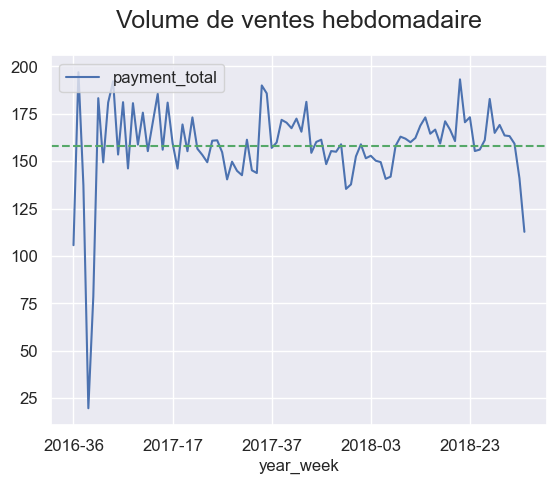

In [52]:
grouped_commandes_week_average_bucket = commandes.groupby('year_week')['payment_total'].mean().reset_index()

total_mean = grouped_commandes_week_average_bucket['payment_total'].mean()

grouped_commandes_week_average_bucket.plot(kind='line', x='year_week', y='payment_total', fontsize=12)
plt.title('Volume de ventes hebdomadaire', fontsize=18, pad=20)
plt.legend(loc='upper left', fontsize=12)
plt.axhline(total_mean, color='g', linestyle='--', label=f'Total Period Mean: {total_mean:.2f}', linewidth=1.5)
plt.show()


### RFM

In [53]:
# nouvelle variable : nb de commandes (/client)

# variables conservees (agg) :
# payment_total (sum)
# most recent order (keep=last ? sort before ?)

# Nouvelle variable : nb de commandes par client
nb_commandes = fichier_par_commande.groupby('customer_unique_id').size().reset_index(name='nb_commandes')

rfm = fichier_par_commande.groupby('customer_unique_id').agg({
    'payment_total': 'sum',
    'order_purchase_timestamp': 'max',
    'price': 'sum',  # Rename to 'total_articles'
    'freight_value': 'sum',  # Rename to 'total_frais'
    'latitude': 'first',  # Keep the first category or use an appropriate aggregation
    'longitude': 'first',  # Keep the first category or use an appropriate aggregation

    'review_score': 'mean',  # ???
    }).reset_index()

# Renommez la colonne 'date' 
rfm = rfm.rename(columns={'order_purchase_timestamp': 'most_recent_order',
                          'price': 'prix_articles',
                          'freight_value': 'frais_transport',
                          })

# Merge 'nb_commandes' with 'rfm' based on 'customer_unique_id'
rfm_df = rfm.merge(nb_commandes, on='customer_unique_id')

quick_look(rfm_df)

# uniques : customer_unique_id    95 419
# on est toujours très proche des 96 096 valeurs uniques de départ,
# apres un très léger nettoyage.

print(rfm_df.loc[rfm_df['nb_commandes'] > 1, :].shape[0])
# Nos 3% st tjs la

rfm_df.describe()


shape : (95155, 9)


customer_unique_id  payment_total   most_recent_order  \
0  0000366f3b9a7992bf8c76cfdf3221e2         141.90 2018-05-10 10:56:27   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          27.19 2018-05-07 11:11:27   
2  0000f46a3911fa3c0805444483337064          86.22 2017-03-10 21:05:03   
3  0000f6ccb0745a6a4b88665a16c9f078          43.62 2017-10-12 20:29:41   
4  0004aac84e0df4da2b147fca70cf8255         196.89 2017-11-14 19:45:42   

   prix_articles  frais_transport   latitude  longitude  review_score  \
0         129.90            12.00 -23.340262 -46.831085           5.0   
1          18.90             8.29 -23.559044 -46.788516           4.0   
2          69.00            17.22 -27.543010 -48.634938           3.0   
3          25.99            17.63  -1.312726 -48.482748           4.0   
4         180.00            16.89 -23.505588 -47.469820           5.0   

   nb_commandes  
0             1  
1             1  
2             1  
3             1  
4             1

customer_unique_id  payment_total   most_recent_order  \
95150  fffcf5a5ff07b0908bd4e2dbc735a684        2067.42 2017-06-08 21:00:36   
95151  fffea47cd6d3cc0a88bd621562a9d061          84.58 2017-12-10 20:07:56   
95152  ffff371b4d645b6ecea244b27531430a         112.46 2017-02-07 15:49:16   
95153  ffff5962728ec6157033ef9805bacc48         133.69 2018-05-02 15:17:41   
95154  ffffd2657e2aad2907e67c3e9daecbeb          71.56 2017-05-02 20:18:45   

       prix_articles  frais_transport   latitude  longitude  review_score  \
95150        1570.00           497.42  -8.362654 -36.562103           5.0   
95151          64.89            19.69 -12.217900 -38.959237           4.0   
95152          89.90            22.56 -11.834705 -55.508145           5.0   
95153         115.00            18.69 -21.126170 -41.672396           5.0   
95154          56.99            14.57 -25.445705 -49.442463           5.0   

       nb_commandes  
95150             1  
95151             1  
95152             1  
95153             1  
95154             1

uniques :


customer_unique_id    95155
payment_total         28643
most_recent_order     94899
prix_articles          8598
frais_transport        8608
latitude              14810
longitude             14810
review_score             34
nb_commandes              9
dtype: int64

Doublons ?  0 



column_name  missing  present  percent_missing  \
customer_unique_id  customer_unique_id        0    95155             0.00   
payment_total            payment_total        0    95155             0.00   
most_recent_order    most_recent_order        0    95155             0.00   
prix_articles            prix_articles        0    95155             0.00   
frais_transport        frais_transport        0    95155             0.00   
latitude                      latitude        0    95155             0.00   
longitude                    longitude        0    95155             0.00   
nb_commandes              nb_commandes        0    95155             0.00   
review_score              review_score      698    94457             0.73   

                              type  
customer_unique_id          object  
payment_total              float64  
most_recent_order   datetime64[ns]  
prix_articles              float64  
frais_transport            float64  
latitude                   float64  
longitude                  float64  
nb_commandes                 int64  
review_score               float64

2903


payment_total              most_recent_order  prix_articles  \
count   95155.000000                          95155   95155.000000   
mean      166.061628  2018-01-03 02:39:29.978277376     142.436863   
min         9.590000            2016-09-04 21:15:19       0.850000   
25%        63.100000     2017-09-15 21:04:15.500000      47.900000   
50%       107.950000            2018-01-22 14:16:34      89.900000   
75%       183.210000     2018-05-07 09:31:50.500000     155.000000   
max     13664.080000            2018-08-29 15:00:37   13440.000000   
std       228.397145                            NaN     217.710398   

       frais_transport      latitude     longitude  review_score  nb_commandes  
count     95155.000000  95155.000000  95155.000000  94457.000000  95155.000000  
mean         23.594599    -21.176392    -46.171374      4.102441      1.033997  
min           0.000000    -33.689890    -72.668821      1.000000      1.000000  
25%          14.060000    -23.589343    -48.107742      4.000000      1.000000  
50%          17.600000    -22.923561    -46.630396      5.000000      1.000000  
75%          25.540000    -20.116453    -43.590217      5.000000      1.000000  
max        1794.960000     42.184003     -8.723762      5.000000     16.000000  
std          22.887248      5.625688      4.061708      1.326356      0.211216

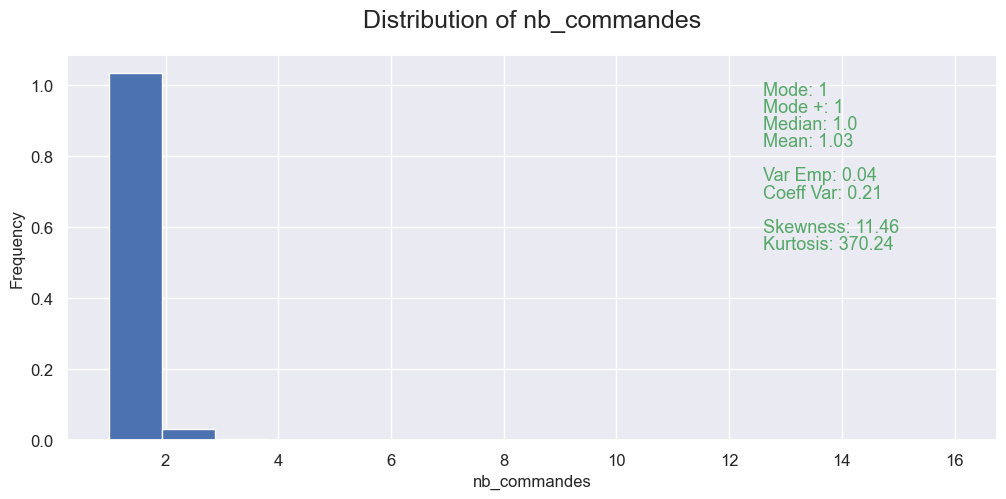

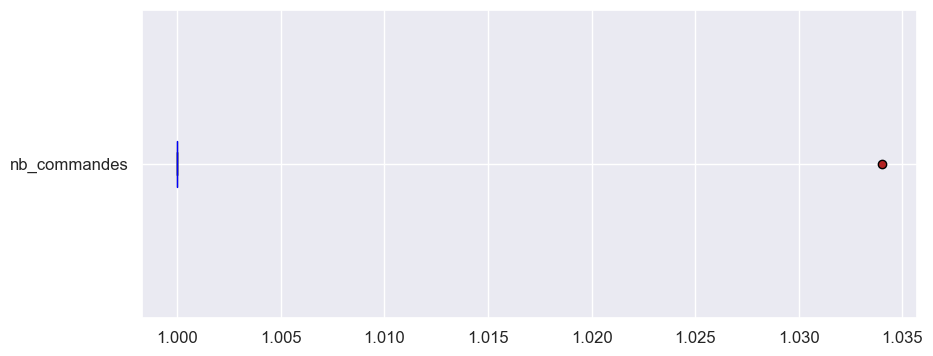

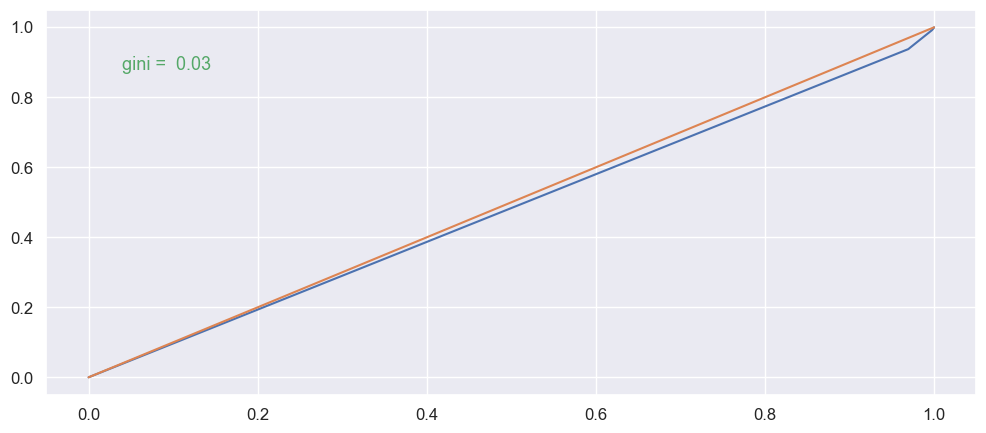

In [54]:
# Commençons par le F de RFM
# parce que pourquoi pas

graphs_analyse_uni(rfm_df, 'nb_commandes', bins=16, r=2, density=True)


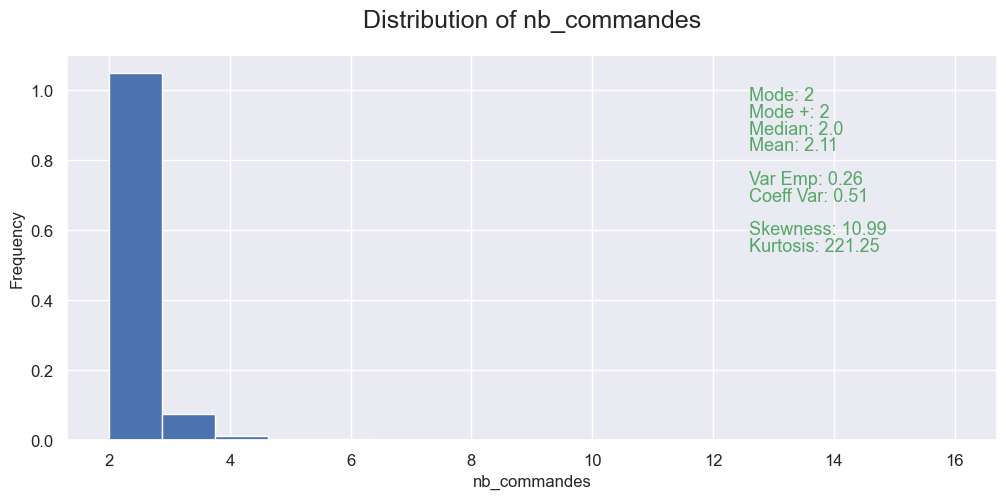

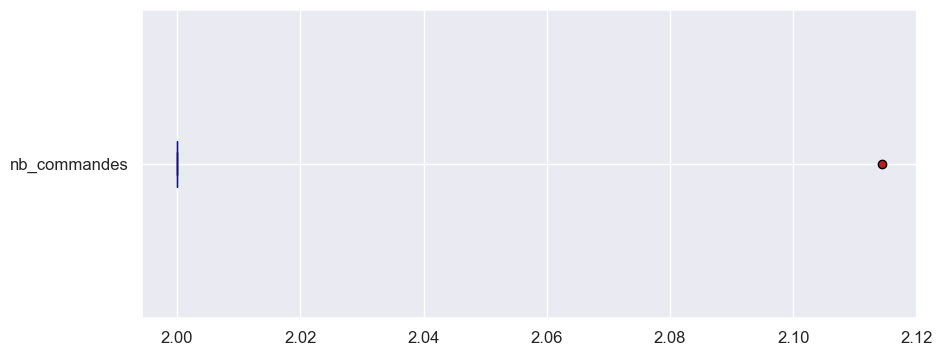

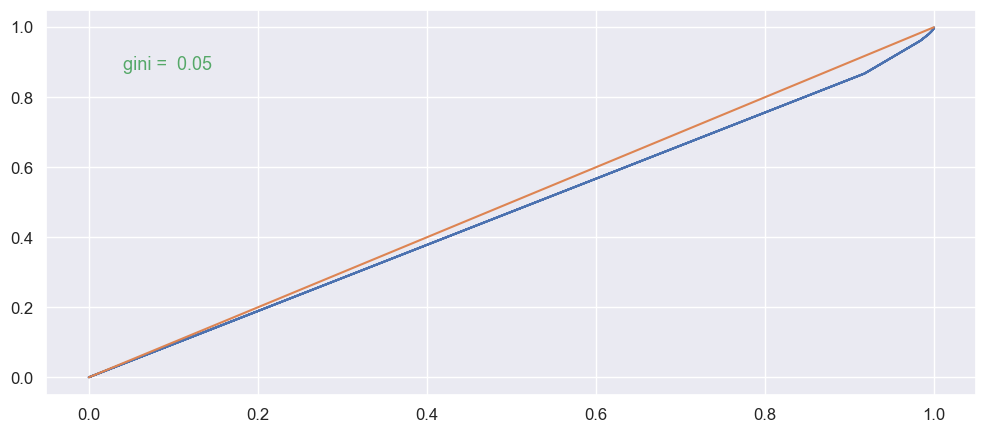

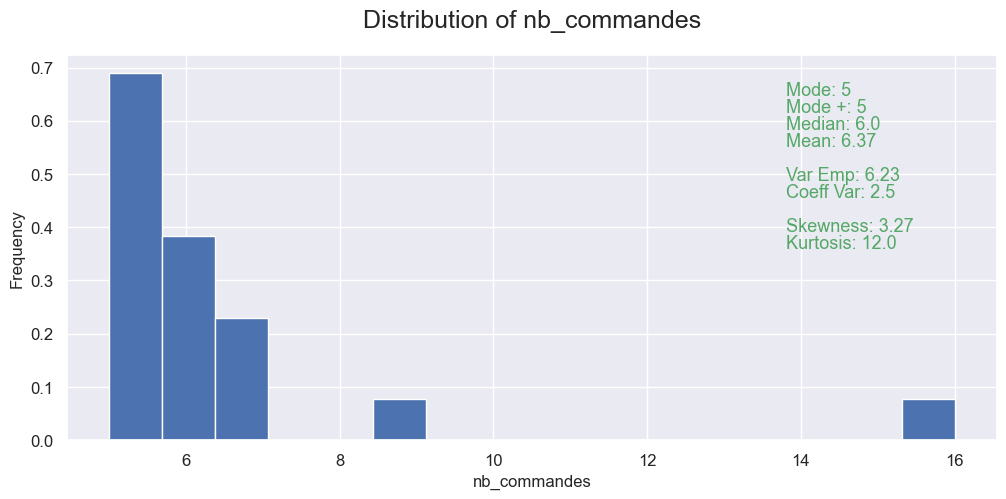

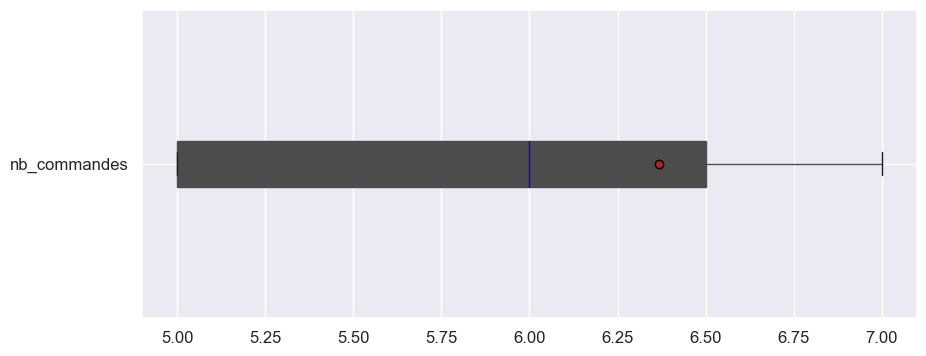

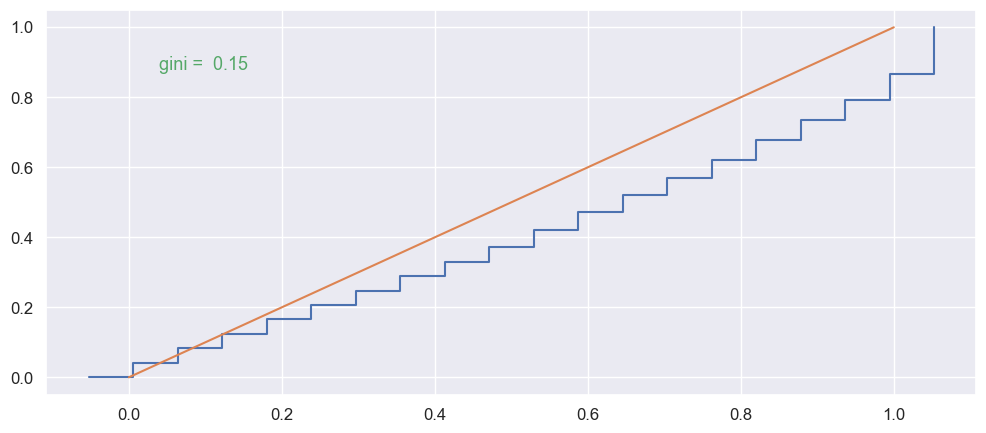

In [55]:
# Comme d'hab j'ai envie de dire

graphs_analyse_uni(rfm_df.loc[rfm_df['nb_commandes'] > 1], 
                   'nb_commandes', bins=16, r=2, density=True)


graphs_analyse_uni(rfm_df.loc[rfm_df['nb_commandes'] > 4], 
                   'nb_commandes', bins=16, r=2, density=True)


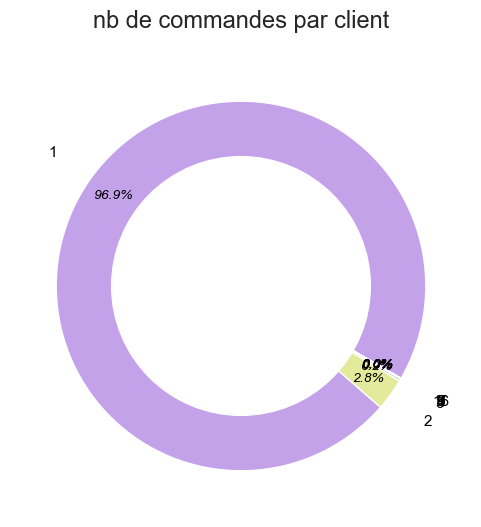

In [56]:
doughnut(rfm_df, 'nb_commandes', 'nb de commandes par client', 6, 6)


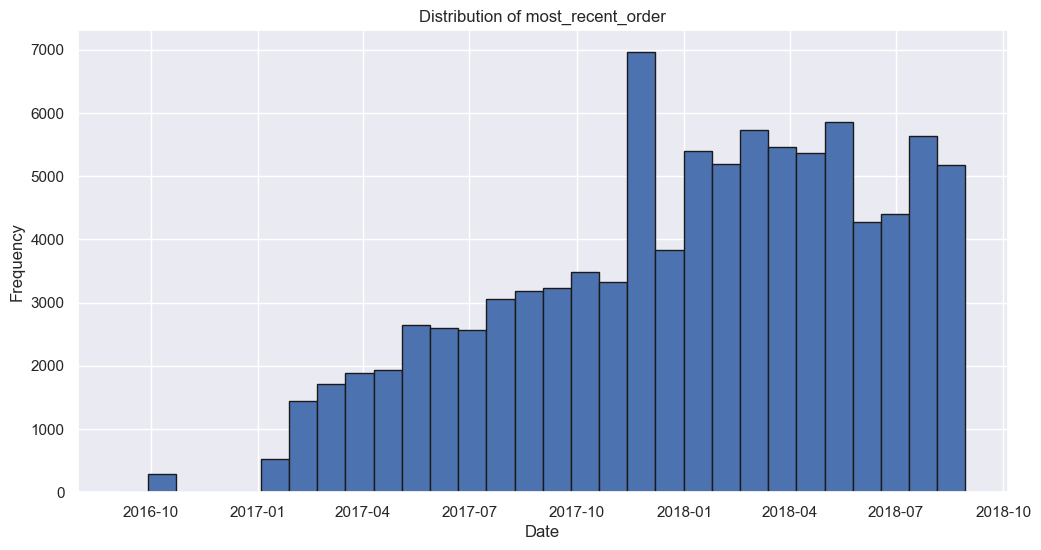

In [57]:
# le R de RFM

plt.figure(figsize=(12, 6))
rfm_df['most_recent_order'].hist(bins=30, edgecolor='k')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Distribution of most_recent_order')
plt.show()


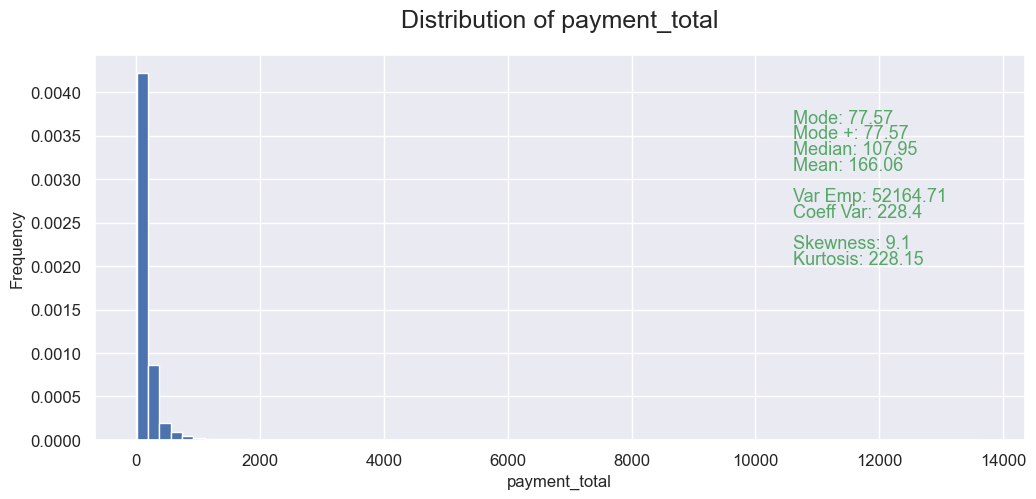

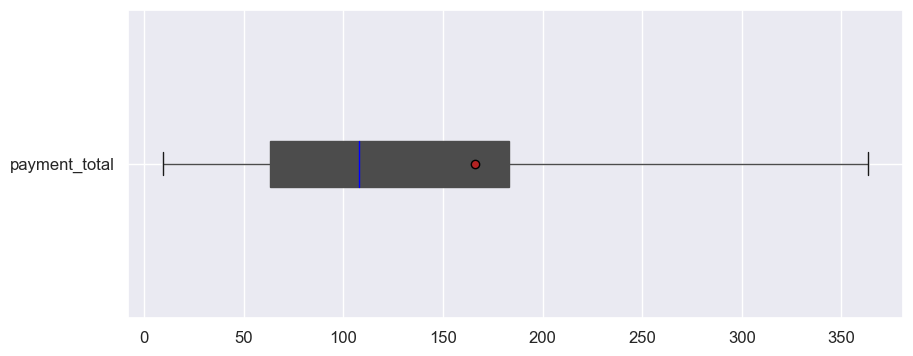

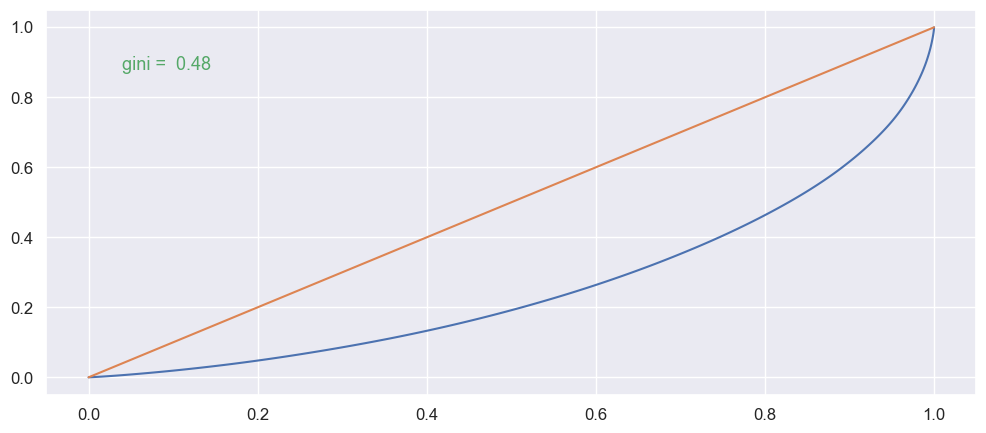

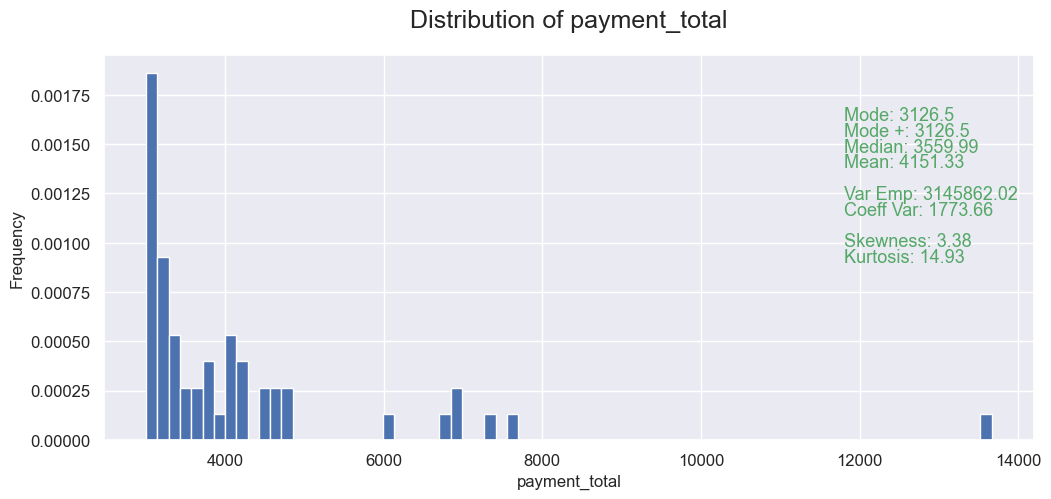

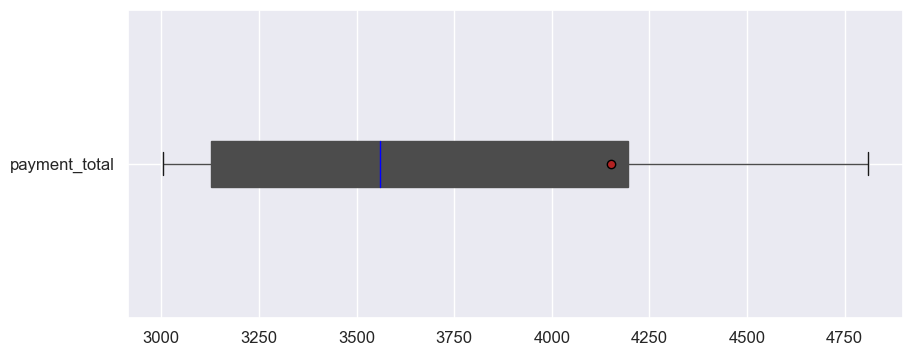

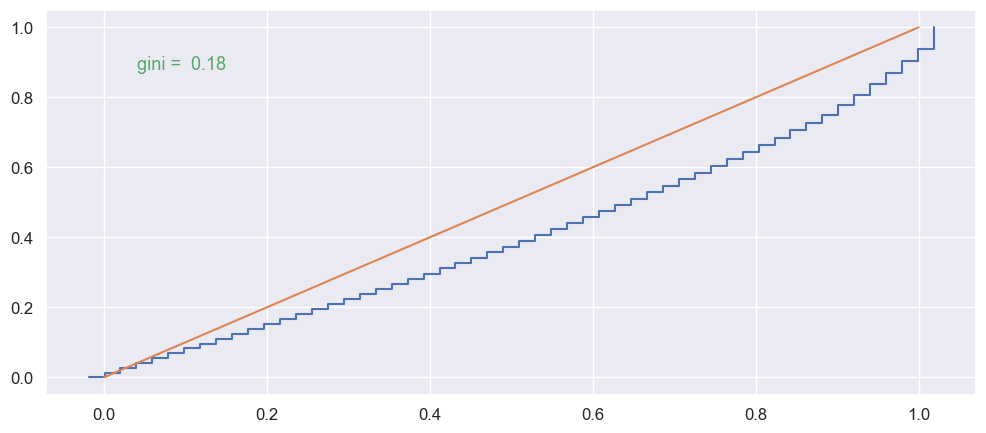

In [58]:
# Le M

graphs_analyse_uni(rfm_df, 'payment_total', bins=75, r=2, density=True)


graphs_analyse_uni(rfm_df.loc[rfm_df['payment_total'] > 3000], 
                   'payment_total', bins=75, r=2, density=True)


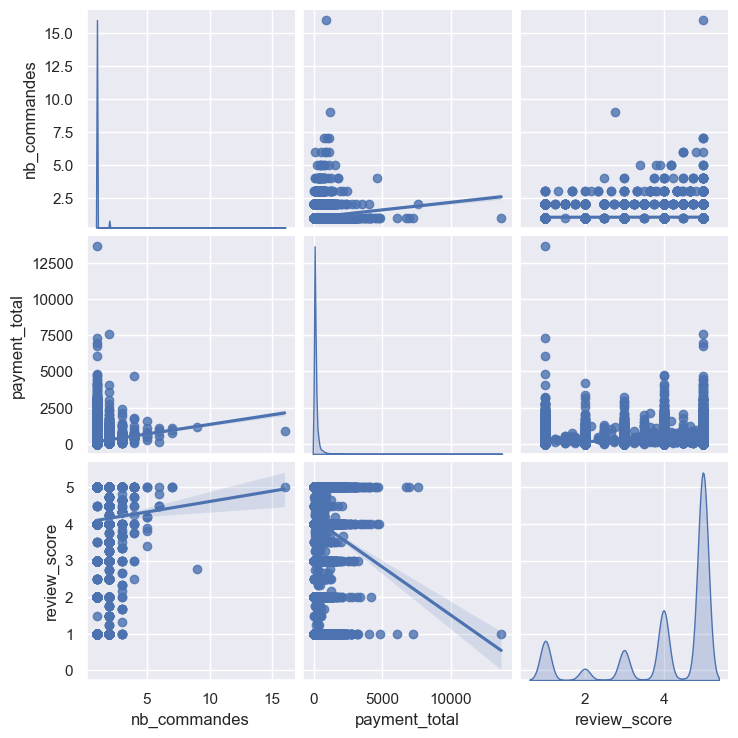

In [69]:
# Pas vraiment besoin d'analyse multivariée ici, puisque les features sont imposées
# On peut juste jeter un coup d'oeil au pairplot par curiosité

import warnings 

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning) # seaborn internally uses some deprecated functions
    warnings.filterwarnings("ignore", category=UserWarning) # tight layout notification
    _ = sns.pairplot(rfm_df.loc[rfm_df['review_score'].notna(), 
                            ['nb_commandes', 'payment_total', 'review_score']], 
                            kind="reg", diag_kind="kde")


### Export

In [60]:
# On a de quoi clusteriser !

rfm_df.to_csv('data/rfm.csv', sep=',', index=False)


## Annexes (/brouillon)

/home/ubuntu/anaconda3/envs/myenv_p3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning:

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.

/home/ubuntu/anaconda3/envs/myenv_p3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



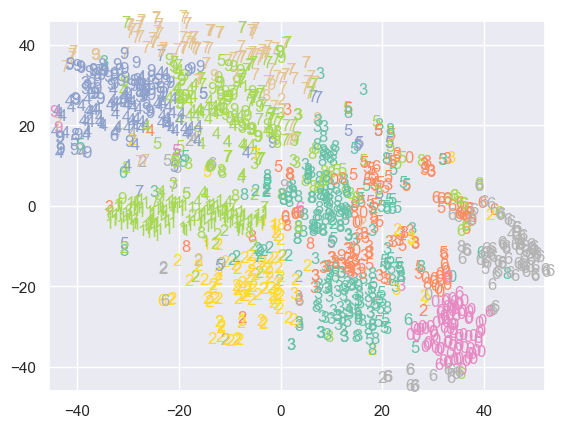

Silhouette Coefficient: 0.062
Adjusted Rand Index: 0.416


In [61]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import manifold
from sklearn import metrics

# Load the MNIST dataset
mnist = datasets.fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist.data[::50, :]
y = mnist.target[::50].astype(int)

# 1. Choose clustering with k-means
myclust = KMeans(n_clusters=10)
myclust.fit(X)

# 2. Dimension reduction using t-SNE
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

tsne = manifold.TSNE(n_components=2, init='pca')
X_trans = tsne.fit_transform(X_scaled)

# Visualization
plt.figure()
for i in range(X.shape[0]):
    plt.text(X_trans[i, 0], X_trans[i, 1], str('%d' % y[i]),
             color=plt.cm.Set2(myclust.labels_[i] / 10.))

plt.xlim([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])])
plt.ylim([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])])
plt.show()

# 3. Evaluation
silhouette_score = metrics.silhouette_score(X, myclust.labels_)
adjusted_rand_index = metrics.adjusted_rand_score(y, myclust.labels_)

print(f"Silhouette Coefficient: {silhouette_score:.3f}")
print(f"Adjusted Rand Index: {adjusted_rand_index:.3f}")


### sphere using matplotlib... interesting but seems limited

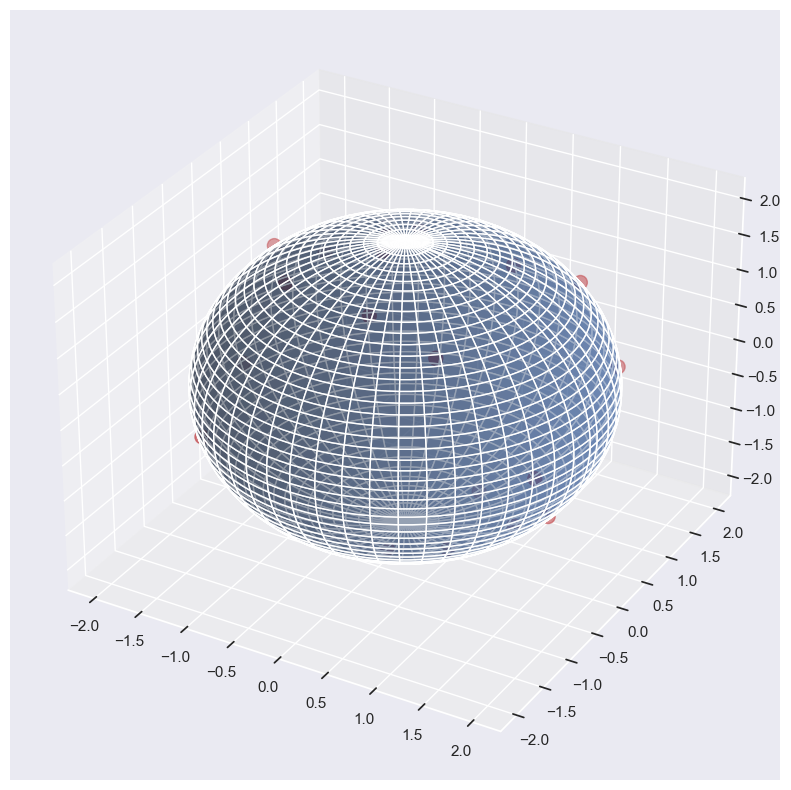

In [62]:
# Create a figure and a 3D axis
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Increase the radius of the sphere
r = 2  # Larger radius

# Generate some sample data
theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, np.pi, 100)
theta, phi = np.meshgrid(theta, phi)

# Convert spherical coordinates to Cartesian coordinates
x = r * np.sin(phi) * np.cos(theta)
y = r * np.sin(phi) * np.sin(theta)
z = r * np.cos(phi)

# Plot the larger sphere
ax.plot_surface(x, y, z, color='b', alpha=0.5)

# Increase the size of the points
point_count = 20
theta_points = np.random.uniform(0, 2 * np.pi, point_count)
phi_points = np.random.uniform(0, np.pi, point_count)
x_points = r * np.sin(phi_points) * np.cos(theta_points)
y_points = r * np.sin(phi_points) * np.sin(theta_points)
z_points = r * np.cos(phi_points)

ax.scatter(x_points, y_points, z_points, color='r', s=100)  # Larger points

plt.show()


### Earth using plotly... much better ! (+ img export)

In [63]:
import plotly.graph_objects as go
import plotly.io as pio

# Create a 3D scatter plot with Earth coordinates
earth = go.Scattergeo(
    lon=raw_df_geo['geolocation_lng'].iloc[::30],
    lat=raw_df_geo['geolocation_lat'].iloc[::30],
    mode='markers',
    marker=dict(size=3, color='red')
)



# Create a layout with a 3D scene
layout = go.Layout(
    title="La casa d'El Gringo",  # Add the title here
    geo=dict(
        showland=True,
        showocean=True,
        showcoastlines=True,
        projection_type='orthographic',
        landcolor='rgba(200, 200, 200, 1.0)',
        oceancolor='rgba(0, 0, 255, 1.0)',
        bgcolor='black',
        projection_rotation=dict(lon=-60, lat=-15)  # Rotate the Earth view
    ),
    annotations=[
        # Create a star-like annotation in the top-left corner
        dict(
            text="★",
            showarrow=False,
            font=dict(size=24),
            x=0,
            xref="paper",
            y=1,
            yref="paper",
        ),
    ]
)

# Create a figure that combines the Earth plot and the layout
fig = go.Figure(data=[earth], layout=layout)

fig.update_layout(
    height=600,
    width=800,
    paper_bgcolor='black'
)

# Export the plot as an image
# pio.write_image(fig, 'earth_plot.png')

# Display the 3D Earth plot
fig.show()


### Faster but harder to customize

In [64]:
import plotly.express as px

# Subsample your data
subsampled_data = raw_df_geo.iloc[::20]

# Create a 3D scatter plot with Earth coordinates using Plotly Express
fig = px.scatter_geo(subsampled_data, lon='geolocation_lng', lat='geolocation_lat', color_discrete_sequence=['red'],
                     width=800, height=600)

# Customize the layout
fig.update_geos(
    showland=True,
    showocean=True,
    showcoastlines=True,
    projection_type='orthographic',
    landcolor='rgb(200, 200, 200)',
    oceancolor='rgb(0, 0, 255)',
    projection_rotation=dict(lon=-60, lat=-15)  # Rotate the Earth view
)

fig.update_layout(
    scene=dict(
        aspectmode="cube",
        xaxis=dict(range=[-3, 3]),
        yaxis=dict(range=[-3, 3]),
        zaxis=dict(range=[-3, 3]),
        bgcolor='black'  # Set the background color for the 3D scene
    ),
    paper_bgcolor='black'
)

# Display the 3D Earth plot
fig.show()
